# Mecânica dos Fluidos & Elementos Finitos

Propriedades de alguns fluidos (Mecânicas dos Fluidos: fundamentos e aplicações - Yunus A. Çengel):

Ar (101kPa, 25 °C): $\rho \; (kg/m^3) = 1.184$ ,  $c_p \; (J/(kg.K)) = 1007$ ,  $\mu \; (Pa.s) = 1.849 \cdot 10^{-5}$ ,  $\nu \; (m^2/s) = 1.562 \cdot 10^{-5}$

$CO_2$ (101kPa, 50 °C): $\rho \; (kg/m^3) = 1.6597$ ,  $c_p \; (J/(kg.K)) = 866.6$ ,  $\mu \; (Pa.s) = 1.612 \cdot 10^{-5}$ ,  $\nu \; (m^2/s) = 9.714 \cdot 10^{-6}$

Metano (-90°C): $\rho \; (kg/m^3) = 261.7$ ,  $c_p \; (J/(kg.K)) = 8902$ ,  $\mu \; (Pa.s) = 2.761 \cdot 10^{-5}$ ,  $\nu \; (m^2/s) = 1.055 \cdot 10^{-7}$

Metanol (101kPa, 30°C): $\rho \; (kg/m^3) = 779.1$ ,  $c_p \; (J/(kg.K)) = 2577$ ,  $\mu \; (Pa.s) = 5.088 \cdot 10^{-4}$ ,  $\nu \; (m^2/s) = 6.531 \cdot 10^{-7}$

Isobutano (R600a) (101kPa, 25 °C): $\rho \; (kg/m^3) = 550.7$, $c_p \; (J/(kg.K)) = 2455$, $\mu \; (Pa.s) = 1.510 \cdot 10^{-4}$, $\nu \; (m^2/s) = 2.743 \cdot 10^{-7}$

óleo de motor (101kPa, 20 °C): $\rho \; (kg/m^3) = 888.1$, $c_p \; (J/(kg.K)) = 1881$, $\mu \; (Pa.s) = 0.8374$

Glicerina (101kPa, 25 °C): $\rho \; (kg/m^3) = 1261$, $c_p \; (J/(kg.K)) = 2420$, $\mu \; (Pa.s) = 0.9934$

---

Diâmetro padrão do escapamento de um motor dada a sua cilindrada:

https://www.pipsisland.com/what-size-exhaust-pipe-do-i-need/


In [1]:
import math
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.tri as mtri
import meshio
from scipy.spatial import Delaunay
import scipy as sp
import pandas as pd
import os                # Library used for system interaction (such as listing files in a directory,...)
import itertools as it   #biblioteca com funções de permutação a serem usadas na interação da matriz de conectividade com a global

## Thomas Algorithm

In [73]:
A1 = np.array([[5.0,2.0,0.0,0.0,0.0],
              [1.0,4.0,2.0,0.0,0.0],
              [0.0,1.0,3.0,2.0,0.0],
              [0.0,0.0,1.0,2.0,2.0],
              [0.0,0.0,0.0,1.0,1.0]])

b1 = np.array([0.0,1.0,2.0,2.0,3.0])

#d = np.array([0.0,1.0,2.0,2.0,3.0,4.0])

X = np.linalg.solve(A,b)
print(X)

# To reach list elements from backwards
#d = np.array([0.0,1.0,2.0,2.0,3.0,4.0])
#print(d[-6])
#print(list(range(-2,-6,-1))) #Wrong
#print(list(range(-2,-7,-1))) #Correct


[-1.    2.5  -4.    5.75 -2.75]


In [3]:
def ThomasSolver(A,b):
    a1 = A.diagonal(offset=-1)
    a1 = np.ndarray.tolist(a1)
    a1 = np.array(a1)

    a2 = A.diagonal(offset=0)
    a2 = np.ndarray.tolist(a2)
    a2 = np.array(a2)

    a3 = A.diagonal(offset=1)
    a3= np.ndarray.tolist(a3)
    a3 = np.array(a3)

    d = b
    n = len(d) # n em números é linhas
    
    alpha = np.empty(n)
    alpha[0] = a2[0]

    beta = np.empty(n-1)

    y = np.empty(n)
    y[0] = d[0]
    for i in range(1,n):
        beta[i-1] = a1[i-1]/alpha[i-1]
        alpha[i] = a2[i] - beta[i-1]*a3[i-1]
        
        y[i] = d[i] - beta[i-1]*y[i-1]

    x = np.empty(n)
    x[-1] = y[-1]/alpha[-1]
    for i in range(-2,-n-1,-1):  
        #ATENÇÃO: A contagem de trás pra frente começa em -1 e vai até -n, diferente da ordem normal, que vai de 0 a n-1.
        #ATENÇÃO: Apesar disso, o range continua indo de -1 a n+1 (equivalente de 0 a n-1), por isso é necessário o -n-1 no range.
        x[i] = (y[i] - a3[i+1]*x[i+1])/alpha[i]
        
    return x

## Funções de forma (ou interpolação)

In [6]:
#1D----------------------------------------------
##1ª ordem:
#N1 = [N11, N12]

def N11(x,X1,X2):
    return (X2-x)/(X2-X1)

def N12(x,X1,X2):
    return (x-X1)/(X2-X1)

def B11(x,X1,X2):
    return -1/(X2-X1)

def B12(x,X1,X2):
    return 1/(X2-X1)

##2ª ordem:
#N2 = [N21, N22, N23]

def N21(x,X1,X2,X3):
    return 2*(x-X2)*(x-X3)/(X3-X1)**2

def N22(x,X1,X2,X3):
    return (-4)*(x-X1)*(x-X3)/(X3-X1)**2

def N23(x,X1,X2,X3):
    return 2*(x-X1)*(x-X2)/(X3-X1)**2

# B2 = [B21, B22, B23]

def B21(x,X1,X2,X3):
    return 2*(2*x-(X2+X3))/(X3-X1)**2

def B22(x,X1,X2,X3):
    return (-4)*(2*x-(X1+X3))/(X3-X1)**2

def B23(x,X1,X2,X3):
    return 2*(2*x-(X1+X2))/(X3-X1)**2


#2D----------------------------------------------
##1ª ordem:
#N2D_1 = [N2D_11,N2D_12,N2D_13]

def N2D_11(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return (1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y)

def N2D_12(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return (1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y)

def N2D_13(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return (1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y)

def B2D_11(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([(1/(2*A))*(Y2-Y3), (1/(2*A))*(X3-X2), 0])

def B2D_12(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([(1/(2*A))*(Y3-Y1), (1/(2*A))*(X1-X3), 0])

def B2D_13(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([(1/(2*A))*(Y1-Y2), (1/(2*A))*(X2-X1), 0])


##Mini:
#N2D_M = [N2D_M1,N2D_M2,N2D_M3,N2D_M4]

def N2D_M1(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return (1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y) - 9*((1/(2*A))**3*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y)*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y)*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y))

def N2D_M2(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return (1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y) - 9*((1/(2*A))**3*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y)*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y)*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y))

def N2D_M3(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return (1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y) - 9*((1/(2*A))**3*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y)*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y)*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y))

def N2D_M4(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return 27*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y)*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y)*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y)

def B2D_M1(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([(1/(2*A))*(Y2-Y3) - 9*(1/(2*A))**3*((Y2-Y3)*(y*(X2-X1)+X1*Y2-X2*Y1+x*(Y1-Y2))*(y*(X1-X3)-X1*Y3+X3*Y1+x*(Y3-Y1)) + \
                                                         (Y1-Y2)*(y*(X1-X3)-X1*Y3+X3*Y1+x*(Y3-Y1))*(y*(X3-X2)+X2*Y3-X3*Y2+x*(Y2-Y3)) + \
                                                         (Y3-Y1)*(y*(X2-X1)+X1*Y2-X2*Y1+x*(Y1-Y2))*(y*(X3-X2)+X2*Y3-X3*Y2+x*(Y2-Y3))),
                     (1/(2*A))*(X3-X2) - 9*(1/(2*A))**3*((X3-X2)*(y*(X2-X1)+X1*Y2-X2*Y1+x*(Y1-Y2))*(y*(X1-X3)-X1*Y3+X3*Y1+x*(Y3-Y1)) + \
                                                         (X2-X1)*(y*(X1-X3)-X1*Y3+X3*Y1+x*(Y3-Y1))*(y*(X3-X2)+X2*Y3-X3*Y2+x*(Y2-Y3)) + \
                                                         (X1-X3)*(y*(X2-X1)+X1*Y2-X2*Y1+x*(Y1-Y2))*(y*(X3-X2)+X2*Y3-X3*Y2+x*(Y2-Y3))),
                     0])

def B2D_M2(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([(1/(2*A))*(Y3-Y1) - 9*(1/(2*A))**3*((Y2-Y3)*(y*(X2-X1)+X1*Y2-X2*Y1+x*(Y1-Y2))*(y*(X1-X3)-X1*Y3+X3*Y1+x*(Y3-Y1)) + \
                                                         (Y1-Y2)*(y*(X1-X3)-X1*Y3+X3*Y1+x*(Y3-Y1))*(y*(X3-X2)+X2*Y3-X3*Y2+x*(Y2-Y3)) + \
                                                         (Y3-Y1)*(y*(X2-X1)+X1*Y2-X2*Y1+x*(Y1-Y2))*(y*(X3-X2)+X2*Y3-X3*Y2+x*(Y2-Y3))),
                     (1/(2*A))*(X1-X3) - 9*(1/(2*A))**3*((X3-X2)*(y*(X2-X1)+X1*Y2-X2*Y1+x*(Y1-Y2))*(y*(X1-X3)-X1*Y3+X3*Y1+x*(Y3-Y1)) + \
                                                         (X2-X1)*(y*(X1-X3)-X1*Y3+X3*Y1+x*(Y3-Y1))*(y*(X3-X2)+X2*Y3-X3*Y2+x*(Y2-Y3)) + \
                                                         (X1-X3)*(y*(X2-X1)+X1*Y2-X2*Y1+x*(Y1-Y2))*(y*(X3-X2)+X2*Y3-X3*Y2+x*(Y2-Y3))),
                     0])

def B2D_M3(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([(1/(2*A))*(Y1-Y2) - 9*(1/(2*A))**3*((Y2-Y3)*(y*(X2-X1)+X1*Y2-X2*Y1+x*(Y1-Y2))*(y*(X1-X3)-X1*Y3+X3*Y1+x*(Y3-Y1)) + \
                                                         (Y1-Y2)*(y*(X1-X3)-X1*Y3+X3*Y1+x*(Y3-Y1))*(y*(X3-X2)+X2*Y3-X3*Y2+x*(Y2-Y3)) + \
                                                         (Y3-Y1)*(y*(X2-X1)+X1*Y2-X2*Y1+x*(Y1-Y2))*(y*(X3-X2)+X2*Y3-X3*Y2+x*(Y2-Y3))),
                     (1/(2*A))*(X2-X1) - 9*(1/(2*A))**3*((X3-X2)*(y*(X2-X1)+X1*Y2-X2*Y1+x*(Y1-Y2))*(y*(X1-X3)-X1*Y3+X3*Y1+x*(Y3-Y1)) + \
                                                         (X2-X1)*(y*(X1-X3)-X1*Y3+X3*Y1+x*(Y3-Y1))*(y*(X3-X2)+X2*Y3-X3*Y2+x*(Y2-Y3)) + \
                                                         (X1-X3)*(y*(X2-X1)+X1*Y2-X2*Y1+x*(Y1-Y2))*(y*(X3-X2)+X2*Y3-X3*Y2+x*(Y2-Y3))),
                     0])

def B2D_M4(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([27*((Y2-Y3)*(y*(X2-X1)+X1*Y2-X2*Y1+x*(Y1-Y2))*(y*(X1-X3)-X1*Y3+X3*Y1+x*(Y3-Y1)) + \
                                                         (Y1-Y2)*(y*(X1-X3)-X1*Y3+X3*Y1+x*(Y3-Y1))*(y*(X3-X2)+X2*Y3-X3*Y2+x*(Y2-Y3)) + \
                                                         (Y3-Y1)*(y*(X2-X1)+X1*Y2-X2*Y1+x*(Y1-Y2))*(y*(X3-X2)+X2*Y3-X3*Y2+x*(Y2-Y3))),
                     27*((X3-X2)*(y*(X2-X1)+X1*Y2-X2*Y1+x*(Y1-Y2))*(y*(X1-X3)-X1*Y3+X3*Y1+x*(Y3-Y1)) + \
                                                         (X2-X1)*(y*(X1-X3)-X1*Y3+X3*Y1+x*(Y3-Y1))*(y*(X3-X2)+X2*Y3-X3*Y2+x*(Y2-Y3)) + \
                                                         (X1-X3)*(y*(X2-X1)+X1*Y2-X2*Y1+x*(Y1-Y2))*(y*(X3-X2)+X2*Y3-X3*Y2+x*(Y2-Y3))),
                     0])


##2ª ordem:
#N2D_2 = [N2D_11,N2D_12,N2D_13,N2D_14,N2D_15,N2D_16]

def N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return ((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y))*(2*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y)) - 1)

def N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return ((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y))*(2*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y)) - 1)

def N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return ((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y))*(2*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y)) - 1)

def N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return 4*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y))*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y))

def N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return 4*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y))*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y))

def N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return 4*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y))*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y))

def B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([((1/(2*A))*(Y2-Y3))*(2*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y)) - 1) + ((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y))*(2*(1/(2*A))*(Y2-Y3)),
                     ((1/(2*A))*(X3-X2))*(2*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y)) - 1) + ((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y))*(2*(1/(2*A))*(X3-X2)),
                     0])

def B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([((1/(2*A))*(Y3-Y1))*(2*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y)) - 1) + ((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y))*(2*(1/(2*A))*(Y3-Y1)), 
                     ((1/(2*A))*(X1-X3))*(2*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y)) - 1) + ((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y))*(2*(1/(2*A))*(X1-X3)), 
                     0])

def B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([((1/(2*A))*(Y1-Y2))*(2*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y)) - 1) + ((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y))*(2*(1/(2*A))*(Y1-Y2)), 
                     ((1/(2*A))*(X2-X1))*(2*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y)) - 1) + ((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y))*(2*(1/(2*A))*(X2-X1)), 
                     0])

def B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([4*((1/(2*A))*(Y2-Y3))*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y)) + 4*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y))*((1/(2*A))*(Y3-Y1)), 
                     4*((1/(2*A))*(X3-X2))*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y)) + 4*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y))*((1/(2*A))*(X1-X3)), 
                     0])

def B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([4*((1/(2*A))*(Y3-Y1))*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y)) + 4*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y))*((1/(2*A))*(Y1-Y2)), 
                     4*((1/(2*A))*(X1-X3))*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y)) + 4*((1/(2*A))*(X3*Y1-X1*Y3+(Y3-Y1)*x+(X1-X3)*y))*((1/(2*A))*(X2-X1)), 
                     0])

def B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A):
    return np.array([4*((1/(2*A))*(Y1-Y2))*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y)) + 4*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y))*((1/(2*A))*(Y2-Y3)), 
                     4*((1/(2*A))*(X2-X1))*((1/(2*A))*(X2*Y3-X3*Y2+(Y2-Y3)*x+(X3-X2)*y)) + 4*((1/(2*A))*(X1*Y2-X2*Y1+(Y1-Y2)*x+(X2-X1)*y))*((1/(2*A))*(X3-X2)),
                     0])



## Formulação corrente-vorticidade

\begin{equation}
 \left\{ \begin{aligned}
         \frac{\partial \omega_z}{\partial t} + v \cdot \nabla \omega_z = \nu \nabla^2 \omega_z \\
         \nabla^2 \psi = -\omega_z \\
         v_x = \frac{\partial \psi}{\partial y} \:,\; v_y = -\frac{\partial \psi}{\partial x}
        \end{aligned}
 \right.
\end{equation}

Tendo o campo de velocidades inicial, usa-se a equação de transporte de vorticidade para obter o campo de vorticidade do escoamento e a partir dele obter a função corrente. Veja a forma fraca e discretização da Equação de Transporte de Vorticidade abaixo:

$$ \frac{\partial \omega_z}{\partial t} + v \cdot \nabla \omega_z = \nu \nabla^2 \omega_z $$

Formulação fraca:

$$ \int_\Omega \left [ \frac{\partial \omega_z}{\partial t} + v \cdot \nabla \omega_z -\nu \nabla^2 \omega_z \right ] \; d\Omega = 0 $$

$$ \int_{\Omega} \omega \frac{\partial \omega_z}{\partial t} \; d\Omega + \int_{\Omega} \omega \cdot \vec{v} \cdot \nabla\omega_z \; d\Omega - \int_{\Gamma} \omega \cdot \nu \nabla\omega_z \; d\Gamma + \int_{\Omega} \nabla\omega \cdot \nu \nabla\omega_z \; d\Omega = 0 $$

Discretizando a formulação fraca:

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_j\omega_j \cdot \frac{\partial (N_i\omega_{z_i})}{\partial t} \; d\Omega + \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_j\omega_j \cdot \vec{v} \cdot B_i\omega_{z_i} \; d\Omega - \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Gamma} N_j\omega_j \cdot (\nu B_i\omega_{z_i}) \; d\Gamma + \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} B_j\omega_j \cdot (\nu B_i\omega_{z_i}) \; d\Omega = 0 $$

Dividindo a equação pela função peso $\omega$ e retirando $\omega_{z_i}$ das integrais:

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_j N_i \; d\Omega \cdot \frac{\partial \omega_{z_i}}{\partial t} + \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} \vec{v} \cdot N_j B_i \; d\Omega \cdot \omega_{z_i} - \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Gamma} N_j \cdot (\nu B_i) \; d\Gamma \cdot \omega_{z_i} + \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} B_j \cdot (\nu B_i) \; d\Omega \cdot \omega_{z_i} = 0 $$

Substituindo os somatórios duplos por somatórios de elemento, assumindo velocidade e viscosidade constantes para o escoamento e estipulando condições de contorno de Dirichlet, a equação assume a seguinte forma: 

$$ \sum_{e}^{\infty} \int_{\Omega} N_j N_i \; d\Omega \cdot \frac{\partial \omega_{z_i}}{\partial t} + \sum_{e}^{\infty} \vec{v} \int_{\Omega} N_j B_i \; d\Omega \cdot \omega_{z_i} + \sum_{e}^{\infty} \nu \int_{\Omega} B_j B_i \; d\Omega \cdot \omega_{z_i} = 0 $$

Lembrando que as integrais das funções de interpolação correspondem a matrizes elementares de massa, gradiente e viscosidade:

$$ M^e = \int_{\Omega} N_j N_i \; d\Omega \;\;,\;\;\;\; G^e = \int_{\Omega} N_j B_i \; d\Omega \;\;,\;\;\;\; K^e = \int_{\Omega} B_j B_i \; d\Omega$$

Substituindo o somatório de matrizes elementares por suas respectivas matrizes globais:

$$ M \frac{\partial \omega_{z_i}}{\partial t} + \vec{v} \cdot G \omega_{z_i} + \nu K \omega_{z_i} = 0 $$

Finalmente, efetuando a discretização **avançada e implícita** no tempo, tem-se:

$$ M \frac{\omega_{z_i}^{n+1} - \omega_{z_i}^{n}}{\Delta t} + \vec{v} \cdot G \omega_{z_i}^{n+1} + \nu K \omega_{z_i}^{n+1} = 0 $$

$$ \left( \frac{M}{\Delta t} + \nu K + \vec{v} \cdot G \right) \omega_{z_i}^{n+1} = \frac{M}{\Delta t} \omega_{z_i}^{n} + c.c. $$

O termo de convecção ainda pode ser expandido para identificação das matrizes do gradiente nas direções x e y:

$$ \vec{v} \cdot G = (\vec{v_x} I) \cdot G_x + (\vec{v_y} I) \cdot G_y $$

Note que $\vec{v}$ corresponde a uma matriz diagonal.

$$ \left( \frac{M}{\Delta t} + \nu K + (\vec{v_x} I) \cdot G_x + (\vec{v_y} I) \cdot G_y \right) \omega_{z_i}^{n+1} = \frac{M}{\Delta t} \omega_{z_i}^{n} + c.c. $$

---

Com a equação acima é possível obter os valores de vorticidade para um escoamento em domínio bidimensional. Tendo-os em mãos, utiliza-se a Equação Corrente-Vorticidade para obter a função corrente deste escoamento:

$$ \nabla^2 \psi = -\omega_z \;\; \Rightarrow \;\; \int_{\Omega} \omega \cdot [ \nabla \cdot (\nabla \psi) + \omega_z ] \;\; d\Omega = 0 $$

$$ \oint_{\Gamma} \omega \nabla \psi \cdot \vec{n} \;\; d\Gamma - \int_{\Omega} \nabla \omega \cdot \nabla \psi \;\; d\Omega + \int_{\Omega} \omega \cdot \omega_z \;\; d\Omega = 0 $$ 

$$ - \oint_{\Gamma} \omega \nabla \psi \;\; d\Gamma - \int_{\Omega} \nabla \omega \cdot \nabla \psi \;\; d\Omega + \int_{\Omega} \omega \cdot \omega_z \;\; d\Omega = 0$$

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} \left [ \int_{\Omega} B_j B_i \;\; d\Omega \cdot \psi_i + \int_{\Gamma} N_j B_i \;\; d\Gamma \cdot \psi_i \right ] - \sum_{k}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_j N_k \;\; d\Omega \cdot \omega_{z_i} = 0 $$

--- 

Finalmente, sabendo a função corrente associada ao escoamento, pode-se obter a partir de sua definição o campo de velocidades do escoamento e, assim, poder avançar para o próximo instante de tempo e descobrir a novamente o campo de vorticidades:

$$ v_x = \frac{\partial \psi}{\partial y} \:,\; v_y = -\frac{\partial \psi}{\partial x} $$

$$ \int_{\Omega} \omega \cdot \left [ v_x - \frac{\partial \psi}{\partial y} \right ] \; d\Omega = 0 \;,\;\; \int_{\Omega} \omega \cdot \left [ v_y + \frac{\partial \psi}{\partial x} \right ] \; d\Omega = 0 $$

$$ v_x: \;\;\; \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_j N_i \;\; d\Omega \cdot v_{x_i} = \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_j B_i^y \;\; d\Omega \cdot \psi_i \;\;,\;\;\; B^y = \frac{\partial N}{\partial y}$$
$$ v_y:  \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_j N_i \;\; d\Omega \cdot v_{y_i} = -\sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_j B_i^x \;\; d\Omega \cdot \psi_i \;\;,\;\;\; B^x = \frac{\partial N}{\partial x}$$

### Domínio: canal livre (malha uniforme via Gmsh e gerando .vtk)

#### Characteristic Galerkin

In [ ]:
# Criando diretório para armazenar solução

# Specify the folder in which results will be exported (mostly graphs)
#workingDir = r"C:\Users\João Pedro\Downloads\ElementosFinitos"   #Notebook pessoal
workingDir = r"C:\Users\jferreira\Downloads\ElementosFinitos"   #TechnipFMC
fileName = "Solucao_Retangulo_(1.00x2.00)_0.05_mesh_0.01_nu_0.05_dt_0.5_vxcc_ESTABcorreto_Sparse"
outputPath = workingDir + "\\" + fileName

if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    print("Directory " , outputPath ,  " has been created ")
else:
    print("Directory " , outputPath ,  " already exists")

# Propriedades do fluido e domínio:

nu = 0.01

to = 0
tf = 4
dt = 0.05
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)

mshname = 'Retangulo_(1.00x2.00)_0.05_mesh.msh'
msh = meshio.read('./' + mshname)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = len(IEN)
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 5)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]
# prioridade 4
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'Admissao':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 3
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'Exaustao':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 2
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'CCInferior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 1
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'CCSuperior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'CCInferior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'CCSuperior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 1.0
 if ccName[i] == 'Admissao':
  vxcc[i] = 0.5
  vycc[i] = 0.0
  PSIcc[i] = Y[i]


# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
PSI = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vx[i] = vxcc[i]
 vy[i] = vycc[i]


# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (npoints,npoints),dtype='float' )
Kest = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 
 kelem = (1/(4*area))*kxelem + (1/(4*area))*kyelem 

 kxy_elem = np.array([[b1*c1,b1*c2,b1*c3],
                     [b2*c1,b2*c2,b2*c3],
                     [b3*c1,b3*c2,b3*c3]])
 kyx_elem = np.array([[c1*b1,c1*b2,c1*b3],
                     [c2*b1,c2*b2,c2*b3],
                     [c3*b1,c3*b2,c3*b3]])
 Vxm = (vx[v1]+vx[v2]+vx[v3])/3.0
 Vym = (vy[v1]+vy[v2]+vy[v3])/3.0

 kelem_est = (Vxm*(dt/2)/(4*area))*(Vxm*kxelem + Vym*kxy_elem) + (Vym*(dt/2)/(4*area))*(Vxm*kyx_elem + Vym*kyelem)

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                               [1.0,2.0,1.0],
                               [1.0,1.0,2.0]])

 gxelem = (1/6)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   Kest[iglobal,jglobal] += kelem_est[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]


# Vorticidade nos contornos no instante inicial
#vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))
cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
vort_cc = sp.sparse.linalg.spsolve(cscM,(Gx@vy - Gy@vx))
vort = vort_cc.copy()


# Gravando condições de contorno e iniciais da solução em .vtk
point_data = {'PSIcc' : PSIcc}
data_vxcc = {'vxcc' : vxcc}
data_vycc = {'vycc' : vycc}
data_vort_cc = {'vort_cc' : vort_cc}
point_data.update(data_vxcc)
point_data.update(data_vycc)
point_data.update(data_vort_cc)
meshio.write_points_cells(outputPath +'\\'+'condicaoDeContorno.vtk',
                           msh.points, 
                           msh.cells,
                           point_data=point_data,
                           )


CampoVort = np.empty((npoints,nt))
CampoPSI = np.empty((npoints,nt))
CampoVx = np.empty((npoints,nt))
CampoVy = np.empty((npoints,nt))


# Avanço no tempo
for n in range(0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 #vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))
 cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
 vort_cc = sp.sparse.linalg.spsolve(cscM,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Atualizando matriz de estabilização a cada step
 Kest = np.zeros( (npoints,npoints),dtype='float' )

 for e in range(0,ne):
   v1,v2,v3 = IEN[e]

   Vxm = (vx[v1]+vx[v2]+vx[v3])/3.0
   Vym = (vy[v1]+vy[v2]+vy[v3])/3.0

   kelem_est = (Vxm*(dt/2)/(4*area))*(Vxm*kxelem + Vym*kxy_elem) + (Vym*(dt/2)/(4*area))*(Vxm*kyx_elem + Vym*kyelem)

   for ilocal in range(0,3):
     iglobal = IEN[e,ilocal]
     for jlocal in range(0,3):
       jglobal = IEN[e,jlocal]

       Kest[iglobal,jglobal] += kelem_est[ilocal,jlocal]

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + Kest + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort

 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'CCSuperior' or \
        ccName[i] == 'CCInferior' or \
        ccName[i] == 'Admissao':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 #vort = np.linalg.solve(A,b)
 cscA = sp.sparse.csc_matrix(A)   # Matrix form that improves sparse.linalg.solve
 vort = sp.sparse.linalg.spsolve(cscA,b)

 CampoVort[:,n] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
    if ccName[i] == 'CCSuperior' or \
       ccName[i] == 'CCInferior' or \
       ccName[i] == 'Admissao':
        Apsi[i,:] = 0.0 # zerando a linha
        Apsi[i,i] = 1.0 # colocando 1 na diagonal
        bpsi[i]   = PSIcc[i]

 ### Solução
 #PSI = np.linalg.solve(Apsi,bpsi)
 cscApsi = sp.sparse.csc_matrix(Apsi)   # Matrix form that improves sparse.linalg.solve
 PSI = sp.sparse.linalg.spsolve(cscApsi,bpsi)
 
 CampoPSI[:,n] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 #vx = np.linalg.solve(M,Gy@PSI)
 #vy = np.linalg.solve(M,-Gx@PSI)
 
 cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
 vx = sp.sparse.linalg.spsolve(cscM,Gy@PSI)
 vy = sp.sparse.linalg.spsolve(cscM,-Gx@PSI)
 
 for i in IENbound:
  if ccName[i] == 'CCSuperior' or \
     ccName[i] == 'CCInferior' or \
     ccName[i] == 'Admissao':
      vx[i] = vxcc[i]
      vy[i] = vycc[i]

 CampoVx[:,n] = vx
 CampoVy[:,n] = vy


# Gravando solução em .vtk
 print ("... gravando em VTK passo de tempo: " + str(n))
 point_data = {'psi' : PSI}
 data_vx = {'vx' : vx}
 data_vy = {'vy' : vy}
 data_vort = {'$\omega_z$' : vort}
 point_data.update(data_vx)
 point_data.update(data_vy)
 point_data.update(data_vort)
 meshio.write_points_cells(outputPath +'\\'+'solucao-'+str(n)+'.vtk',
                            msh.points, 
                            msh.cells,
                            point_data=point_data,
                            )

#### Plotagem

C:\Users\jferreira\AppData\Local\Temp\ipykernel_8932\1231777609.py:28: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax0.tricontourf(triang,CampoVort[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_8932\1231777609.py:47: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax1.tricontourf(triang,CampoPSI[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_8932\1231777609.py:66: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax2.tricontourf(triang,CampoVx[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_8932\1231777609.py:85: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax3.tricontourf(triang,CampoVy[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)


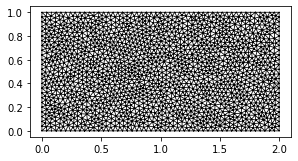

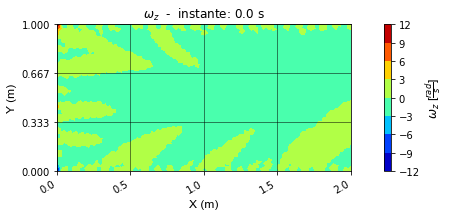

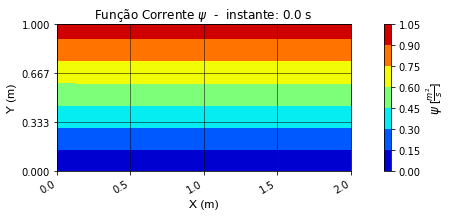

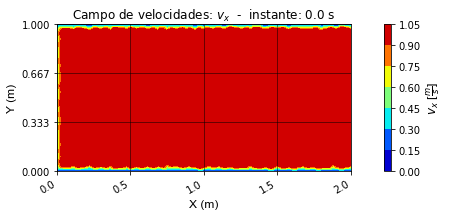

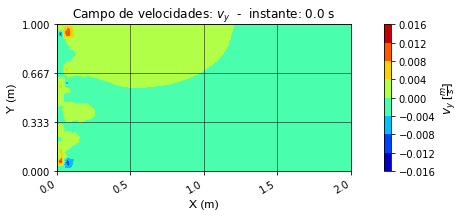

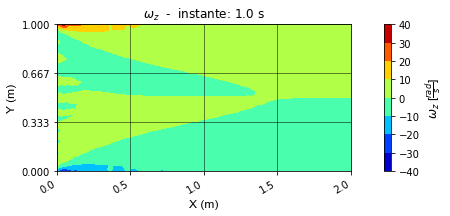

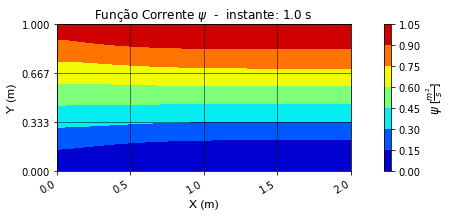

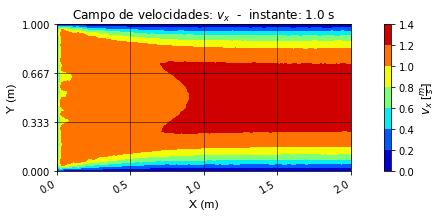

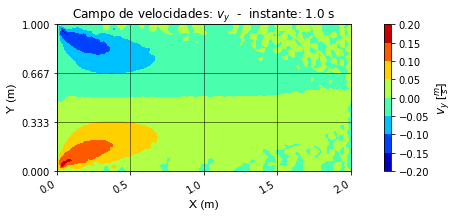

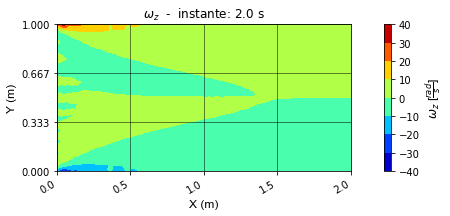

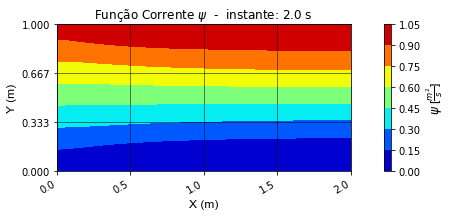

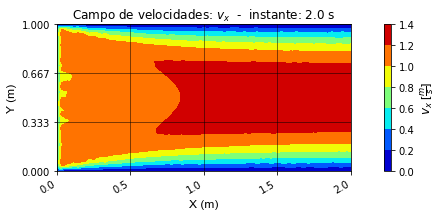

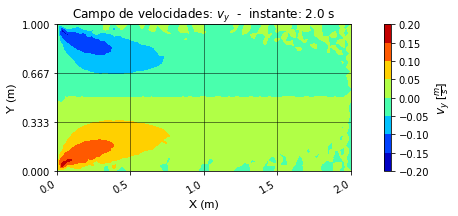

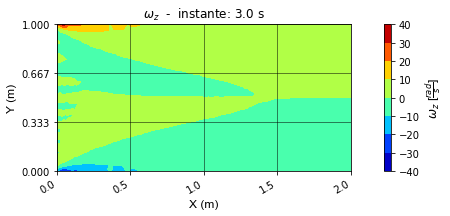

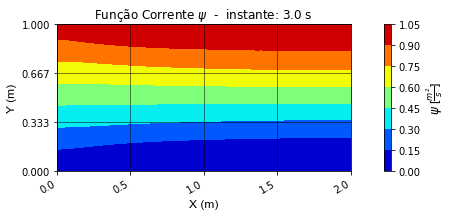

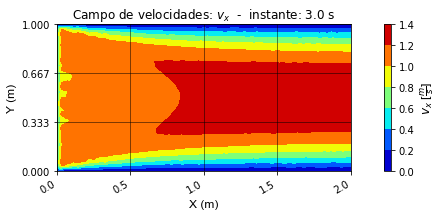

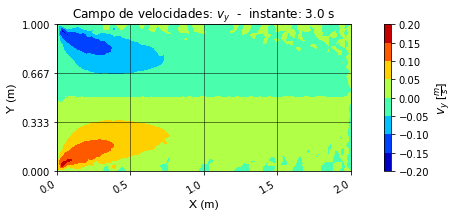

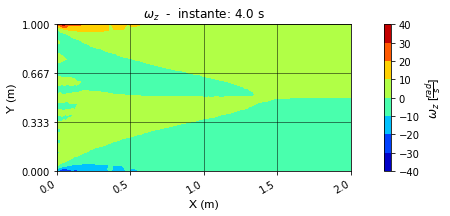

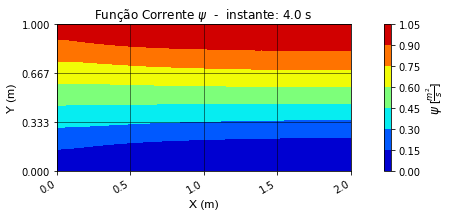

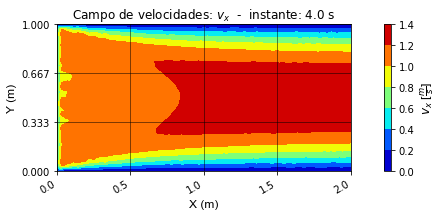

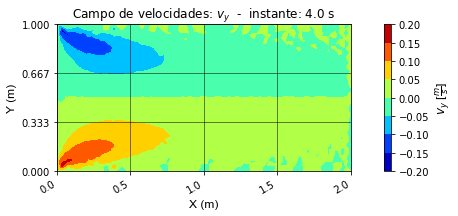

In [7]:
#--------------------------------------------------
# Fonte dos gráficos
matplot_font = {'fontname': 'Arial',
                'color':  'black',
                'weight': 'normal',
                'size': 12,
                }

# Plotando malha

fig, ax = plt.subplots(figsize = (9.6,2.4))

triang = mtri.Triangulation(X,Y,IEN)
ax.set_aspect('equal')
ax.triplot(triang,'k-', linewidth=0.8)

# Plotando gráficos

for t in range(0,nt,int(nt/4)):
#for t in range(0,20,5):
    tempo = t*dt

    ## Vorticidade
    fig, ax0 = plt.subplots(figsize = (12,3))
 
    triang = mtri.Triangulation(X,Y,IEN)
    ax0.set_aspect('equal')
    ax0.tricontourf(triang,CampoVort[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax0.tricontourf(triang,CampoVort[:,t],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\omega_z$ [$\\frac{rad}{s}$]',fontdict=matplot_font)
    plt.title("$\omega_z$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()
    
    ## PSI
    fig, ax1 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax1.set_aspect('equal')
    ax1.tricontourf(triang,CampoPSI[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax1.tricontourf(triang,CampoPSI[:,t],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\psi$ [$\\frac{m^2}{s}$]',fontdict=matplot_font)
    plt.title("Função Corrente $\psi$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vx
    fig, ax2 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax2.set_aspect('equal')
    ax2.tricontourf(triang,CampoVx[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax2.tricontourf(triang,CampoVx[:,t],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_x$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_x$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vy
    fig, ax3 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax3.set_aspect('equal')
    ax3.tricontourf(triang,CampoVy[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax3.tricontourf(triang,CampoVy[:,t],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_y$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_y$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    plt.show()

### Domínio: canal com 1 obstáculo (malha via Gmsh e gerando .vtk)

#### Galerkin

In [ ]:
# Criando diretório para armazenar solução

# Specify the folder in which results will be exported (mostly graphs)
workingDir = r"C:\Users\João Pedro\Downloads\ElementosFinitos"   #Notebook pessoal
#workingDir = r"C:\Users\jferreira\Downloads\ElementosFinitos"   #TechnipFMC
fileName = "Solucao_cilindro_(0.10x0.60)_0.006&0.002_mesh_0.0001_nu_0.01_dt_1.0_vxcc_teste"
outputPath = workingDir + "\\" + fileName

if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    print("Directory " , outputPath ,  " has been created ")
else:
    print("Directory " , outputPath ,  " already exists")

# Propriedades do fluido e domínio:

nu = 0.0001

to = 0.0
tf = 2.0
dt = 0.01
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
mshname = 'cilindro_(0.10x0.60)_0.006&0.002_mesh_0.04_D.msh'
msh = meshio.read('./' + mshname)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]

####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]
# prioridade 4
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'inlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 3
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'outlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 2
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeInf':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 1
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeSup':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'paredeInf':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'paredeSup':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.1
 if ccName[i] == 'inlet':
  vxcc[i] = 1.0
  vycc[i] = 0.0
  PSIcc[i] = Y[i]
 if ccName[i] == 'cilindro':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.05


# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 kelem = (1/(4*area))*kxelem + (1/(4*area))*kyelem

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                               [1.0,2.0,1.0],
                               [1.0,1.0,2.0]])

 gxelem = (1/6)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]


# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
PSI = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vx[i] = vxcc[i]
 vy[i] = vycc[i]

# Vorticidade nos contornos no instante inicial
vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))
vort = vort_cc.copy()


# Gravando condições de contorno e iniciais da solução em .vtk
point_data = {'PSIcc' : PSIcc}
data_vxcc = {'vxcc' : vxcc}
data_vycc = {'vycc' : vycc}
data_vort_cc = {'vort_cc' : vort_cc}
point_data.update(data_vxcc)
point_data.update(data_vycc)
point_data.update(data_vort_cc)
meshio.write_points_cells(outputPath +'\\'+'condicaoDeContorno.vtk',
                           msh.points, 
                           msh.cells,
                           point_data=point_data,
                           )


CampoVort = np.empty((npoints,nt))
CampoPSI = np.empty((npoints,nt))
CampoVx = np.empty((npoints,nt))
CampoVy = np.empty((npoints,nt))


# Avanço no tempo
for n in range(0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'paredeSup' or \
         ccName[i] == 'paredeInf' or \
         ccName[i] == 'cilindro' or \
         ccName[i] == 'inlet':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 vort = np.linalg.solve(A,b)

 CampoVort[:,n] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
    if ccName[i] == 'paredeSup' or \
       ccName[i] == 'paredeInf' or \
       ccName[i] == 'cilindro' or \
       ccName[i] == 'inlet':
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 PSI = np.linalg.solve(Apsi,bpsi)

 CampoPSI[:,n] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 vx = np.linalg.solve(M,Gy@PSI)
 vy = np.linalg.solve(M,-Gx@PSI)
 
 for i in IENbound:
  if ccName[i] == 'paredeSup' or \
     ccName[i] == 'paredeInf' or \
     ccName[i] == 'cilindro' or \
     ccName[i] == 'inlet':
     vx[i] = vxcc[i]
     vy[i] = vycc[i]

 CampoVx[:,n] = vx
 CampoVy[:,n] = vy


# Gravando solução em .vtk
 print ("... gravando em VTK passo de tempo: " + str(n))
 point_data = {'psi' : PSI}
 data_vx = {'vx' : vx}
 data_vy = {'vy' : vy}
 data_vort = {'$\omega_z$' : vort}
 point_data.update(data_vx)
 point_data.update(data_vy)
 point_data.update(data_vort)
 meshio.write_points_cells(outputPath +'\\'+'solucao-'+str(n)+'.vtk',
                            msh.points, 
                            msh.cells,
                            point_data=point_data,
                            )


#### Characteristic Galerkin (Estabilização)

In [ ]:
# Criando diretório para armazenar solução

# Specify the folder in which results will be exported (mostly graphs)
workingDir = r"C:\Users\João Pedro\Downloads\ElementosFinitos"   #Notebook pessoal
#workingDir = r"C:\Users\jferreira\Downloads\ElementosFinitos"   #TechnipFMC
fileName = "Solucao_cilindro_(0.10x0.60)_0.006&0.002_mesh_0.0001_nu_0.01_dt_1.0_vxcc_teste"
outputPath = workingDir + "\\" + fileName

if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    print("Directory " , outputPath ,  " has been created ")
else:
    print("Directory " , outputPath ,  " already exists")

# Propriedades do fluido e domínio:

nu = 0.0001

to = 0.0
tf = 2.0
dt = 0.01
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
mshname = 'cilindro_(0.10x0.60)_0.006&0.002_mesh_0.04_D.msh'
msh = meshio.read('./' + mshname)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]

####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]
# prioridade 4
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'inlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 3
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'outlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 2
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeInf':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 1
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeSup':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'paredeInf':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'paredeSup':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.1
 if ccName[i] == 'inlet':
  vxcc[i] = 1.0
  vycc[i] = 0.0
  PSIcc[i] = Y[i]
 if ccName[i] == 'cilindro':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.05


# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (npoints,npoints),dtype='float' )
Kest = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 
 kelem = (1/(4*area))*kxelem + (1/(4*area))*kyelem 

 kxy_elem = np.array([[b1*c1,b1*c2,b1*c3],
                     [b2*c1,b2*c2,b2*c3],
                     [b3*c1,b3*c2,b3*c3]])
 kyx_elem = np.array([[c1*b1,c1*b2,c1*b3],
                     [c2*b1,c2*b2,c2*b3],
                     [c3*b1,c3*b2,c3*b3]])
 Vxm = (vx[v1]+vx[v2]+vx[v3])/3.0
 Vym = (vy[v1]+vy[v2]+vy[v3])/3.0

 kelem_est = (Vxm*(dt/2)/(4*area))*(Vxm*kxelem + Vym*kxy_elem) + (Vym*(dt/2)/(4*area))*(Vxm*kyx_elem + Vym*kyelem)

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                               [1.0,2.0,1.0],
                               [1.0,1.0,2.0]])

 gxelem = (1/6)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal]    += kelem[ilocal,jlocal]
   Kest[iglobal,jglobal] += kelem_est[ilocal,jlocal]
   M[iglobal,jglobal]    += melem[ilocal,jlocal]
   Gx[iglobal,jglobal]   += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal]   += gyelem[ilocal,jlocal]


# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
PSI = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vx[i] = vxcc[i]
 vy[i] = vycc[i]

# Vorticidade nos contornos no instante inicial
#vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))
#vort = vort_cc.copy()

cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
vort_cc = sp.sparse.linalg.spsolve(cscM,(Gx@vy - Gy@vx))
vort = vort_cc.copy()

# Gravando condições de contorno e iniciais da solução em .vtk
point_data = {'PSIcc' : PSIcc}
data_vxcc = {'vxcc' : vxcc}
data_vycc = {'vycc' : vycc}
data_vort_cc = {'vort_cc' : vort_cc}
point_data.update(data_vxcc)
point_data.update(data_vycc)
point_data.update(data_vort_cc)
meshio.write_points_cells(outputPath +'\\'+'condicaoDeContorno.vtk',
                           msh.points, 
                           msh.cells,
                           point_data=point_data,
                           )


CampoVort = np.empty((npoints,nt))
CampoPSI = np.empty((npoints,nt))
CampoVx = np.empty((npoints,nt))
CampoVy = np.empty((npoints,nt))


# Avanço no tempo
for n in range(0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
 vort_cc = sp.sparse.linalg.spsolve(cscM,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Atualizando matriz de estabilização a cada step
 Kest = np.zeros( (npoints,npoints),dtype='float' )

 for e in range(0,ne):
   v1,v2,v3 = IEN[e]

   Vxm = (vx[v1]+vx[v2]+vx[v3])/3.0
   Vym = (vy[v1]+vy[v2]+vy[v3])/3.0

   kelem_est = (Vxm*(dt/2)/(4*area))*(Vxm*kxelem + Vym*kxy_elem) + (Vym*(dt/2)/(4*area))*(Vxm*kyx_elem + Vym*kyelem)

   for ilocal in range(0,3):
     iglobal = IEN[e,ilocal]
     for jlocal in range(0,3):
       jglobal = IEN[e,jlocal]

       Kest[iglobal,jglobal] += kelem_est[ilocal,jlocal]

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + Kest + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'paredeSup' or \
         ccName[i] == 'paredeInf' or \
         ccName[i] == 'cilindro' or \
         ccName[i] == 'inlet':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 cscA = sp.sparse.csc_matrix(A)   # Matrix form that improves sparse.linalg.solve
 vort = sp.sparse.linalg.spsolve(cscA,b)

 CampoVort[:,n] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
    if ccName[i] == 'paredeSup' or \
       ccName[i] == 'paredeInf' or \
       ccName[i] == 'cilindro' or \
       ccName[i] == 'inlet':
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 cscApsi = sp.sparse.csc_matrix(Apsi)   # Matrix form that improves sparse.linalg.solve
 PSI = sp.sparse.linalg.spsolve(cscApsi,bpsi)

 CampoPSI[:,n] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
 vx = sp.sparse.linalg.spsolve(cscM,Gy@PSI)
 vy = sp.sparse.linalg.spsolve(cscM,-Gx@PSI)
 
 for i in IENbound:
  if ccName[i] == 'paredeSup' or \
     ccName[i] == 'paredeInf' or \
     ccName[i] == 'cilindro' or \
     ccName[i] == 'inlet':
     vx[i] = vxcc[i]
     vy[i] = vycc[i]

 CampoVx[:,n] = vx
 CampoVy[:,n] = vy


# Gravando solução em .vtk
 print ("... gravando em VTK passo de tempo: " + str(n))
 point_data = {'psi' : PSI}
 data_vx = {'vx' : vx}
 data_vy = {'vy' : vy}
 data_vort = {'$\omega_z$' : vort}
 point_data.update(data_vx)
 point_data.update(data_vy)
 point_data.update(data_vort)
 meshio.write_points_cells(outputPath +'\\'+'solucao-'+str(n)+'.vtk',
                            msh.points, 
                            msh.cells,
                            point_data=point_data,
                            )


#### Reiniciar simulação

Estabelecendo instante inicial:

In [6]:
n0 = n
print('Instante inicial: '+str(n0))

vortRestart = CampoVort[:,n-1]
PSIRestart = CampoPSI[:,n-1]
vxRestart = CampoVx[:,n-1]
vyRestart = CampoVy[:,n-1]

Instante inicial: 48


In [8]:
# Criando diretório para armazenar solução

# Specify the folder in which results will be exported (mostly graphs)
workingDir = r"C:\Users\João Pedro\Downloads\ElementosFinitos"   #Notebook pessoal
#workingDir = r"C:\Users\jferreira\Downloads\ElementosFinitos"   #TechnipFMC
fileName = "Solucao_cilindro_(0.10x0.60)_0.006&0.002_mesh_0.0001_nu_0.01_dt_1.0_vxcc_testeRestart"
outputPath = workingDir + "\\" + fileName

if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    print("Directory " , outputPath ,  " has been created ")
else:
    print("Directory " , outputPath ,  " already exists")

# Propriedades do fluido e domínio:

nu = 0.0001

to = 0.0
tf = 2.0
dt = 0.01
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
mshname = 'cilindro_(0.10x0.60)_0.006&0.002_mesh_0.04_D.msh'
msh = meshio.read('./' + mshname)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]

####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]
# prioridade 4
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'inlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 3
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'outlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 2
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeInf':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 1
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeSup':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'paredeInf':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'paredeSup':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.1
 if ccName[i] == 'inlet':
  vxcc[i] = 1.0
  vycc[i] = 0.0
  PSIcc[i] = Y[i]
 if ccName[i] == 'cilindro':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.05


# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 kelem = (1/(4*area))*kxelem + (1/(4*area))*kyelem

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                               [1.0,2.0,1.0],
                               [1.0,1.0,2.0]])

 gxelem = (1/6)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]


# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)
vx = vxRestart
vy = vyRestart
PSI = PSIRestart

# Vorticidade nos contornos no instante inicial
vort = vortRestart


CampoVort = np.empty((npoints,nt-n0))
CampoPSI = np.empty((npoints,nt-n0))
CampoVx = np.empty((npoints,nt-n0))
CampoVy = np.empty((npoints,nt-n0))


# Avanço no tempo
for n in range(n0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'paredeSup' or \
         ccName[i] == 'paredeInf' or \
         ccName[i] == 'cilindro' or \
         ccName[i] == 'inlet':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 #vort = np.linalg.solve(A,b)
 L = A.shape[0]
 vort = sp.linalg.solve_banded((L-2,L-2),A,b)

 CampoVort[:,n-n0] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
     if ccName[i] == 'paredeSup' or \
         ccName[i] == 'paredeInf' or \
         ccName[i] == 'cilindro' or \
         ccName[i] == 'inlet':
         
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 #PSI = np.linalg.solve(Apsi,bpsi)
 L = Apsi.shape[0]
 PSI = sp.linalg.solve_banded((L-2,L-2),Apsi,bpsi)

 CampoPSI[:,n-n0] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente
 
 #vx = np.linalg.solve(M,Gy@PSI)
 #vy = np.linalg.solve(M,-Gx@PSI)
 
 L = M.shape[0]
 vx = sp.linalg.solve_banded((L-2,L-2),M,Gy@PSI)
 vy = sp.linalg.solve_banded((L-2,L-2),M,-Gx@PSI)
 
 
 for i in IENbound:
     if ccName[i] == 'paredeSup' or \
         ccName[i] == 'paredeInf' or \
         ccName[i] == 'cilindro' or \
         ccName[i] == 'inlet':
         
         vx[i] = vxcc[i]
         vy[i] = vycc[i]

 CampoVx[:,n-n0] = vx
 CampoVy[:,n-n0] = vy


# Gravando solução em .vtk
 print ("... gravando em VTK passo de tempo: " + str(n))
 point_data = {'psi' : PSI}
 data_vx = {'vx' : vx}
 data_vy = {'vy' : vy}
 data_vort = {'omega_z' : vort}
 point_data.update(data_vx)
 point_data.update(data_vy)
 point_data.update(data_vort)
 meshio.write_points_cells(outputPath +'\\'+'solucao-'+str(n)+'.vtk',
                           msh.points, 
                           msh.cells,
                           point_data=point_data,
                           )

Directory  C:\Users\João Pedro\Downloads\ElementosFinitos\Solucao_cilindro_(0.10x0.60)_0.006&0.002_mesh_0.0001_nu_0.01_dt_1.0_vxcc_testeRestart  has been created 

... gravando em VTK passo de tempo: 48
... gravando em VTK passo de tempo: 49
... gravando em VTK passo de tempo: 50
... gravando em VTK passo de tempo: 51
... gravando em VTK passo de tempo: 52
... gravando em VTK passo de tempo: 53
... gravando em VTK passo de tempo: 54
... gravando em VTK passo de tempo: 55
... gravando em VTK passo de tempo: 56
... gravando em VTK passo de tempo: 57
... gravando em VTK passo de tempo: 58
... gravando em VTK passo de tempo: 59
... gravando em VTK passo de tempo: 60
... gravando em VTK passo de tempo: 61
... gravando em VTK passo de tempo: 62
... gravando em VTK passo de tempo: 63
... gravando em VTK passo de tempo: 64
... gravando em VTK passo de tempo: 65
... gravando em VTK passo de tempo: 66
... gravando em VTK passo de tempo: 67
... gravando em VTK passo de tempo: 68
... gravando em V

#### Plotagem

C:\Users\jferreira\AppData\Local\Temp\ipykernel_16904\2313006280.py:28: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax0.tricontourf(triang,CampoVort[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_16904\2313006280.py:47: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax1.tricontourf(triang,CampoPSI[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_16904\2313006280.py:66: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax2.tricontourf(triang,CampoVx[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_16904\2313006280.py:85: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax3.tricontourf(triang,CampoVy[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)


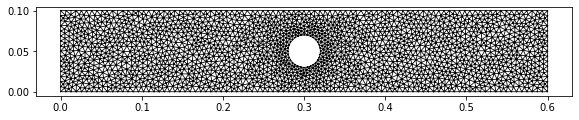

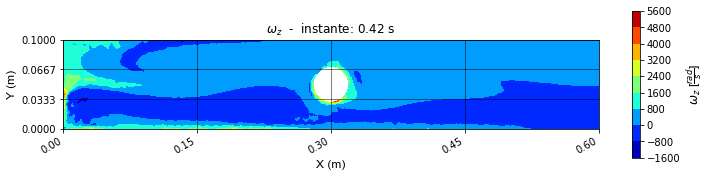

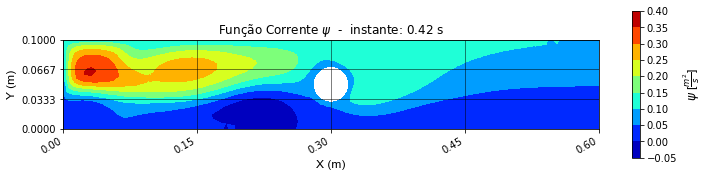

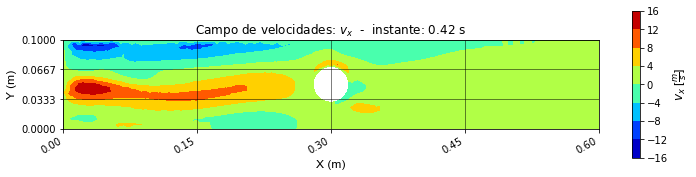

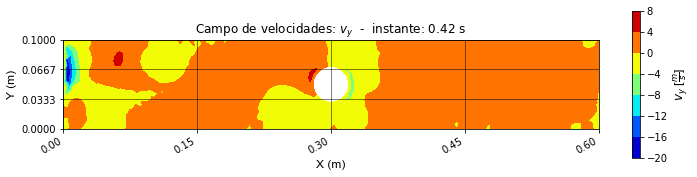

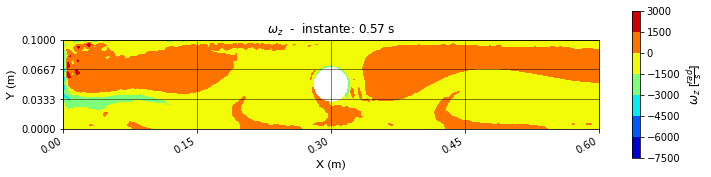

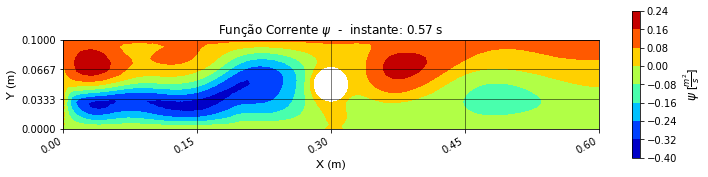

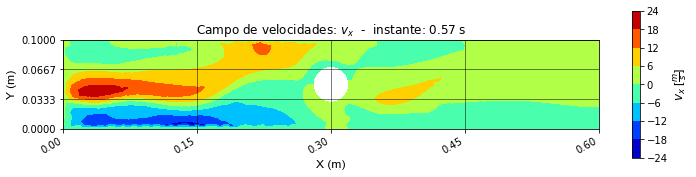

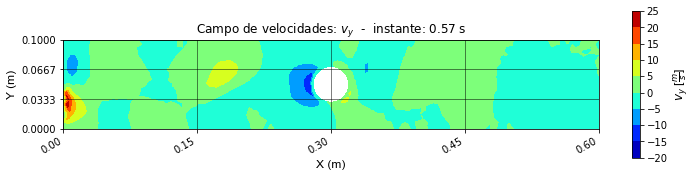

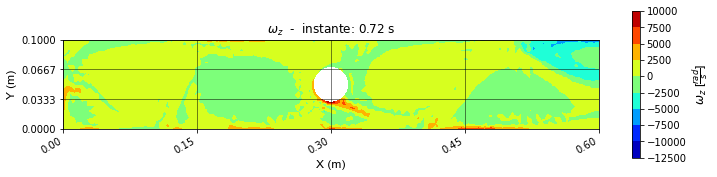

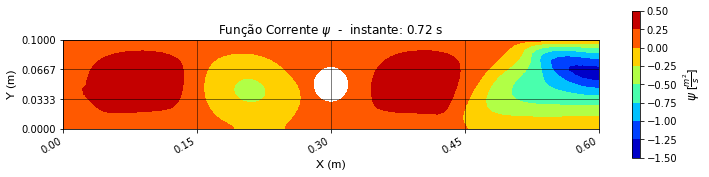

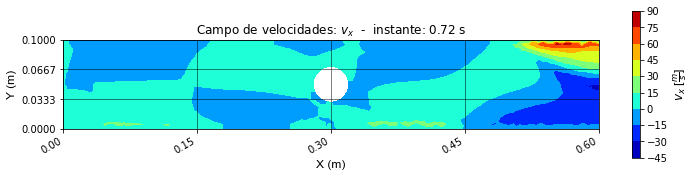

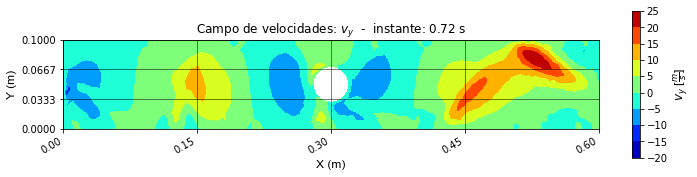

In [ ]:
#--------------------------------------------------
# Fonte dos gráficos
matplot_font = {'fontname': 'Arial',
                'color':  'black',
                'weight': 'normal',
                'size': 12,
                }

# Plotando malha

fig, ax = plt.subplots(figsize = (9.6,2.4))

triang = mtri.Triangulation(X,Y,IEN)
ax.set_aspect('equal')
ax.triplot(triang,'k-', linewidth=0.8)

# Plotando gráficos

for t in range(0,nt,int(nt/4)):
#for t in range(0,20,5):
    tempo = t*dt

    ## Vorticidade
    fig, ax0 = plt.subplots(figsize = (12,3))
 
    triang = mtri.Triangulation(X,Y,IEN)
    ax0.set_aspect('equal')
    ax0.tricontourf(triang,CampoVort[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax0.tricontourf(triang,CampoVort[:,t],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\omega_z$ [$\\frac{rad}{s}$]',fontdict=matplot_font)
    plt.title("$\omega_z$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()
    
    ## PSI
    fig, ax1 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax1.set_aspect('equal')
    ax1.tricontourf(triang,CampoPSI[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax1.tricontourf(triang,CampoPSI[:,t],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\psi$ [$\\frac{m^2}{s}$]',fontdict=matplot_font)
    plt.title("Função Corrente $\psi$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vx
    fig, ax2 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax2.set_aspect('equal')
    ax2.tricontourf(triang,CampoVx[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax2.tricontourf(triang,CampoVx[:,t],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_x$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_x$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vy
    fig, ax3 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax3.set_aspect('equal')
    ax3.tricontourf(triang,CampoVy[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax3.tricontourf(triang,CampoVy[:,t],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_y$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_y$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    plt.show()

### Domínio: canal com 3 obstáculos (malha via Gmsh e gerando .vtk)

In [ ]:
# Criando diretório para armazenar solução

#Specify the folder in which results will be exported (mostly graphs)
workingDir = r"C:\Users\João Pedro\Downloads\ElementosFinitos"   #Notebook pessoal
#workingDir = r"C:\Users\jferreira\Downloads\ElementosFinitos"   #TechnipFMC
fileName = "Solucao_canal_3obstaculos_(0.10x0.60)_0.001_nu_0.01_dt_0.15_vxcc"
outputPath = workingDir + "\\" + fileName

if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    print("Directory " , outputPath ,  " has been created ")
else:
    print("Directory " , outputPath ,  " already exists")

# Propriedades do fluido e domínio:

nu = 0.001

to = 0
tf = 6
dt = 0.01
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
mshname = 'Cilindros_3_refined.msh'
msh = meshio.read('./' + mshname)
print(msh)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 9)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]
####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'Admissao':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'Exaustao':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro1':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro2':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro3':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'CCInferior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'CCSuperior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'CCInferior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'CCSuperior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 1.0
 if ccName[i] == 'Admissao':
  vxcc[i] = 0.15
  vycc[i] = 0.0
  PSIcc[i] = Y[i]
 if ccName[i] == 'cilindro1' or ccName[i] == 'cilindro2' or ccName[i] == 'cilindro3':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.5

# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 kelem = (1/(4*area))*kxelem + (1/(4*area))*kyelem

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                               [1.0,2.0,1.0],
                               [1.0,1.0,2.0]])

 gxelem = (1/6)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]


# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
PSI = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vx[i] = vxcc[i]
 vy[i] = vycc[i]

# Vorticidade nos contornos no instante inicial
vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))
vort = vort_cc.copy()


# Gravando condições de contorno e iniciais da solução em .vtk
point_data = {'PSIcc' : PSIcc}
data_vxcc = {'vxcc' : vxcc}
data_vycc = {'vycc' : vycc}
data_vort_cc = {'vort_cc' : vort_cc}
point_data.update(data_vxcc)
point_data.update(data_vycc)
point_data.update(data_vort_cc)
meshio.write_points_cells(outputPath +'\\'+'condicaoDeContorno.vtk',
                           msh.points, 
                           msh.cells,
                           point_data=point_data,
                           )


CampoVort = np.empty((npoints,nt))
CampoPSI = np.empty((npoints,nt))
CampoVx = np.empty((npoints,nt))
CampoVy = np.empty((npoints,nt))


# Avanço no tempo
for n in range(0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'CCSuperior' or \
         ccName[i] == 'CCInferior' or \
         ccName[i] == 'cilindro1' or \
         ccName[i] == 'cilindro2' or \
         ccName[i] == 'cilindro3' or \
         ccName[i] == 'Admissao':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 vort = np.linalg.solve(A,b)

 CampoVort[:,n] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
     if ccName[i] == 'CCSuperior' or \
         ccName[i] == 'CCInferior' or \
         ccName[i] == 'cilindro1' or \
         ccName[i] == 'cilindro2' or \
         ccName[i] == 'cilindro3' or \
         ccName[i] == 'Admissao':
         
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 PSI = np.linalg.solve(Apsi,bpsi)

 CampoPSI[:,n] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 vx = np.linalg.solve(M,Gy@PSI)
 vy = np.linalg.solve(M,-Gx@PSI)
 
 
 for i in IENbound:
     if ccName[i] == 'CCSuperior' or \
         ccName[i] == 'CCInferior' or \
         ccName[i] == 'cilindro1' or \
         ccName[i] == 'cilindro2' or \
         ccName[i] == 'cilindro3' or \
         ccName[i] == 'Admissao':
         vx[i] = vxcc[i]
         vy[i] = vycc[i]

 CampoVx[:,n] = vx
 CampoVy[:,n] = vy


 # Gravando solução em .vtk
 print ("... gravando em VTK passo de tempo: " + str(n))
 
 point_data = {'psi' : PSI}
 data_vx = {'vx' : vx}
 data_vy = {'vy' : vy}
 data_vort = {'$\omega_z$' : vort}
 point_data.update(data_vx)
 point_data.update(data_vy)
 point_data.update(data_vort)
 meshio.write_points_cells(outputPath +'\\'+'solucao-'+str(n)+'.vtk',
                            msh.points, 
                            msh.cells,
                            point_data=point_data,
                            )
 

#### Reiniciar simulação

Estabelecendo instante inicial:

In [ ]:
n0 = n
print('Instante inicial: '+str(n0))

vortRestart = CampoVort[:,n-1]
PSIRestart = CampoPSI[:,n-1]
vxRestart = CampoVx[:,n-1]
vyRestart = CampoVy[:,n-1]

11


In [ ]:
# Criando diretório para armazenar solução

# Specify the folder in which results will be exported (mostly graphs)
#workingDir = r"C:\Users\João Pedro\Downloads\ElementosFinitos"   #Notebook pessoal
workingDir = r"C:\Users\jferreira\Downloads\ElementosFinitos"   #TechnipFMC
fileName = "Solucao_canal_3obstaculos_(0.10x0.60)_0.001_nu_0.01_dt_0.15_vxcc"
outputPath = workingDir + "\\" + fileName

if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    print("Directory " , outputPath ,  " has been created ")
else:
    print("Directory " , outputPath ,  " already exists")

# Propriedades do fluido e domínio:

nu = 0.001

to = 0
tf = 6
dt = 0.01
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
mshname = 'Cilindros_3_refined.msh'
msh = meshio.read('./' + mshname)
print(msh)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 9)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]
####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'Admissao':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'Exaustao':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro1':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro2':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro3':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'CCInferior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'CCSuperior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'CCInferior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'CCSuperior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 1.0
 if ccName[i] == 'Admissao':
  vxcc[i] = 0.15
  vycc[i] = 0.0
  PSIcc[i] = Y[i]
 if ccName[i] == 'cilindro1' or ccName[i] == 'cilindro2' or ccName[i] == 'cilindro3':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.5


# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 kelem = (1/(4*area))*kxelem + (1/(4*area))*kyelem

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                               [1.0,2.0,1.0],
                               [1.0,1.0,2.0]])

 gxelem = (1/6)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]


# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)
vx = vxRestart
vy = vyRestart
PSI = PSIRestart

# Vorticidade nos contornos no instante inicial
vort = vortRestart


CampoVort = np.empty((npoints,nt-n0))
CampoPSI = np.empty((npoints,nt-n0))
CampoVx = np.empty((npoints,nt-n0))
CampoVy = np.empty((npoints,nt-n0))


# Avanço no tempo
for n in range(n0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'CCSuperior' or \
         ccName[i] == 'CCInferior' or \
         ccName[i] == 'cilindro1' or \
         ccName[i] == 'cilindro2' or \
         ccName[i] == 'cilindro3' or \
         ccName[i] == 'Admissao':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 vort = np.linalg.solve(A,b)

 CampoVort[:,n-n0] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
     if ccName[i] == 'CCSuperior' or \
         ccName[i] == 'CCInferior' or \
         ccName[i] == 'cilindro1' or \
         ccName[i] == 'cilindro2' or \
         ccName[i] == 'cilindro3' or \
         ccName[i] == 'Admissao':
         
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 PSI = np.linalg.solve(Apsi,bpsi)

 CampoPSI[:,n-n0] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 vx = np.linalg.solve(M,Gy@PSI)
 vy = np.linalg.solve(M,-Gx@PSI)
 
 
 for i in IENbound:
     if ccName[i] == 'CCSuperior' or \
         ccName[i] == 'CCInferior' or \
         ccName[i] == 'cilindro1' or \
         ccName[i] == 'cilindro2' or \
         ccName[i] == 'cilindro3' or \
         ccName[i] == 'Admissao':
         vx[i] = vxcc[i]
         vy[i] = vycc[i]

 CampoVx[:,n-n0] = vx
 CampoVy[:,n-n0] = vy


# Gravando solução em .vtk
 print ("... gravando em VTK passo de tempo: " + str(n))
 point_data = {'psi' : PSI}
 data_vx = {'vx' : vx}
 data_vy = {'vy' : vy}
 data_vort = {'omega_z' : vort}
 point_data.update(data_vx)
 point_data.update(data_vy)
 point_data.update(data_vort)
 meshio.write_points_cells(outputPath +'\\'+'solucao-'+str(n)+'.vtk',
                           msh.points, 
                           msh.cells,
                           point_data=point_data,
                           )

### Domínio: meio poroso local

#### Galerkin

In [ ]:
# Criando diretório para armazenar solução

# Specify the folder in which results will be exported (mostly graphs)
#workingDir = r"C:\Users\João Pedro\Downloads\ElementosFinitos"   #Notebook pessoal
workingDir = r"C:\Users\jferreira\Downloads\ElementosFinitos"   #TechnipFMC
fileName = "Sol_DPF_Local_(1.12e-3x1.44e-3)_5x4_obstaculos_3.2e-5&1.2e-5_mesh_24k_elem_1.6e-4_D_0.5e-8_nu_0.005_dt_0.001_vycc_16_Re"
outputPath = workingDir + "\\" + fileName

if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    print("Directory " , outputPath ,  " has been created ")
else:
    print("Directory " , outputPath ,  " already exists")

# Propriedades do fluido e domínio:

nu = 0.5*10**(-8)
uy = 0.001
to = 0.0
tf = 2.0
dt = 0.005
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
mshname = 'DPF_Local_(1.12e-3x1.44e-3)_5x4_obstaculos_3.2e-5&1.2e-5_mesh_24k_elem_1.6e-4_D.msh'
msh = meshio.read('./' + mshname)
print(msh)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]
####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'esquerda':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'direita':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'inferior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'superior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo1':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo2':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo3':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo4':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo5':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'inferior':
  vxcc[i] = 0.0
  vycc[i] = uy
  PSIcc[i] = -uy*X[i]
 if ccName[i] == 'esquerda':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -uy*0
 if ccName[i] == 'direita':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -uy*0.00144
 if ccName[i] == 'obstaculo1':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -uy*0.00024
 if ccName[i] == 'obstaculo2':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -uy*0.00048
 if ccName[i] == 'obstaculo3':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -uy*0.00072
 if ccName[i] == 'obstaculo4':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -uy*0.00096
 if ccName[i] == 'obstaculo5':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -uy*0.00120

# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)    (Agora antes da inicialização das matrizes, pois Kest usa a média das velocidades de cada elemento)
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
PSI = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vx[i] = vxcc[i]
 vy[i] = vycc[i]


# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.empty( (npoints,npoints),dtype='float' )
M = np.empty( (npoints,npoints),dtype='float' )
Gx = np.empty( (npoints,npoints),dtype='float' )
Gy = np.empty( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 
 kelem = (1/(4*area))*kxelem + (1/(4*area))*kyelem 

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                               [1.0,2.0,1.0],
                               [1.0,1.0,2.0]])

 gxelem = (1/6)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]
   

# Vorticidade nos contornos no instante inicial
cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
vort_cc = sp.sparse.linalg.spsolve(cscM,(Gx@vy - Gy@vx))
vort = vort_cc.copy()

# Gravando condições de contorno e iniciais da solução em .vtk
point_data = {'PSIcc' : PSIcc}
data_vxcc = {'vxcc' : vxcc}
data_vycc = {'vycc' : vycc}
data_vort_cc = {'vort_cc' : vort_cc}
point_data.update(data_vxcc)
point_data.update(data_vycc)
point_data.update(data_vort_cc)
meshio.write_points_cells(outputPath +'\\'+'condicaoDeContorno.vtk',
                           msh.points, 
                           msh.cells,
                           point_data=point_data,
                           )


CampoVort = np.empty((npoints,nt))
CampoPSI = np.empty((npoints,nt))
CampoVx = np.empty((npoints,nt))
CampoVy = np.empty((npoints,nt))


# Avanço no tempo
for n in range(0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
 vort_cc = sp.sparse.linalg.spsolve(cscM,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'inferior' or \
        ccName[i] == 'direita' or \
        ccName[i] == 'esquerda' or \
        ccName[i] == 'obstaculo1' or \
        ccName[i] == 'obstaculo2' or \
        ccName[i] == 'obstaculo3' or \
        ccName[i] == 'obstaculo4' or \
        ccName[i] == 'obstaculo5':
         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 cscA = sp.sparse.csc_matrix(A)   # Matrix form that improves sparse.linalg.solve
 vort = sp.sparse.linalg.spsolve(cscA,b)

 CampoVort[:,n] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
     if ccName[i] == 'inferior' or \
        ccName[i] == 'direita' or \
        ccName[i] == 'esquerda' or \
        ccName[i] == 'obstaculo1' or \
        ccName[i] == 'obstaculo2' or \
        ccName[i] == 'obstaculo3' or \
        ccName[i] == 'obstaculo4' or \
        ccName[i] == 'obstaculo5':
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 cscApsi = sp.sparse.csc_matrix(Apsi)   # Matrix form that improves sparse.linalg.solve
 PSI = sp.sparse.linalg.spsolve(cscApsi,bpsi)

 CampoPSI[:,n] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
 vx = sp.sparse.linalg.spsolve(cscM,Gy@PSI)
 vy = sp.sparse.linalg.spsolve(cscM,-Gx@PSI)
 
 for i in IENbound:
     if ccName[i] == 'inferior' or \
        ccName[i] == 'direita' or \
        ccName[i] == 'esquerda' or \
        ccName[i] == 'obstaculo1' or \
        ccName[i] == 'obstaculo2' or \
        ccName[i] == 'obstaculo3' or \
        ccName[i] == 'obstaculo4' or \
        ccName[i] == 'obstaculo5':
         vx[i] = vxcc[i]
         vy[i] = vycc[i]

 CampoVx[:,n] = vx
 CampoVy[:,n] = vy


 # Gravando solução em .vtk
 print ("... gravando em VTK passo de tempo: " + str(n))
 point_data = {'psi' : PSI}
 data_vx = {'vx' : vx}
 data_vy = {'vy' : vy}
 data_vort = {'omega_z' : vort}
 point_data.update(data_vx)
 point_data.update(data_vy)
 point_data.update(data_vort)
 meshio.write_points_cells(outputPath +'\\'+'solucao-'+str(n)+'.vtk',
                            msh.points, 
                            msh.cells,
                            point_data=point_data,
                            )

#### Reiniciar Simulação

Estabelecendo instante inicial:

In [9]:
n0 = n
print('Instante inicial: '+str(n0))

vortRestart = CampoVort[:,n-1]
PSIRestart = CampoPSI[:,n-1]
vxRestart = CampoVx[:,n-1]
vyRestart = CampoVy[:,n-1]

Instante inicial: 6


In [10]:
# Criando diretório para armazenar solução

# Specify the folder in which results will be exported (mostly graphs)
#workingDir = r"C:\Users\João Pedro\Downloads\ElementosFinitos"   #Notebook pessoal
workingDir = r"C:\Users\jferreira\Downloads\ElementosFinitos"   #TechnipFMC
fileName = "Sol_DPF_Local_(1.12e-3x1.44e-3)_5x4_obstaculos_3.2e-5&1.2e-5_mesh_24k_elem_1.6e-4_D_0.5e-8_nu_0.005_dt_0.001_vycc_16_Re"
outputPath = workingDir + "\\" + fileName

if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    print("Directory " , outputPath ,  " has been created ")
else:
    print("Directory " , outputPath ,  " already exists")

# Propriedades do fluido e domínio:

nu = 0.5*10**(-8)
uy = 0.001
to = 0.0
tf = 2.0
dt = 0.005
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
mshname = 'DPF_Local_(1.12e-3x1.44e-3)_5x4_obstaculos_3.2e-5&1.2e-5_mesh_24k_elem_1.6e-4_D.msh'
msh = meshio.read('./' + mshname)
print(msh)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]
####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'esquerda':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'direita':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'inferior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'superior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo1':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo2':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo3':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo4':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo5':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'inferior':
  vxcc[i] = 0.0
  vycc[i] = uy
  PSIcc[i] = -uy*X[i]
 if ccName[i] == 'esquerda':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -uy*0
 if ccName[i] == 'direita':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -uy*0.00144
 if ccName[i] == 'obstaculo1':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -uy*0.00024
 if ccName[i] == 'obstaculo2':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -uy*0.00048
 if ccName[i] == 'obstaculo3':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -uy*0.00072
 if ccName[i] == 'obstaculo4':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -uy*0.00096
 if ccName[i] == 'obstaculo5':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -uy*0.00120

# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)    (Agora antes da inicialização das matrizes, pois Kest usa a média das velocidades de cada elemento)
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
PSI = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vx[i] = vxcc[i]
 vy[i] = vycc[i]


# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.empty( (npoints,npoints),dtype='float' )
M = np.empty( (npoints,npoints),dtype='float' )
Gx = np.empty( (npoints,npoints),dtype='float' )
Gy = np.empty( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 
 kelem = (1/(4*area))*kxelem + (1/(4*area))*kyelem 

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                               [1.0,2.0,1.0],
                               [1.0,1.0,2.0]])

 gxelem = (1/6)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]
   

# Vorticidade nos contornos no instante inicial
cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
vort_cc = sp.sparse.linalg.spsolve(cscM,(Gx@vy - Gy@vx))
vort = vort_cc.copy()

# Gravando condições de contorno e iniciais da solução em .vtk
point_data = {'PSIcc' : PSIcc}
data_vxcc = {'vxcc' : vxcc}
data_vycc = {'vycc' : vycc}
data_vort_cc = {'vort_cc' : vort_cc}
point_data.update(data_vxcc)
point_data.update(data_vycc)
point_data.update(data_vort_cc)
meshio.write_points_cells(outputPath +'\\'+'condicaoDeContorno.vtk',
                           msh.points, 
                           msh.cells,
                           point_data=point_data,
                           )

CampoVort = np.empty((npoints,nt-n0))
CampoPSI = np.empty((npoints,nt-n0))
CampoVx = np.empty((npoints,nt-n0))
CampoVy = np.empty((npoints,nt-n0))


# Avanço no tempo
for n in range(n0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
 vort_cc = sp.sparse.linalg.spsolve(cscM,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'inferior' or \
        ccName[i] == 'direita' or \
        ccName[i] == 'esquerda' or \
        ccName[i] == 'obstaculo1' or \
        ccName[i] == 'obstaculo2' or \
        ccName[i] == 'obstaculo3' or \
        ccName[i] == 'obstaculo4' or \
        ccName[i] == 'obstaculo5':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 cscA = sp.sparse.csc_matrix(A)   # Matrix form that improves sparse.linalg.solve
 vort = sp.sparse.linalg.spsolve(cscA,b)

 CampoVort[:,n-n0] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
     if ccName[i] == 'inferior' or \
        ccName[i] == 'direita' or \
        ccName[i] == 'esquerda' or \
        ccName[i] == 'obstaculo1' or \
        ccName[i] == 'obstaculo2' or \
        ccName[i] == 'obstaculo3' or \
        ccName[i] == 'obstaculo4' or \
        ccName[i] == 'obstaculo5':
         
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 cscApsi = sp.sparse.csc_matrix(Apsi)   # Matrix form that improves sparse.linalg.solve
 PSI = sp.sparse.linalg.spsolve(cscApsi,bpsi)

 CampoPSI[:,n-n0] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
 vx = sp.sparse.linalg.spsolve(cscM,Gy@PSI)
 vy = sp.sparse.linalg.spsolve(cscM,-Gx@PSI)
 
 for i in IENbound:
     if ccName[i] == 'inferior' or \
        ccName[i] == 'direita' or \
        ccName[i] == 'esquerda' or \
        ccName[i] == 'obstaculo1' or \
        ccName[i] == 'obstaculo2' or \
        ccName[i] == 'obstaculo3' or \
        ccName[i] == 'obstaculo4' or \
        ccName[i] == 'obstaculo5':
         vx[i] = vxcc[i]
         vy[i] = vycc[i]

 CampoVx[:,n-n0] = vx
 CampoVy[:,n-n0] = vy


 # Gravando solução em .vtk
 print ("... gravando em VTK passo de tempo: " + str(n))
 point_data = {'psi' : PSI}
 data_vx = {'vx' : vx}
 data_vy = {'vy' : vy}
 data_vort = {'omega_z' : vort}
 point_data.update(data_vx)
 point_data.update(data_vy)
 point_data.update(data_vort)
 meshio.write_points_cells(outputPath +'\\'+'solucao-'+str(n)+'.vtk',
                            msh.points, 
                            msh.cells,
                            point_data=point_data,
                            )

Directory  C:\Users\jferreira\Downloads\ElementosFinitos\Sol_DPF_Local_(1.12e-3x1.44e-3)_5x4_obstaculos_3.2e-5&1.2e-5_mesh_24k_elem_1.6e-4_D_0.5e-8_nu_0.005_dt_0.001_vycc_16_Re  already exists

<meshio mesh object>
  Number of points: 12900
  Number of cells:
    line: 1409
    triangle: 24429
  Cell data: gmsh:physical, gmsh:geometrical
  Field data: inferior, superior, esquerda, direita, obstaculo1, obstaculo2, obstaculo3, obstaculo4, obstaculo5, surface
... gravando em VTK passo de tempo: 6
... gravando em VTK passo de tempo: 7
... gravando em VTK passo de tempo: 8
... gravando em VTK passo de tempo: 9
... gravando em VTK passo de tempo: 10
... gravando em VTK passo de tempo: 11
... gravando em VTK passo de tempo: 12
... gravando em VTK passo de tempo: 13
... gravando em VTK passo de tempo: 14
... gravando em VTK passo de tempo: 15
... gravando em VTK passo de tempo: 16
... gravando em VTK passo de tempo: 17
... gravando em VTK passo de tempo: 18
... gravando em VTK passo de tempo: 

KeyboardInterrupt: 

#### Plotagem

C:\Users\jferreira\AppData\Local\Temp\ipykernel_29332\660827415.py:28: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax0.tricontourf(triang,CampoVort[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_29332\660827415.py:47: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax1.tricontourf(triang,CampoPSI[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_29332\660827415.py:66: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax2.tricontourf(triang,CampoVx[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_29332\660827415.py:85: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax3.tricontourf(triang,CampoVy[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)


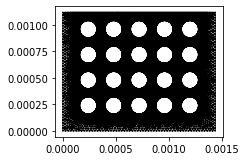

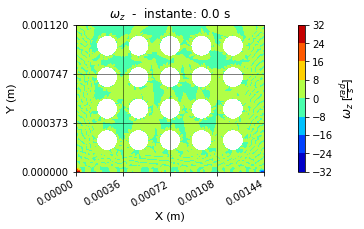

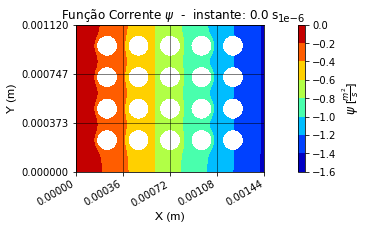

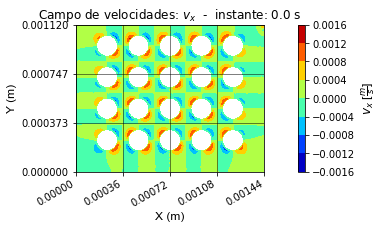

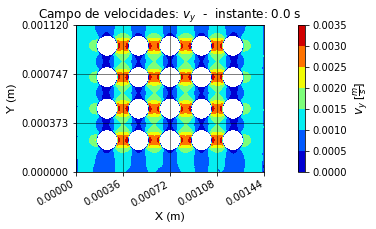

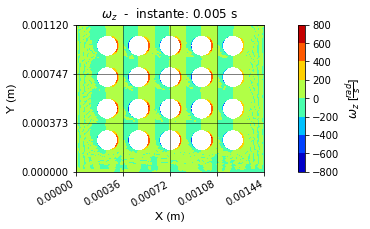

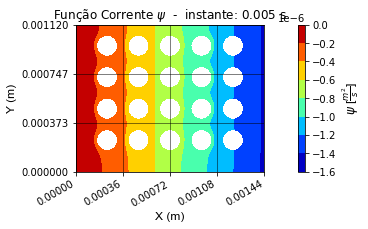

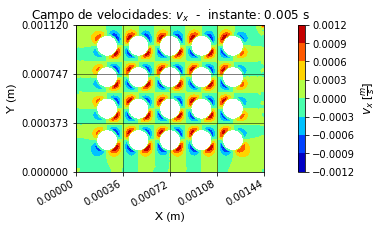

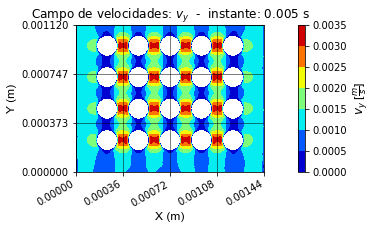

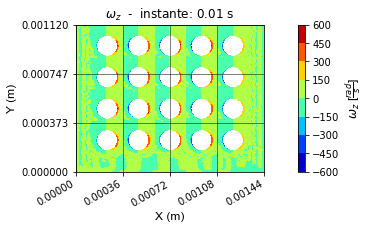

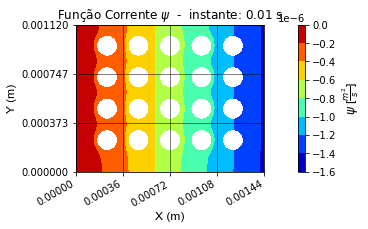

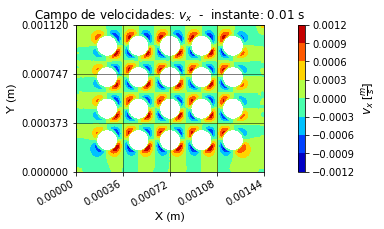

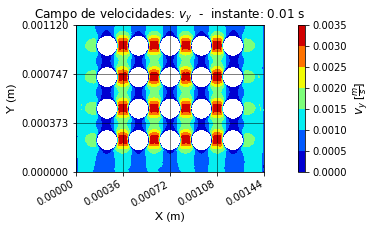

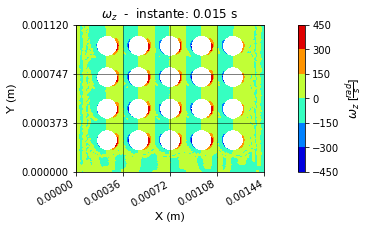

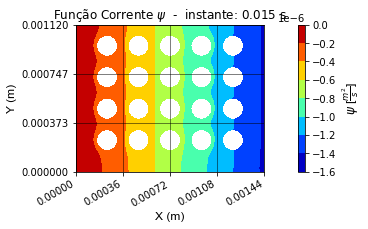

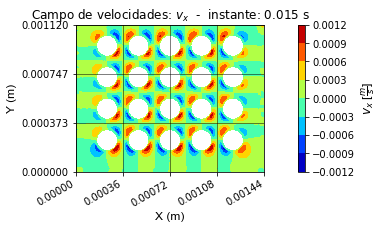

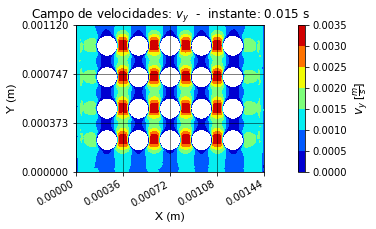

In [8]:
#--------------------------------------------------
# Fonte dos gráficos
matplot_font = {'fontname': 'Arial',
                'color':  'black',
                'weight': 'normal',
                'size': 12,
                }

# Plotando malha

fig, ax = plt.subplots(figsize = (9.6,2.4))

triang = mtri.Triangulation(X,Y,IEN)
ax.set_aspect('equal')
ax.triplot(triang,'k-', linewidth=0.8)

# Plotando gráficos

#for t in range(0,nt,int(nt/3)):
for t in range(0,4):
    tempo = t*dt

    ## Vorticidade
    fig, ax0 = plt.subplots(figsize = (12,3))
 
    triang = mtri.Triangulation(X,Y,IEN)
    ax0.set_aspect('equal')
    ax0.tricontourf(triang,CampoVort[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax0.tricontourf(triang,CampoVort[:,t],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\omega_z$ [$\\frac{rad}{s}$]',fontdict=matplot_font)
    plt.title("$\omega_z$  -  instante: "+ str(round(tempo,3))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()
    
    ## PSI
    fig, ax1 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax1.set_aspect('equal')
    ax1.tricontourf(triang,CampoPSI[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax1.tricontourf(triang,CampoPSI[:,t],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\psi$ [$\\frac{m^2}{s}$]',fontdict=matplot_font)
    plt.title("Função Corrente $\psi$  -  instante: "+ str(round(tempo,3))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vx
    fig, ax2 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax2.set_aspect('equal')
    ax2.tricontourf(triang,CampoVx[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax2.tricontourf(triang,CampoVx[:,t],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_x$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_x$  -  instante: "+ str(round(tempo,3))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vy
    fig, ax3 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax3.set_aspect('equal')
    ax3.tricontourf(triang,CampoVy[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax3.tricontourf(triang,CampoVy[:,t],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_y$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_y$  -  instante: "+ str(round(tempo,3))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    plt.show()

### Domínio: meio poroso global

#### Galerkin

In [4]:
# Criando diretório para armazenar solução

# Specify the folder in which results will be exported (mostly graphs)
#workingDir = r"C:\Users\João Pedro\Downloads\ElementosFinitos"   #Notebook pessoal
workingDir = r"C:\Users\jferreira\Downloads\ElementosFinitos"   #TechnipFMC
fileName = "Sol_DPF_(0.17e-3x0.325e-3)_filtro_0.255e-3_canal_4x8_obstaculos_9.1e-6&2.6e-6_mesh_36k_elem_2.6e-5_D_10e-5_nu_0.005_dt_20.0_vxcc_26_Re_NovoPSI"
outputPath = workingDir + "\\" + fileName

if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    print("Directory " , outputPath ,  " has been created ")
else:
    print("Directory " , outputPath ,  " already exists")

# Propriedades do fluido e domínio:

nu = 1.0*10**(-5)
ux = 20.0
to = 0.0
tf = 2.0
dt = 0.005
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
mshname = 'DPF_(0.17e-3x0.325e-3)_filtro_0.255e-3_canal_4x8_obstaculos_9.1e-6&2.6e-6_mesh_36k_elem_2.6e-5_D.msh'
msh = meshio.read('./' + mshname)
print(msh)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]
####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'admissao - esquerda':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'admissao - direita':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'admissao - lado inferior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'admissao - lado superior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'filtro - esquerda':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'filtro - direita':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo1':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo2':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo3':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo4':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo5':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo6':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo7':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo8':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'exaustao - esquerda':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'exaustao - direita':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'exaustao - lado inferior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'exaustao - lado superior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'admissao - lado inferior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'admissao - lado superior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = ux*0.000255
 if ccName[i] == 'admissao - esquerda':
  vxcc[i] = ux
  vycc[i] = 0.0
  PSIcc[i] = ux*(Y[i] + 0.000255)   #A origem da malha não esta na quina do canal, mas na quina do filtro
 if ccName[i] == 'admissao - direita':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'filtro - esquerda':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0 + ux*(0.000255)
 if ccName[i] == 'filtro - direita':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000325 + ux*(0.000255)
 if ccName[i] == 'obstaculo1':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000036 + ux*(0.000255)
 if ccName[i] == 'obstaculo2':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000072 + ux*(0.000255)
 if ccName[i] == 'obstaculo3':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000108 + ux*(0.000255)
 if ccName[i] == 'obstaculo4':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000144 + ux*(0.000255)
 if ccName[i] == 'obstaculo5':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000180 + ux*(0.000255)
 if ccName[i] == 'obstaculo6':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000217 + ux*(0.000255)
 if ccName[i] == 'obstaculo7':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000253 + ux*(0.000255)
 if ccName[i] == 'obstaculo8':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000289 + ux*(0.000255)
 if ccName[i] == 'exaustao - lado inferior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'exaustao - lado superior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = ux*0.000255
 if ccName[i] == 'exaustao - esquerda':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = ux*0.000255

# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)    (Agora antes da inicialização das matrizes, pois Kest usa a média das velocidades de cada elemento)
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
PSI = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vx[i] = vxcc[i]
 vy[i] = vycc[i]


# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.empty( (npoints,npoints),dtype='float' )
M = np.empty( (npoints,npoints),dtype='float' )
Gx = np.empty( (npoints,npoints),dtype='float' )
Gy = np.empty( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 
 kelem = (1/(4*area))*kxelem + (1/(4*area))*kyelem 

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                               [1.0,2.0,1.0],
                               [1.0,1.0,2.0]])

 gxelem = (1/6)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]
   

# Vorticidade nos contornos no instante inicial
cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
vort_cc = sp.sparse.linalg.spsolve(cscM,(Gx@vy - Gy@vx))
vort = vort_cc.copy()

# Gravando condições de contorno e iniciais da solução em .vtk
point_data = {'PSIcc' : PSIcc}
data_vxcc = {'vxcc' : vxcc}
data_vycc = {'vycc' : vycc}
data_vort_cc = {'vort_cc' : vort_cc}
point_data.update(data_vxcc)
point_data.update(data_vycc)
point_data.update(data_vort_cc)
meshio.write_points_cells(outputPath +'\\'+'condicaoDeContorno.vtk',
                           msh.points, 
                           msh.cells,
                           point_data=point_data,
                           )


CampoVort = np.empty((npoints,nt))
CampoPSI = np.empty((npoints,nt))
CampoVx = np.empty((npoints,nt))
CampoVy = np.empty((npoints,nt))


# Avanço no tempo
for n in range(0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
 vort_cc = sp.sparse.linalg.spsolve(cscM,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'admissao - lado inferior' or \
        ccName[i] == 'admissao - lado superior' or \
        ccName[i] == 'admissao - direita' or \
        ccName[i] == 'admissao - esquerda' or \
        ccName[i] == 'filtro - direita' or \
        ccName[i] == 'filtro - esquerda' or \
        ccName[i] == 'obstaculo1' or \
        ccName[i] == 'obstaculo2' or \
        ccName[i] == 'obstaculo3' or \
        ccName[i] == 'obstaculo4' or \
        ccName[i] == 'obstaculo5' or \
        ccName[i] == 'obstaculo6' or \
        ccName[i] == 'obstaculo7' or \
        ccName[i] == 'obstaculo8' or \
        ccName[i] == 'exaustao - lado inferior' or \
        ccName[i] == 'exaustao - lado superior' or \
        ccName[i] == 'exaustao - esquerda':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 cscA = sp.sparse.csc_matrix(A)   # Matrix form that improves sparse.linalg.solve
 vort = sp.sparse.linalg.spsolve(cscA,b)

 CampoVort[:,n] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
     if ccName[i] == 'admissao - lado inferior' or \
        ccName[i] == 'admissao - lado superior' or \
        ccName[i] == 'admissao - direita' or \
        ccName[i] == 'admissao - esquerda' or \
        ccName[i] == 'filtro - direita' or \
        ccName[i] == 'filtro - esquerda' or \
        ccName[i] == 'obstaculo1' or \
        ccName[i] == 'obstaculo2' or \
        ccName[i] == 'obstaculo3' or \
        ccName[i] == 'obstaculo4' or \
        ccName[i] == 'obstaculo5' or \
        ccName[i] == 'obstaculo6' or \
        ccName[i] == 'obstaculo7' or \
        ccName[i] == 'obstaculo8' or \
        ccName[i] == 'exaustao - lado inferior' or \
        ccName[i] == 'exaustao - lado superior' or \
        ccName[i] == 'exaustao - esquerda':
         
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 cscApsi = sp.sparse.csc_matrix(Apsi)   # Matrix form that improves sparse.linalg.solve
 PSI = sp.sparse.linalg.spsolve(cscApsi,bpsi)

 CampoPSI[:,n] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
 vx = sp.sparse.linalg.spsolve(cscM,Gy@PSI)
 vy = sp.sparse.linalg.spsolve(cscM,-Gx@PSI)
 
 for i in IENbound:
     if ccName[i] == 'admissao - lado inferior' or \
        ccName[i] == 'admissao - lado superior' or \
        ccName[i] == 'admissao - direita' or \
        ccName[i] == 'admissao - esquerda' or \
        ccName[i] == 'filtro - direita' or \
        ccName[i] == 'filtro - esquerda' or \
        ccName[i] == 'obstaculo1' or \
        ccName[i] == 'obstaculo2' or \
        ccName[i] == 'obstaculo3' or \
        ccName[i] == 'obstaculo4' or \
        ccName[i] == 'obstaculo5' or \
        ccName[i] == 'obstaculo6' or \
        ccName[i] == 'obstaculo7' or \
        ccName[i] == 'obstaculo8' or \
        ccName[i] == 'exaustao - lado inferior' or \
        ccName[i] == 'exaustao - lado superior' or \
        ccName[i] == 'exaustao - esquerda':
         vx[i] = vxcc[i]
         vy[i] = vycc[i]

 CampoVx[:,n] = vx
 CampoVy[:,n] = vy


 # Gravando solução em .vtk
 print ("... gravando em VTK passo de tempo: " + str(n))
 point_data = {'psi' : PSI}
 data_vx = {'vx' : vx}
 data_vy = {'vy' : vy}
 data_vort = {'omega_z' : vort}
 point_data.update(data_vx)
 point_data.update(data_vy)
 point_data.update(data_vort)
 meshio.write_points_cells(outputPath +'\\'+'solucao-'+str(n)+'.vtk',
                            msh.points, 
                            msh.cells,
                            point_data=point_data,
                            )

Directory  C:\Users\jferreira\Downloads\ElementosFinitos\Sol_DPF_(0.17e-3x0.325e-3)_filtro_0.255e-3_canal_4x8_obstaculos_9.1e-6&2.6e-6_mesh_36k_elem_2.6e-5_D_10e-5_nu_0.005_dt_20.0_vxcc_26_Re_NovoPSI  has been created 

<meshio mesh object>
  Number of points: 19002
  Number of cells:
    line: 1760
    triangle: 36306
  Cell data: gmsh:physical, gmsh:geometrical
  Field data: admissao - lado inferior, admissao - lado superior, admissao - esquerda, admissao - direita, exaustao - lado inferior, exaustao - lado superior, exaustao - esquerda, exaustao - direita, obstaculo1, obstaculo2, obstaculo3, obstaculo4, obstaculo5, obstaculo6, obstaculo7, obstaculo8, filtro - esquerda, filtro - direita, admissao, exaustao, filtro
... gravando em VTK passo de tempo: 0
... gravando em VTK passo de tempo: 1
... gravando em VTK passo de tempo: 2
... gravando em VTK passo de tempo: 3
... gravando em VTK passo de tempo: 4
... gravando em VTK passo de tempo: 5
... gravando em VTK passo de tempo: 6
... grav

KeyboardInterrupt: 

#### Characteristic Galerkin (Estabilização)

In [4]:
mshname = 'meioPoroso_(0.011x0.0115)_5x4_obstaculos_0.0005&0.0001_mesh_16k_elem_0.001_D_vertical.msh'
msh = meshio.read('./' + mshname)
print(msh)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
print(msh.cell_data['gmsh:physical'][0])
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
#print(IENboundTypeElem)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]


<meshio mesh object>
  Number of points: 8620
  Number of cells:
    line: 993
    triangle: 16285
  Cell data: gmsh:physical, gmsh:geometrical
  Field data: inferior, superior, esquerda, direita, obstaculo1, obstaculo2, obstaculo3, obstaculo4, surface
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 

In [4]:
# Criando diretório para armazenar solução

# Specify the folder in which results will be exported (mostly graphs)
workingDir = r"C:\Users\João Pedro\Downloads\ElementosFinitos"   #Notebook pessoal
#workingDir = r"C:\Users\jferreira\Downloads\ElementosFinitos"   #TechnipFMC
fileName = "Sol_meioPoroso_0.011x0.0115_5x4_obstaculos_0.0005&0.0001_mesh_16k_elem_0.001_D_vertical_2.5e-7_nu_0.005_dt_0.01_vxcc_20_Re_ESTAB"
outputPath = workingDir + "\\" + fileName

if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    print("Directory " , outputPath ,  " has been created ")
else:
    print("Directory " , outputPath ,  " already exists")

# Propriedades do fluido e domínio:

nu = 0.00000025

to = 0.0
tf = 3.0
dt = 0.005
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
#mshname = 'canal.msh'
mshname = 'meioPoroso_(0.011x0.0115)_5x4_obstaculos_0.0005&0.0001_mesh_16k_elem_0.001_D_vertical.msh'
msh = meshio.read('./' + mshname)
print(msh)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]
####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'esquerda':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'direita':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'obstaculo1':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo2':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo3':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo4':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo5':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'inferior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'superior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'inferior':
  vxcc[i] = 0.0
  vycc[i] = 0.01
  PSIcc[i] = -0.01*X[i]
 if ccName[i] == 'esquerda':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'direita':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -0.000115
 if ccName[i] == 'obstaculo1':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -0.000023
 if ccName[i] == 'obstaculo2':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -0.000046
 if ccName[i] == 'obstaculo3':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -0.000069
 if ccName[i] == 'obstaculo4':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = -0.000092

# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)    (Agora antes da inicialização das matrizes, pois Kest usa a média das velocidades de cada elemento)
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
PSI = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vx[i] = vxcc[i]
 vy[i] = vycc[i]


# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (npoints,npoints),dtype='float' )
Kest = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 
 kelem = (1/(4*area))*kxelem + (1/(4*area))*kyelem 

 kxy_elem = np.array([[b1*c1,b1*c2,b1*c3],
                      [b2*c1,b2*c2,b2*c3],
                      [b3*c1,b3*c2,b3*c3]])
 kyx_elem = np.array([[c1*b1,c1*b2,c1*b3],
                      [c2*b1,c2*b2,c2*b3],
                      [c3*b1,c3*b2,c3*b3]])
 Vxm = (vx[v1]+vx[v2]+vx[v3])/3.0
 Vym = (vy[v1]+vy[v2]+vy[v3])/3.0

 kelem_est = (Vxm*(dt/2)/(4*area))*(Vxm*kxelem + Vym*kxy_elem) + (Vym*(dt/2)/(4*area))*(Vxm*kyx_elem + Vym*kyelem)

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                               [1.0,2.0,1.0],
                               [1.0,1.0,2.0]])

 gxelem = (1/6)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   Kest[iglobal,jglobal] += kelem_est[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]


# Vorticidade nos contornos no instante inicial
cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
vort_cc = sp.sparse.linalg.spsolve(cscM,(Gx@vy - Gy@vx))
vort = vort_cc.copy()


# Gravando condições de contorno e iniciais da solução em .vtk
point_data = {'PSIcc' : PSIcc}
data_vxcc = {'vxcc' : vxcc}
data_vycc = {'vycc' : vycc}
data_vort_cc = {'vort_cc' : vort_cc}
point_data.update(data_vxcc)
point_data.update(data_vycc)
point_data.update(data_vort_cc)
meshio.write_points_cells(outputPath +'\\'+'condicaoDeContorno.vtk',
                           msh.points, 
                           msh.cells,
                           point_data=point_data,
                           )


CampoVort = np.empty((npoints,nt))
CampoPSI = np.empty((npoints,nt))
CampoVx = np.empty((npoints,nt))
CampoVy = np.empty((npoints,nt))


# Avanço no tempo
for n in range(0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
 vort_cc = sp.sparse.linalg.spsolve(cscM,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Atualizando matriz de estabilização a cada step
 Kest = np.zeros( (npoints,npoints),dtype='float' )

 for e in range(0,ne):
   v1,v2,v3 = IEN[e]

   Vxm = (vx[v1]+vx[v2]+vx[v3])/3.0
   Vym = (vy[v1]+vy[v2]+vy[v3])/3.0

   kelem_est = (Vxm*(dt/2)/(4*area))*(Vxm*kxelem + Vym*kxy_elem) + (Vym*(dt/2)/(4*area))*(Vxm*kyx_elem + Vym*kyelem)

   for ilocal in range(0,3):
     iglobal = IEN[e,ilocal]
     for jlocal in range(0,3):
       jglobal = IEN[e,jlocal]

       Kest[iglobal,jglobal] += kelem_est[ilocal,jlocal]

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + Kest + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'inferior' or \
        ccName[i] == 'obstaculo1' or \
        ccName[i] == 'obstaculo2' or \
        ccName[i] == 'obstaculo3' or \
        ccName[i] == 'obstaculo4' or \
        ccName[i] == 'direita' or \
        ccName[i] == 'esquerda':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 cscA = sp.sparse.csc_matrix(A)   # Matrix form that improves sparse.linalg.solve
 vort = sp.sparse.linalg.spsolve(cscA,b)

 CampoVort[:,n] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
     if ccName[i] == 'inferior' or \
        ccName[i] == 'obstaculo1' or \
        ccName[i] == 'obstaculo2' or \
        ccName[i] == 'obstaculo3' or \
        ccName[i] == 'obstaculo4' or \
        ccName[i] == 'direita' or \
        ccName[i] == 'esquerda':
         
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 cscApsi = sp.sparse.csc_matrix(Apsi)   # Matrix form that improves sparse.linalg.solve
 PSI = sp.sparse.linalg.spsolve(cscApsi,bpsi)

 CampoPSI[:,n] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
 vx = sp.sparse.linalg.spsolve(cscM,Gy@PSI)
 vy = sp.sparse.linalg.spsolve(cscM,-Gx@PSI)
 
 for i in IENbound:
     if ccName[i] == 'inferior' or \
        ccName[i] == 'obstaculo1' or \
        ccName[i] == 'obstaculo2' or \
        ccName[i] == 'obstaculo3' or \
        ccName[i] == 'obstaculo4' or \
        ccName[i] == 'direita' or \
        ccName[i] == 'esquerda':
         vx[i] = vxcc[i]
         vy[i] = vycc[i]

 CampoVx[:,n] = vx
 CampoVy[:,n] = vy


 # Gravando solução em .vtk
 print ("... gravando em VTK passo de tempo: " + str(n))
 point_data = {'psi' : PSI}
 data_vx = {'vx' : vx}
 data_vy = {'vy' : vy}
 data_vort = {'omega_z' : vort}
 point_data.update(data_vx)
 point_data.update(data_vy)
 point_data.update(data_vort)
 meshio.write_points_cells(outputPath +'\\'+'solucao-'+str(n)+'.vtk',
                            msh.points, 
                            msh.cells,
                            point_data=point_data,
                            )

Directory  C:\Users\João Pedro\Downloads\ElementosFinitos\Sol_meioPoroso_0.011x0.0115_5x4_obstaculos_0.0005&0.0001_mesh_16k_elem_0.001_D_vertical_2.5e-7_nu_0.005_dt_0.01_vxcc_20_Re_ESTAB  already exists

<meshio mesh object>
  Number of points: 8620
  Number of cells:
    line: 993
    triangle: 16285
  Cell data: gmsh:physical, gmsh:geometrical
  Field data: inferior, superior, esquerda, direita, obstaculo1, obstaculo2, obstaculo3, obstaculo4, surface
... gravando em VTK passo de tempo: 0
... gravando em VTK passo de tempo: 1
... gravando em VTK passo de tempo: 2
... gravando em VTK passo de tempo: 3
... gravando em VTK passo de tempo: 4
... gravando em VTK passo de tempo: 5
... gravando em VTK passo de tempo: 6
... gravando em VTK passo de tempo: 7
... gravando em VTK passo de tempo: 8
... gravando em VTK passo de tempo: 9
... gravando em VTK passo de tempo: 10


KeyboardInterrupt: 

#### Reiniciar simulação (Sem estabilização)

Estabelecendo instante inicial:

In [ ]:
n0 = n
print('Instante inicial: '+str(n0))

vortRestart = CampoVort[:,n-1]
PSIRestart = CampoPSI[:,n-1]
vxRestart = CampoVx[:,n-1]
vyRestart = CampoVy[:,n-1]

In [ ]:
# Criando diretório para armazenar solução

# Specify the folder in which results will be exported (mostly graphs)
#workingDir = r"C:\Users\João Pedro\Downloads\ElementosFinitos"   #Notebook pessoal
workingDir = r"C:\Users\jferreira\Downloads\ElementosFinitos"   #TechnipFMC
fileName = "Sol_DPF_(0.17e-3x.0325e-3)_filtro_0.255e-3_canal_4x8_obstaculos_1.95e-5&0.26e-5_mesh_38k_elem_2.6e-5_D_10e-5_nu_0.005_dt_0.1_vxcc_0.13_Re_NovoPSI"
outputPath = workingDir + "\\" + fileName

if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    print("Directory " , outputPath ,  " has been created ")
else:
    print("Directory " , outputPath ,  " already exists")

# Propriedades do fluido e domínio:

nu = 0.00001
ux = 0.1
to = 0.0
tf = 2.0
dt = 0.005
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
mshname = 'DPF_(0.17e-3x0.0325e-3)_filtro_0.255e-3_canal_4x8_obstaculos_1.95e-5&0.26e-5_mesh_38k_elem_2.6e-5_D.msh'
msh = meshio.read('./' + mshname)
print(msh)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]
####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'admissao - esquerda':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'admissao - direita':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'admissao - lado inferior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'admissao - lado superior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'filtro - esquerda':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'filtro - direita':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo1':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo2':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo3':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo4':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo5':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo6':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo7':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'obstaculo8':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'exaustao - esquerda':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'exaustao - direita':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'exaustao - lado inferior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
 if IENboundElem[elem] == 'exaustao - lado superior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'admissao - lado inferior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'admissao - lado superior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = ux*0.000255
 if ccName[i] == 'admissao - esquerda':
  vxcc[i] = ux
  vycc[i] = 0.0
  PSIcc[i] = ux*Y[i]
 if ccName[i] == 'admissao - direita':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'filtro - esquerda':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0 + ux*(0.000255)
 if ccName[i] == 'filtro - direita':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000325 + ux*(0.000255)
 if ccName[i] == 'obstaculo1':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000036 + ux*(0.000255)
 if ccName[i] == 'obstaculo2':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000072 + ux*(0.000255)
 if ccName[i] == 'obstaculo3':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000108 + ux*(0.000255)
 if ccName[i] == 'obstaculo4':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000144 + ux*(0.000255)
 if ccName[i] == 'obstaculo5':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000180 + ux*(0.000255)
 if ccName[i] == 'obstaculo6':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000217 + ux*(0.000255)
 if ccName[i] == 'obstaculo7':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000253 + ux*(0.000255)
 if ccName[i] == 'obstaculo8':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (-ux*0.000255/0.0000325)*0.0000289 + ux*(0.000255)
 if ccName[i] == 'exaustao - lado inferior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'exaustao - lado superior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = ux*0.000255
 if ccName[i] == 'exaustao - esquerda':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = ux*Y[i]

# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)    (Agora antes da inicialização das matrizes, pois Kest usa a média das velocidades de cada elemento)
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
PSI = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vx[i] = vxcc[i]
 vy[i] = vycc[i]


# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.empty( (npoints,npoints),dtype='float' )
M = np.empty( (npoints,npoints),dtype='float' )
Gx = np.empty( (npoints,npoints),dtype='float' )
Gy = np.empty( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 
 kelem = (1/(4*area))*kxelem + (1/(4*area))*kyelem 

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                               [1.0,2.0,1.0],
                               [1.0,1.0,2.0]])

 gxelem = (1/6)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]
   

# Vorticidade nos contornos no instante inicial
cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
vort_cc = sp.sparse.linalg.spsolve(cscM,(Gx@vy - Gy@vx))
vort = vort_cc.copy()

# Gravando condições de contorno e iniciais da solução em .vtk
point_data = {'PSIcc' : PSIcc}
data_vxcc = {'vxcc' : vxcc}
data_vycc = {'vycc' : vycc}
data_vort_cc = {'vort_cc' : vort_cc}
point_data.update(data_vxcc)
point_data.update(data_vycc)
point_data.update(data_vort_cc)
meshio.write_points_cells(outputPath +'\\'+'condicaoDeContorno.vtk',
                           msh.points, 
                           msh.cells,
                           point_data=point_data,
                           )


CampoVort = np.empty((npoints,nt-n0))
CampoPSI = np.empty((npoints,nt-n0))
CampoVx = np.empty((npoints,nt-n0))
CampoVy = np.empty((npoints,nt-n0))


# Avanço no tempo
for n in range(n0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
 vort_cc = sp.sparse.linalg.spsolve(cscM,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'admissao - lado inferior' or \
        ccName[i] == 'admissao - lado superior' or \
        ccName[i] == 'admissao - direita' or \
        ccName[i] == 'admissao - esquerda' or \
        ccName[i] == 'filtro - direita' or \
        ccName[i] == 'filtro - esquerda' or \
        ccName[i] == 'obstaculo1' or \
        ccName[i] == 'obstaculo2' or \
        ccName[i] == 'obstaculo3' or \
        ccName[i] == 'obstaculo4' or \
        ccName[i] == 'obstaculo5' or \
        ccName[i] == 'obstaculo6' or \
        ccName[i] == 'obstaculo7' or \
        ccName[i] == 'obstaculo8' or \
        ccName[i] == 'exaustao - lado inferior' or \
        ccName[i] == 'exaustao - lado superior' or \
        ccName[i] == 'exaustao - esquerda':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 cscA = sp.sparse.csc_matrix(A)   # Matrix form that improves sparse.linalg.solve
 vort = sp.sparse.linalg.spsolve(cscA,b)

 CampoVort[:,n-n0] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
     if ccName[i] == 'admissao - lado inferior' or \
        ccName[i] == 'admissao - lado superior' or \
        ccName[i] == 'admissao - direita' or \
        ccName[i] == 'admissao - esquerda' or \
        ccName[i] == 'filtro - direita' or \
        ccName[i] == 'filtro - esquerda' or \
        ccName[i] == 'obstaculo1' or \
        ccName[i] == 'obstaculo2' or \
        ccName[i] == 'obstaculo3' or \
        ccName[i] == 'obstaculo4' or \
        ccName[i] == 'obstaculo5' or \
        ccName[i] == 'obstaculo6' or \
        ccName[i] == 'obstaculo7' or \
        ccName[i] == 'obstaculo8' or \
        ccName[i] == 'exaustao - lado inferior' or \
        ccName[i] == 'exaustao - lado superior' or \
        ccName[i] == 'exaustao - esquerda':
         
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 cscApsi = sp.sparse.csc_matrix(Apsi)   # Matrix form that improves sparse.linalg.solve
 PSI = sp.sparse.linalg.spsolve(cscApsi,bpsi)

 CampoPSI[:,n-n0] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 cscM = sp.sparse.csc_matrix(M)   # Matrix form that improves sparse.linalg.solve
 vx = sp.sparse.linalg.spsolve(cscM,Gy@PSI)
 vy = sp.sparse.linalg.spsolve(cscM,-Gx@PSI)
 
 for i in IENbound:
     if ccName[i] == 'admissao - lado inferior' or \
        ccName[i] == 'admissao - lado superior' or \
        ccName[i] == 'admissao - direita' or \
        ccName[i] == 'admissao - esquerda' or \
        ccName[i] == 'filtro - direita' or \
        ccName[i] == 'filtro - esquerda' or \
        ccName[i] == 'obstaculo1' or \
        ccName[i] == 'obstaculo2' or \
        ccName[i] == 'obstaculo3' or \
        ccName[i] == 'obstaculo4' or \
        ccName[i] == 'obstaculo5' or \
        ccName[i] == 'obstaculo6' or \
        ccName[i] == 'obstaculo7' or \
        ccName[i] == 'obstaculo8' or \
        ccName[i] == 'exaustao - lado inferior' or \
        ccName[i] == 'exaustao - lado superior' or \
        ccName[i] == 'exaustao - esquerda':
         vx[i] = vxcc[i]
         vy[i] = vycc[i]

 CampoVx[:,n-n0] = vx
 CampoVy[:,n-n0] = vy


 # Gravando solução em .vtk
 print ("... gravando em VTK passo de tempo: " + str(n))
 point_data = {'psi' : PSI}
 data_vx = {'vx' : vx}
 data_vy = {'vy' : vy}
 data_vort = {'omega_z' : vort}
 point_data.update(data_vx)
 point_data.update(data_vy)
 point_data.update(data_vort)
 meshio.write_points_cells(outputPath +'\\'+'solucao-'+str(n)+'.vtk',
                            msh.points, 
                            msh.cells,
                            point_data=point_data,
                            )

#### Plotagem

C:\Users\jferreira\AppData\Local\Temp\ipykernel_10744\660827415.py:28: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax0.tricontourf(triang,CampoVort[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_10744\660827415.py:47: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax1.tricontourf(triang,CampoPSI[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_10744\660827415.py:66: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax2.tricontourf(triang,CampoVx[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_10744\660827415.py:85: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax3.tricontourf(triang,CampoVy[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)


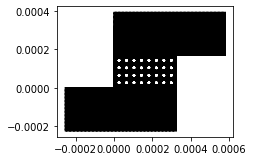

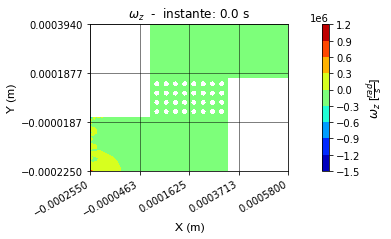

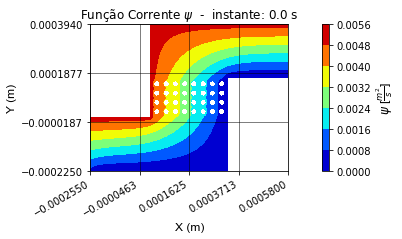

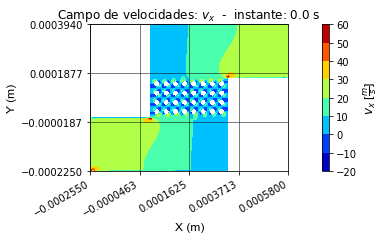

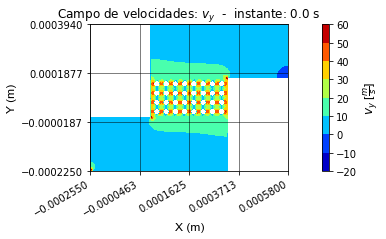

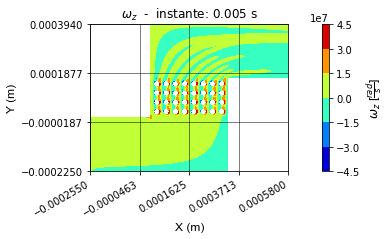

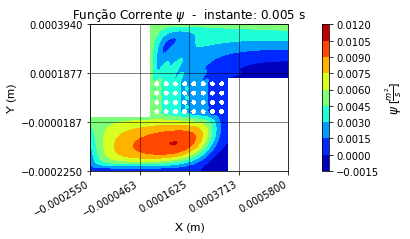

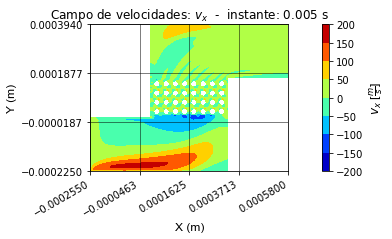

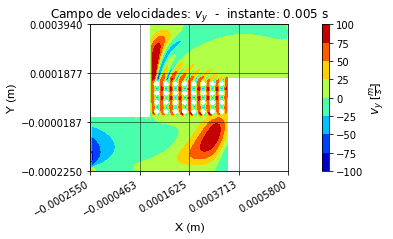

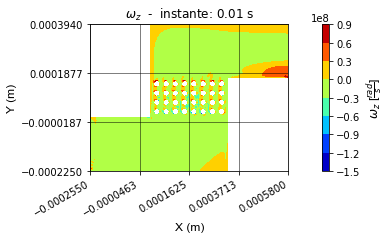

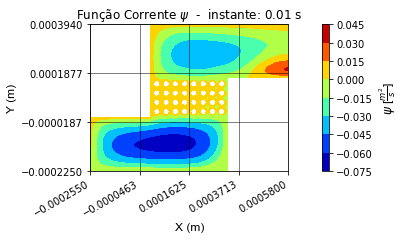

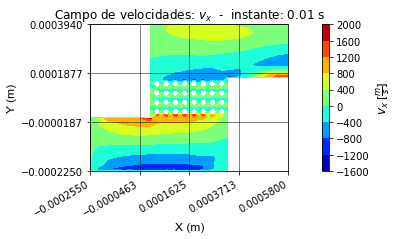

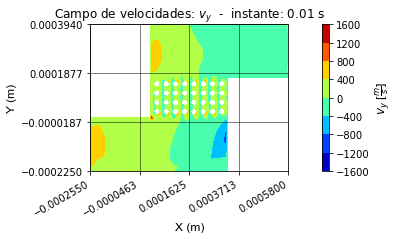

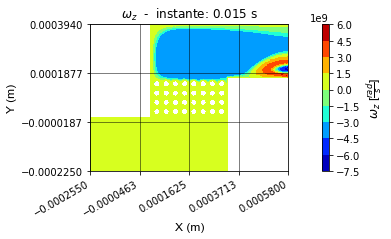

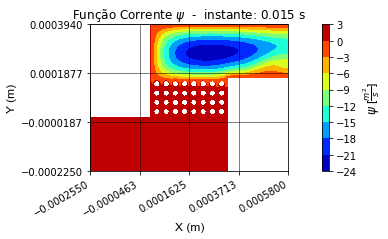

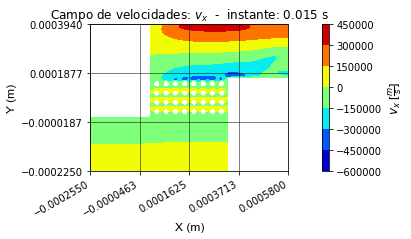

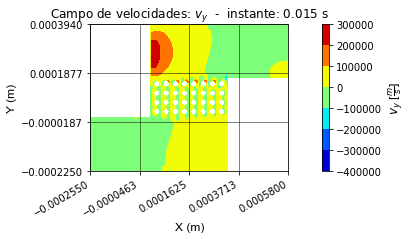

In [5]:
#--------------------------------------------------
# Fonte dos gráficos
matplot_font = {'fontname': 'Arial',
                'color':  'black',
                'weight': 'normal',
                'size': 12,
                }

# Plotando malha

fig, ax = plt.subplots(figsize = (9.6,2.4))

triang = mtri.Triangulation(X,Y,IEN)
ax.set_aspect('equal')
ax.triplot(triang,'k-', linewidth=0.8)

# Plotando gráficos

#for t in range(0,nt,int(nt/3)):
for t in range(0,4):
    tempo = t*dt

    ## Vorticidade
    fig, ax0 = plt.subplots(figsize = (12,3))
 
    triang = mtri.Triangulation(X,Y,IEN)
    ax0.set_aspect('equal')
    ax0.tricontourf(triang,CampoVort[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax0.tricontourf(triang,CampoVort[:,t],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\omega_z$ [$\\frac{rad}{s}$]',fontdict=matplot_font)
    plt.title("$\omega_z$  -  instante: "+ str(round(tempo,3))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()
    
    ## PSI
    fig, ax1 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax1.set_aspect('equal')
    ax1.tricontourf(triang,CampoPSI[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax1.tricontourf(triang,CampoPSI[:,t],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\psi$ [$\\frac{m^2}{s}$]',fontdict=matplot_font)
    plt.title("Função Corrente $\psi$  -  instante: "+ str(round(tempo,3))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vx
    fig, ax2 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax2.set_aspect('equal')
    ax2.tricontourf(triang,CampoVx[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax2.tricontourf(triang,CampoVx[:,t],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_x$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_x$  -  instante: "+ str(round(tempo,3))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vy
    fig, ax3 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax3.set_aspect('equal')
    ax3.tricontourf(triang,CampoVy[:,t], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax3.tricontourf(triang,CampoVy[:,t],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_y$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_y$  -  instante: "+ str(round(tempo,3))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    plt.show()

### Domínio: canal com 1 obstáculo (malha via Gmsh e triângulos mini). Resolução: integrando para obter matrizes de interpolação

In [ ]:
# MATRIZ DE VISCOSIDADE ###############################################################################################

K11 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K12 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K13 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K14 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]


K21 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K22 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K23 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K24 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]


K31 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K32 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K33 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K34 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]


K41 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K42 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K43 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K44 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]                                      


# MATRIZ DE MASSA ###############################################################################################

M11 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M12 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M13 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M14 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)

M21 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M22 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M23 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M24 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)

M31 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M32 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M33 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M34 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)

M41 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M42 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M43 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M44 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)                                    


# MATRIZ DO GRADIENTE ###############################################################################################

Gx11 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx12 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx13 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx14 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gx21 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx22 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx23 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx24 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gx31 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx32 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx33 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx34 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gx41 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx42 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx43 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx44 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gy11 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy12 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy13 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy14 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gy21 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy22 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy23 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy24 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gy31 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy32 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy33 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy34 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gy41 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy42 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy43 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy44 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)

# Criando diretório para armazenar solução

# Specify the folder in which results will be exported (mostly graphs)
workingDir = r"C:\Users\João Pedro\Downloads\ElementosFinitos"
fileName = "Solucao_cilindro_ordem2_1266"
outputPath = workingDir + "\\" + fileName

if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    print("Directory " , outputPath ,  " has been created ")
else:
    print("Directory " , outputPath ,  " already exists")

# Propriedades do fluido e domínio:

nu = 0.01

to = 0
tf = 10
dt = 0.05
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
#mshname = 'canal.msh'
mshname = 'cilindro_ordem2_1266.msh'
msh = meshio.read('./' + mshname)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]

####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]
# prioridade 4
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'inlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 3
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'outlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 2
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeInf':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 1
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeSup':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'paredeInf':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'paredeSup':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 1.0
 if ccName[i] == 'inlet':
  vxcc[i] = 1.0
  vycc[i] = 0.0
  PSIcc[i] = Y[i]
 if ccName[i] == 'cilindro':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.5

# Inicialização das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )

## Função de integração a ser usada
def INTEGRACAO_2D_2(f,e):

  v1,v2,v3,v4 = IEN[e]
  '''
  # Calcula a área do triângulo
  A = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                         [1.0,X[v2],Y[v2]],
                         [1.0,X[v3],Y[v3]]])

  return sp.integrate.dblquad(f,X[v1],X[v3],lambda x: (Y[v2]-Y[v1])/(X[v2]-X[v1])*x + (Y[v1]*X[v2]-Y[v2]*X[v1]),
                                            lambda x: (Y[v3]-Y[v1])/(X[v3]-X[v1])*x + (Y[v1]*X[v3]-Y[v3]*X[v1]), 
                                            (X[v1],X[v3],X[v5],Y[v1],Y[v3],Y[v5],A))[0] + \
         sp.integrate.dblquad(f,X[v3],X[v2],lambda x: (Y[v2]-Y[v1])/(X[v2]-X[v1])*x + (Y[v1]*X[v2]-Y[v2]*X[v1]),
                                            lambda x: (Y[v2]-Y[v3])/(X[v2]-X[v3])*x + (Y[v3]*X[v2]-Y[v2]*X[v3]), 
                                            (X[v1],X[v3],X[v5],Y[v1],Y[v3],Y[v5],A))[0]
  '''
## Integrando e montando
for e in range(0,ne):

  Ke = np.array([[INTEGRACAO_2D_2(K11,e),INTEGRACAO_2D_2(K12,e),INTEGRACAO_2D_2(K13,e),INTEGRACAO_2D_2(K14,e)],
                 [INTEGRACAO_2D_2(K21,e),INTEGRACAO_2D_2(K22,e),INTEGRACAO_2D_2(K23,e),INTEGRACAO_2D_2(K24,e)],
                 [INTEGRACAO_2D_2(K31,e),INTEGRACAO_2D_2(K32,e),INTEGRACAO_2D_2(K33,e),INTEGRACAO_2D_2(K34,e)],
                 [INTEGRACAO_2D_2(K41,e),INTEGRACAO_2D_2(K42,e),INTEGRACAO_2D_2(K43,e),INTEGRACAO_2D_2(K44,e)]])

  Me = np.array([[INTEGRACAO_2D_2(M11,e),INTEGRACAO_2D_2(M12,e),INTEGRACAO_2D_2(M13,e),INTEGRACAO_2D_2(M14,e)],
                 [INTEGRACAO_2D_2(M21,e),INTEGRACAO_2D_2(M22,e),INTEGRACAO_2D_2(M23,e),INTEGRACAO_2D_2(M24,e)],
                 [INTEGRACAO_2D_2(M31,e),INTEGRACAO_2D_2(M32,e),INTEGRACAO_2D_2(M33,e),INTEGRACAO_2D_2(M34,e)],
                 [INTEGRACAO_2D_2(M41,e),INTEGRACAO_2D_2(M42,e),INTEGRACAO_2D_2(M43,e),INTEGRACAO_2D_2(M44,e)]])

  Gxe = np.array([[INTEGRACAO_2D_2(Gx11,e),INTEGRACAO_2D_2(Gx12,e),INTEGRACAO_2D_2(Gx13,e),INTEGRACAO_2D_2(Gx14,e)],
                  [INTEGRACAO_2D_2(Gx21,e),INTEGRACAO_2D_2(Gx22,e),INTEGRACAO_2D_2(Gx23,e),INTEGRACAO_2D_2(Gx24,e)],
                  [INTEGRACAO_2D_2(Gx31,e),INTEGRACAO_2D_2(Gx32,e),INTEGRACAO_2D_2(Gx33,e),INTEGRACAO_2D_2(Gx34,e)],
                  [INTEGRACAO_2D_2(Gx41,e),INTEGRACAO_2D_2(Gx42,e),INTEGRACAO_2D_2(Gx43,e),INTEGRACAO_2D_2(Gx44,e)]])

  Gye = np.array([[INTEGRACAO_2D_2(Gy11,e),INTEGRACAO_2D_2(Gy12,e),INTEGRACAO_2D_2(Gy13,e),INTEGRACAO_2D_2(Gy14,e)],
                  [INTEGRACAO_2D_2(Gy21,e),INTEGRACAO_2D_2(Gy22,e),INTEGRACAO_2D_2(Gy23,e),INTEGRACAO_2D_2(Gy24,e)],
                  [INTEGRACAO_2D_2(Gy31,e),INTEGRACAO_2D_2(Gy32,e),INTEGRACAO_2D_2(Gy33,e),INTEGRACAO_2D_2(Gy34,e)],
                  [INTEGRACAO_2D_2(Gy41,e),INTEGRACAO_2D_2(Gy42,e),INTEGRACAO_2D_2(Gy43,e),INTEGRACAO_2D_2(Gy44,e)]])

  for ilocal in range(0,4):
     iglobal = IEN[e,ilocal]
     for jlocal in range(0,4):
        jglobal = IEN[e,jlocal]

        K[iglobal,jglobal] += Ke[ilocal,jlocal]
        M[iglobal,jglobal] += Me[ilocal,jlocal]
        Gx[iglobal,jglobal] += Gxe[ilocal,jlocal]
        Gy[iglobal,jglobal] += Gye[ilocal,jlocal]


# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
PSI = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vx[i] = vxcc[i]
 vy[i] = vycc[i]

# Vorticidade nos contornos no instante inicial
vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))
vort = vort_cc.copy()

CampoVort = np.empty((npoints,nt))
CampoPSI = np.empty((npoints,nt))
CampoVx = np.empty((npoints,nt))
CampoVy = np.empty((npoints,nt))


# Avanço no tempo
for n in range(0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'paredeSup' or \
         ccName[i] == 'paredeInf' or \
         ccName[i] == 'cilindro' or \
         ccName[i] == 'inlet':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 vort = np.linalg.solve(A,b)

 CampoVort[:,n] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
    if ccName[i] == 'paredeSup' or \
       ccName[i] == 'paredeInf' or \
       ccName[i] == 'cilindro' or \
       ccName[i] == 'inlet':
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 PSI = np.linalg.solve(Apsi,bpsi)

 CampoPSI[:,n] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 vx = np.linalg.solve(M,Gy@PSI)
 vy = np.linalg.solve(M,-Gx@PSI)
 
 
 for i in IENbound:
  if ccName[i] == 'paredeSup' or \
     ccName[i] == 'paredeInf' or \
     ccName[i] == 'cilindro' or \
     ccName[i] == 'inlet':
     vx[i] = vxcc[i]
     vy[i] = vycc[i]

 CampoVx[:,n] = vx
 CampoVy[:,n] = vy
 

 # Gravando solução em .vtk
 print ("... instantes passados: " + str(n))
 point_data = {'psi' : PSI}
 data_vx = {'vx' : vx}
 data_vy = {'vy' : vy}
 data_vort = {'$\omega_z$' : vort}
 point_data.update(data_vx)
 point_data.update(data_vy)
 point_data.update(data_vort)
 meshio.write_points_cells(outputPath +'\\'+'solucao-'+str(n)+'.vtk',
                            msh.points, 
                            msh.cells,
                            point_data=point_data,
                            )


### Domínio: canal com 1 obstáculo (malha via Gmsh e triângulos de 2ª ordem). Resolução: integrando para obter matrizes de interpolação

In [ ]:
# MATRIZ DE VISCOSIDADE ###############################################################################################

K11 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K12 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K13 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K14 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K15 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K16 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K21 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K22 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K23 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K24 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K25 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K26 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K31 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K32 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K33 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K34 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K35 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K36 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K41 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K42 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K43 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K44 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K45 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K46 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]                                       

K51 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K52 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K53 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K54 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K55 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K56 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K61 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K62 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K63 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K64 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K65 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

K66 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1] + \
                                       B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]*B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[2]

# MATRIZ DE MASSA ###############################################################################################

M11 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M12 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M13 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M14 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M15 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M16 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

M21 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M22 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M23 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M24 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M25 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M26 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

M31 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M32 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M33 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M34 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M35 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M36 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

M41 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M42 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M43 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M44 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M45 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M46 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)                                      

M51 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M52 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M53 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M54 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M55 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M56 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

M61 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M62 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M63 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M64 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M65 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
M66 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

# MATRIZ DO GRADIENTE ###############################################################################################

Gx11 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx12 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx13 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx14 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx15 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx16 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gx21 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx22 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx23 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx24 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx25 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx26 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gx31 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx32 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx33 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx34 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx35 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx36 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gx41 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx42 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx43 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx44 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx45 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx46 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gx51 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx52 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx53 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx54 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx55 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx56 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gx61 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx62 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx63 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx64 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx65 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gx66 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[0]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gy11 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy12 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy13 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy14 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy15 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy16 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gy21 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy22 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy23 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy24 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy25 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy26 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gy31 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy32 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy33 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy34 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy35 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy36 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gy41 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy42 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy43 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy44 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy45 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy46 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gy51 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy52 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy53 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy54 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy55 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy56 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)

Gy61 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_21(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy62 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_22(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy63 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_23(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy64 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_24(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy65 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_25(x,y,X1,X2,X3,Y1,Y2,Y3,A)
Gy66 = lambda x,y,X1,X2,X3,Y1,Y2,Y3,A : B2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)[1]*N2D_26(x,y,X1,X2,X3,Y1,Y2,Y3,A)


# Criando diretório para armazenar solução

# Specify the folder in which results will be exported (mostly graphs)
#workingDir = r"C:\Users\João Pedro\Downloads\ElementosFinitos"   #Notebook pessoal
workingDir = r"C:\Users\jferreira\Downloads\ElementosFinitos"   #TechnipFMC
fileName = "Solucao_cilindro_ordem2_1266_0.01_nu_0.03_0.15_vxcc"
outputPath = workingDir + "\\" + fileName

if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    print("Directory " , outputPath ,  " has been created ")
else:
    print("Directory " , outputPath ,  " already exists")

# Propriedades do fluido e domínio:

nu = 0.01

to = 0
tf = 6
dt = 0.03
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
mshname = 'cilindro_ordem2_1266.msh'
msh = meshio.read('./' + mshname)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]

####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]
# prioridade 4
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'inlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 3
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'outlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 2
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeInf':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 1
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeSup':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'paredeInf':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'paredeSup':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 1.0
 if ccName[i] == 'inlet':
  vxcc[i] = 0.15
  vycc[i] = 0.0
  PSIcc[i] = Y[i]
 if ccName[i] == 'cilindro':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.5

# Inicialização das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )

## Função de integração a ser usada
def INTEGRACAO_2D_2(f,e):

  v1,v2,v3,v4,v5,v6 = IEN[e]

  # Calcula a área do triângulo
  A = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                         [1.0,X[v3],Y[v3]],
                         [1.0,X[v5],Y[v5]]])

  return sp.integrate.dblquad(f,X[v1],X[v5],lambda x: (Y[v3]-Y[v1])/(X[v3]-X[v1])*x + (Y[v1]*X[v3]-Y[v3]*X[v1]),
                                            lambda x: (Y[v5]-Y[v1])/(X[v5]-X[v1])*x + (Y[v1]*X[v5]-Y[v5]*X[v1]), 
                                            (X[v1],X[v3],X[v5],Y[v1],Y[v3],Y[v5],A))[0] + \
         sp.integrate.dblquad(f,X[v5],X[v3],lambda x: (Y[v3]-Y[v1])/(X[v3]-X[v1])*x + (Y[v1]*X[v3]-Y[v3]*X[v1]),
                                            lambda x: (Y[v3]-Y[v5])/(X[v3]-X[v5])*x + (Y[v5]*X[v3]-Y[v3]*X[v5]), 
                                            (X[v1],X[v3],X[v5],Y[v1],Y[v3],Y[v5],A))[0]

## Integrando e montando
for e in range(0,ne):

  Ke = np.array([[INTEGRACAO_2D_2(K11,e),INTEGRACAO_2D_2(K12,e),INTEGRACAO_2D_2(K13,e),INTEGRACAO_2D_2(K14,e),INTEGRACAO_2D_2(K15,e),INTEGRACAO_2D_2(K16,e)],
                 [INTEGRACAO_2D_2(K21,e),INTEGRACAO_2D_2(K22,e),INTEGRACAO_2D_2(K23,e),INTEGRACAO_2D_2(K24,e),INTEGRACAO_2D_2(K25,e),INTEGRACAO_2D_2(K26,e)],
                 [INTEGRACAO_2D_2(K31,e),INTEGRACAO_2D_2(K32,e),INTEGRACAO_2D_2(K33,e),INTEGRACAO_2D_2(K34,e),INTEGRACAO_2D_2(K35,e),INTEGRACAO_2D_2(K36,e)],
                 [INTEGRACAO_2D_2(K41,e),INTEGRACAO_2D_2(K42,e),INTEGRACAO_2D_2(K43,e),INTEGRACAO_2D_2(K44,e),INTEGRACAO_2D_2(K45,e),INTEGRACAO_2D_2(K46,e)],
                 [INTEGRACAO_2D_2(K51,e),INTEGRACAO_2D_2(K52,e),INTEGRACAO_2D_2(K53,e),INTEGRACAO_2D_2(K54,e),INTEGRACAO_2D_2(K55,e),INTEGRACAO_2D_2(K56,e)],
                 [INTEGRACAO_2D_2(K61,e),INTEGRACAO_2D_2(K62,e),INTEGRACAO_2D_2(K63,e),INTEGRACAO_2D_2(K64,e),INTEGRACAO_2D_2(K65,e),INTEGRACAO_2D_2(K66,e)]])

  Me = np.array([[INTEGRACAO_2D_2(M11,e),INTEGRACAO_2D_2(M12,e),INTEGRACAO_2D_2(M13,e),INTEGRACAO_2D_2(M14,e),INTEGRACAO_2D_2(M15,e),INTEGRACAO_2D_2(M16,e)],
                 [INTEGRACAO_2D_2(M21,e),INTEGRACAO_2D_2(M22,e),INTEGRACAO_2D_2(M23,e),INTEGRACAO_2D_2(M24,e),INTEGRACAO_2D_2(M25,e),INTEGRACAO_2D_2(M26,e)],
                 [INTEGRACAO_2D_2(M31,e),INTEGRACAO_2D_2(M32,e),INTEGRACAO_2D_2(M33,e),INTEGRACAO_2D_2(M34,e),INTEGRACAO_2D_2(M35,e),INTEGRACAO_2D_2(M36,e)],
                 [INTEGRACAO_2D_2(M41,e),INTEGRACAO_2D_2(M42,e),INTEGRACAO_2D_2(M43,e),INTEGRACAO_2D_2(M44,e),INTEGRACAO_2D_2(M45,e),INTEGRACAO_2D_2(M46,e)],
                 [INTEGRACAO_2D_2(M51,e),INTEGRACAO_2D_2(M52,e),INTEGRACAO_2D_2(M53,e),INTEGRACAO_2D_2(M54,e),INTEGRACAO_2D_2(M55,e),INTEGRACAO_2D_2(M56,e)],
                 [INTEGRACAO_2D_2(M61,e),INTEGRACAO_2D_2(M62,e),INTEGRACAO_2D_2(M63,e),INTEGRACAO_2D_2(M64,e),INTEGRACAO_2D_2(M65,e),INTEGRACAO_2D_2(M66,e)]])

  Gxe = np.array([[INTEGRACAO_2D_2(Gx11,e),INTEGRACAO_2D_2(Gx12,e),INTEGRACAO_2D_2(Gx13,e),INTEGRACAO_2D_2(Gx14,e),INTEGRACAO_2D_2(Gx15,e),INTEGRACAO_2D_2(Gx16,e)],
                  [INTEGRACAO_2D_2(Gx21,e),INTEGRACAO_2D_2(Gx22,e),INTEGRACAO_2D_2(Gx23,e),INTEGRACAO_2D_2(Gx24,e),INTEGRACAO_2D_2(Gx25,e),INTEGRACAO_2D_2(Gx26,e)],
                  [INTEGRACAO_2D_2(Gx31,e),INTEGRACAO_2D_2(Gx32,e),INTEGRACAO_2D_2(Gx33,e),INTEGRACAO_2D_2(Gx34,e),INTEGRACAO_2D_2(Gx35,e),INTEGRACAO_2D_2(Gx36,e)],
                  [INTEGRACAO_2D_2(Gx41,e),INTEGRACAO_2D_2(Gx42,e),INTEGRACAO_2D_2(Gx43,e),INTEGRACAO_2D_2(Gx44,e),INTEGRACAO_2D_2(Gx45,e),INTEGRACAO_2D_2(Gx46,e)],
                  [INTEGRACAO_2D_2(Gx51,e),INTEGRACAO_2D_2(Gx52,e),INTEGRACAO_2D_2(Gx53,e),INTEGRACAO_2D_2(Gx54,e),INTEGRACAO_2D_2(Gx55,e),INTEGRACAO_2D_2(Gx56,e)],
                  [INTEGRACAO_2D_2(Gx61,e),INTEGRACAO_2D_2(Gx62,e),INTEGRACAO_2D_2(Gx63,e),INTEGRACAO_2D_2(Gx64,e),INTEGRACAO_2D_2(Gx65,e),INTEGRACAO_2D_2(Gx66,e)]])

  Gye = np.array([[INTEGRACAO_2D_2(Gy11,e),INTEGRACAO_2D_2(Gy12,e),INTEGRACAO_2D_2(Gy13,e),INTEGRACAO_2D_2(Gy14,e),INTEGRACAO_2D_2(Gy15,e),INTEGRACAO_2D_2(Gy16,e)],
                  [INTEGRACAO_2D_2(Gy21,e),INTEGRACAO_2D_2(Gy22,e),INTEGRACAO_2D_2(Gy23,e),INTEGRACAO_2D_2(Gy24,e),INTEGRACAO_2D_2(Gy25,e),INTEGRACAO_2D_2(Gy26,e)],
                  [INTEGRACAO_2D_2(Gy31,e),INTEGRACAO_2D_2(Gy32,e),INTEGRACAO_2D_2(Gy33,e),INTEGRACAO_2D_2(Gy34,e),INTEGRACAO_2D_2(Gy35,e),INTEGRACAO_2D_2(Gy36,e)],
                  [INTEGRACAO_2D_2(Gy41,e),INTEGRACAO_2D_2(Gy42,e),INTEGRACAO_2D_2(Gy43,e),INTEGRACAO_2D_2(Gy44,e),INTEGRACAO_2D_2(Gy45,e),INTEGRACAO_2D_2(Gy46,e)],
                  [INTEGRACAO_2D_2(Gy51,e),INTEGRACAO_2D_2(Gy52,e),INTEGRACAO_2D_2(Gy53,e),INTEGRACAO_2D_2(Gy54,e),INTEGRACAO_2D_2(Gy55,e),INTEGRACAO_2D_2(Gy56,e)],
                  [INTEGRACAO_2D_2(Gy61,e),INTEGRACAO_2D_2(Gy62,e),INTEGRACAO_2D_2(Gy63,e),INTEGRACAO_2D_2(Gy64,e),INTEGRACAO_2D_2(Gy65,e),INTEGRACAO_2D_2(Gy66,e)]])

  for ilocal in range(0,6):
     iglobal = IEN[e,ilocal]
     for jlocal in range(0,6):
        jglobal = IEN[e,jlocal]

        K[iglobal,jglobal] += Ke[ilocal,jlocal]
        M[iglobal,jglobal] += Me[ilocal,jlocal]
        Gx[iglobal,jglobal] += Gxe[ilocal,jlocal]
        Gy[iglobal,jglobal] += Gye[ilocal,jlocal]


# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
PSI = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vx[i] = vxcc[i]
 vy[i] = vycc[i]

# Vorticidade nos contornos no instante inicial
vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))
vort = vort_cc.copy()

CampoVort = np.empty((npoints,nt))
CampoPSI = np.empty((npoints,nt))
CampoVx = np.empty((npoints,nt))
CampoVy = np.empty((npoints,nt))


# Avanço no tempo
for n in range(0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'paredeSup' or \
         ccName[i] == 'paredeInf' or \
         ccName[i] == 'cilindro' or \
         ccName[i] == 'inlet':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 vort = np.linalg.solve(A,b)

 CampoVort[:,n] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
    if ccName[i] == 'paredeSup' or \
       ccName[i] == 'paredeInf' or \
       ccName[i] == 'cilindro' or \
       ccName[i] == 'inlet':
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 PSI = np.linalg.solve(Apsi,bpsi)

 CampoPSI[:,n] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 vx = np.linalg.solve(M,Gy@PSI)
 vy = np.linalg.solve(M,-Gx@PSI)
 
 
 for i in IENbound:
  if ccName[i] == 'paredeSup' or \
     ccName[i] == 'paredeInf' or \
     ccName[i] == 'cilindro' or \
     ccName[i] == 'inlet':
     vx[i] = vxcc[i]
     vy[i] = vycc[i]

 CampoVx[:,n] = vx
 CampoVy[:,n] = vy
 

 # Gravando solução em .vtk
 print ("... instantes passados: " + str(n))
 point_data = {'psi' : PSI}
 data_vx = {'vx' : vx}
 data_vy = {'vy' : vy}
 data_vort = {'$\omega_z$' : vort}
 point_data.update(data_vx)
 point_data.update(data_vy)
 point_data.update(data_vort)
 meshio.write_points_cells(outputPath +'\\'+'solucao-'+str(n)+'.vtk',
                            msh.points, 
                            msh.cells,
                            point_data=point_data,
                            )


## Formulação Corrente-Vorticidade adimensionalizada

$$ \frac{\partial \omega_z^*}{\partial t^*} + \vec{v}^*\cdot\nabla \omega_z^* = \frac{1}{Re} \nabla^2 \omega_z^*$$

$$ \left( \frac{M}{\Delta t^*} + \frac{1}{Re} K + \vec{v}^* \cdot G \right) \omega_{z_i}^{n+1^*} = \frac{M}{\Delta t^*} \omega_{z_i}^{n^*} + c.c. $$

### Domínio: canal com 1 obstáculo (malha via gmsh e gerando .vtk)

In [ ]:
A = np.array([[1,1,1],[2,2,2],[3,3,3]])
B = 1/0.1*A
print(B)

[[10. 10. 10.]
 [20. 20. 20.]
 [30. 30. 30.]]


In [ ]:
# Criando diretório para armazenar solução

# Specify the folder in which results will be exported (mostly graphs)
workingDir = r"C:\Users\João Pedro\Downloads\ElementosFinitos"   #Notebook pessoal
#workingDir = r"C:\Users\jferreira\Downloads\ElementosFinitos"   #TechnipFMC
fileName = "Solucao_cilindro_(0.10x0.60)_0.008&0.005_mesh_1000_Re_0.0001_nu_0.01_dt_1.0_vxcc"
outputPath = workingDir + "\\" + fileName

if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    print("Directory " , outputPath ,  " has been created ")
else:
    print("Directory " , outputPath ,  " already exists")

# leitura de malha e classificacao de contorno por nome (ccName)
#mshname = 'canal.msh'
mshname = 'cilindro_(0.10x0.60)_0.008&0.005_mesh_0.04_D.msh'
msh = meshio.read('./' + mshname)
print(msh)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]

# Propriedades do fluido e domínio:

to = 0.0
tf = 3.0
dt = 0.01
nt = int((tf-to)/dt+1)

U = 1.0
L = 0.10
Re = 1000

to = 0*(U/L)    # adimensionalização do tempo
tf = 3*(U/L)    # adimensionalização do tempo
dt = 0.01*(U/L)    # adimensionalização do tempo
nt = int((tf-to)/dt+1)

X = np.array(msh.points[:,0])#/L  # adimensionalização do espaço
Y = np.array(msh.points[:,1])#/L  # adimensionalização do espaço

####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]
# prioridade 4
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'inlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 3
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'outlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 2
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeInf':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 1
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeSup':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'paredeInf':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'paredeSup':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (0.10)/(U*L)            #PSI/(U.L)
 if ccName[i] == 'inlet':
  vxcc[i] = U/U                      #Vxcc/U
  vycc[i] = 0.0
  PSIcc[i] = Y[i]/(U*L)              #PSI/(U.L)
 if ccName[i] == 'cilindro':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = (0.05)/(U*L)            #PSI/(U.L)


# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 kelem = (1/(4*area))*kxelem + (1/(4*area))*kyelem

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                               [1.0,2.0,1.0],
                               [1.0,1.0,2.0]])

 gxelem = (1/6)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]


# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)
vxAd = np.zeros( (npoints),dtype='float' )
vyAd = np.zeros( (npoints),dtype='float' )
PSIAd = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vxAd[i] = vxcc[i]
 vyAd[i] = vycc[i]

# Vorticidade nos contornos no instante inicial
vort_cc = np.linalg.solve(M,(Gx@vyAd - Gy@vxAd))
vortAd = vort_cc.copy()


# Gravando condições de contorno e iniciais da solução em .vtk
point_data = {'PSIcc' : PSIcc}
data_vxcc = {'vxcc' : vxcc}
data_vycc = {'vycc' : vycc}
data_vort_cc = {'vort_cc' : vort_cc}
point_data.update(data_vxcc)
point_data.update(data_vycc)
point_data.update(data_vort_cc)
meshio.write_points_cells(outputPath +'\\'+'condicaoDeContorno.vtk',
                           msh.points, 
                           msh.cells,
                           point_data=point_data,
                           )


CampoVortAd = np.empty((npoints,nt))
CampoPSIAd = np.empty((npoints,nt))
CampoVxAd = np.empty((npoints,nt))
CampoVyAd = np.empty((npoints,nt))


# Avanço no tempo
for n in range(0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo o contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 vort_cc = np.linalg.solve(M,(Gx@vyAd - Gy@vxAd))

 ### Montagem da matriz A
 vx_diag = np.diag(vxAd)
 vy_diag = np.diag(vyAd)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + K/Re + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vortAd
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'paredeSup' or \
         ccName[i] == 'paredeInf' or \
         ccName[i] == 'cilindro' or \
         ccName[i] == 'inlet':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 vortAd = np.linalg.solve(A,b)

 CampoVortAd[:,n] = vortAd

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vortAd

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
    if ccName[i] == 'paredeSup' or \
       ccName[i] == 'paredeInf' or \
       ccName[i] == 'cilindro' or \
       ccName[i] == 'inlet':
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 PSIAd = np.linalg.solve(Apsi,bpsi)

 CampoPSIAd[:,n] = PSIAd

 ## Obtendo campo de velocidades a partir da função corrrente

 vxAd = np.linalg.solve(M,Gy@PSIAd)
 vyAd = np.linalg.solve(M,-Gx@PSIAd)
 
 
 for i in IENbound:
  if ccName[i] == 'paredeSup' or \
     ccName[i] == 'paredeInf' or \
     ccName[i] == 'cilindro' or \
     ccName[i] == 'inlet':
     vxAd[i] = vxcc[i]
     vyAd[i] = vycc[i]

 CampoVxAd[:,n] = vxAd
 CampoVyAd[:,n] = vyAd


# Gravando solução em .vtk
 print ("... gravando em VTK passo de tempo: " + str(n))
 point_data = {'psi_(adim)' : PSIAd}
 data_vx = {'vx_(adim)' : vxAd}
 data_vy = {'vy_(adim)' : vyAd}
 data_vort = {'omega_z_(adim)' : vortAd}
 point_data.update(data_vx)
 point_data.update(data_vy)
 point_data.update(data_vort)
 meshio.write_points_cells(outputPath +'\\'+'solucao-'+str(n)+'.vtk',
                            msh.points, 
                            msh.cells,
                            point_data=point_data,
                            )

Directory  C:\Users\João Pedro\Downloads\ElementosFinitos\Solucao_cilindro_(0.10x0.60)_0.008&0.005_mesh_1000_Re_0.0001_nu_0.01_dt_1.0_vxcc  already exists

<meshio mesh object>
  Number of points: 2171
  Number of cells:
    line: 252
    triangle: 4090
  Cell data: gmsh:physical, gmsh:geometrical
  Field data: inlet, oulet, paredeInf, paredeSup, cilindro, surface
... gravando em VTK passo de tempo: 0
... gravando em VTK passo de tempo: 1
... gravando em VTK passo de tempo: 2
... gravando em VTK passo de tempo: 3
... gravando em VTK passo de tempo: 4
... gravando em VTK passo de tempo: 5
... gravando em VTK passo de tempo: 6
... gravando em VTK passo de tempo: 7
... gravando em VTK passo de tempo: 8
... gravando em VTK passo de tempo: 9
... gravando em VTK passo de tempo: 10
... gravando em VTK passo de tempo: 11
... gravando em VTK passo de tempo: 12
... gravando em VTK passo de tempo: 13
... gravando em VTK passo de tempo: 14
... gravando em VTK passo de tempo: 15
... gravando em VTK

KeyboardInterrupt: 

C:\Users\João Pedro\AppData\Local\Temp\ipykernel_7544\1436866100.py:27: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax0.tricontourf(triang,CampoVortAd[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\João Pedro\AppData\Local\Temp\ipykernel_7544\1436866100.py:46: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax1.tricontourf(triang,CampoPSIAd[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\João Pedro\AppData\Local\Temp\ipykernel_7544\1436866100.py:65: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax2.tricontourf(triang,CampoVxAd[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\João Pedro\AppData\Local\Temp\ipykernel_7544\1436866100.py:84: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax3.tricontourf(triang,CampoVyAd[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)


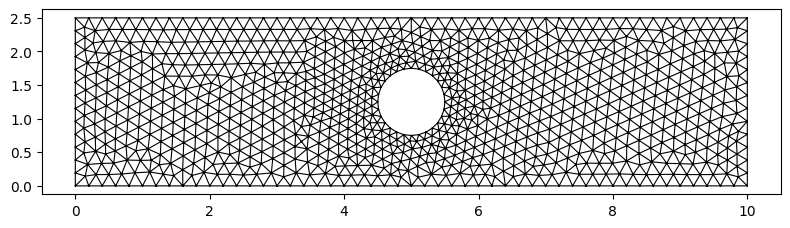

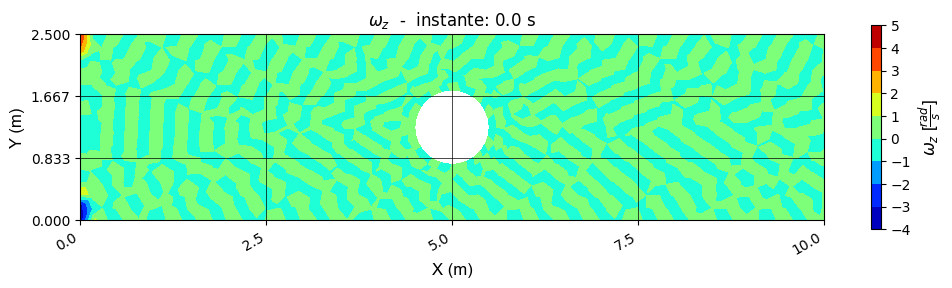

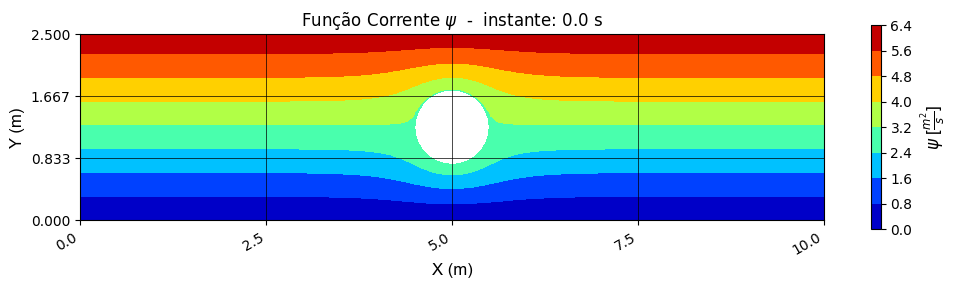

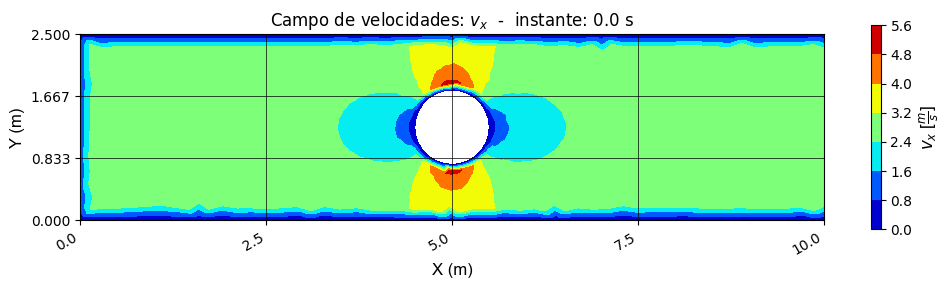

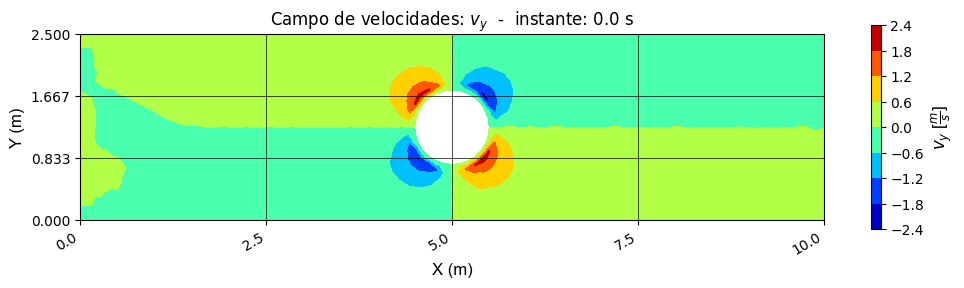

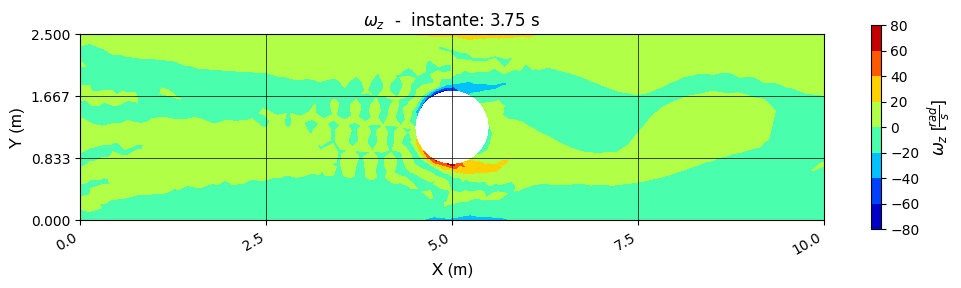

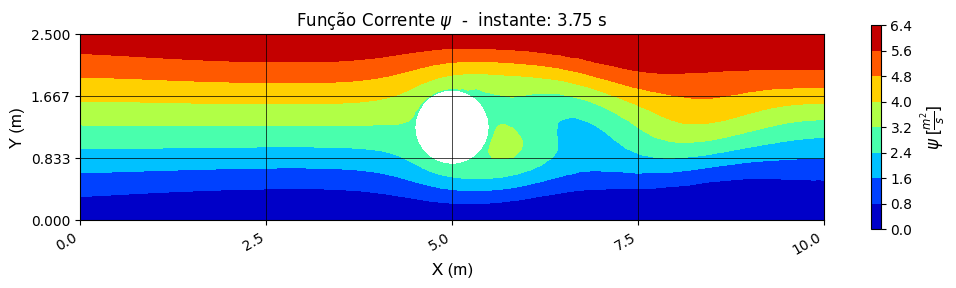

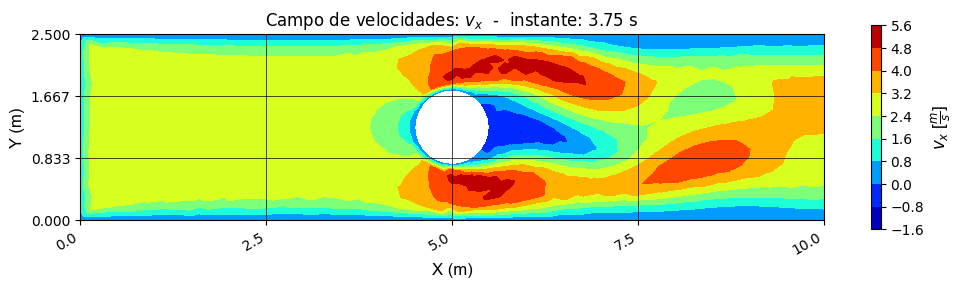

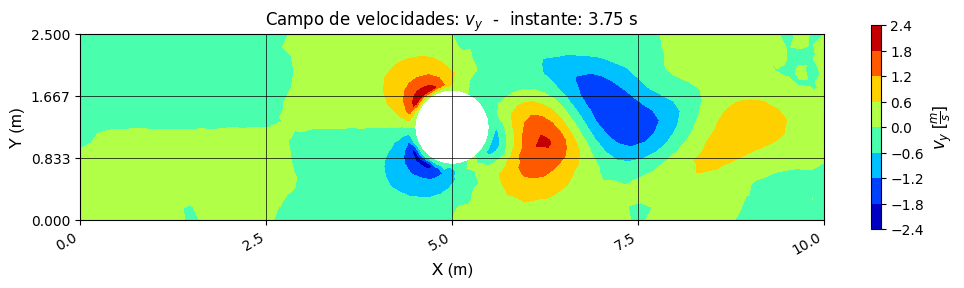

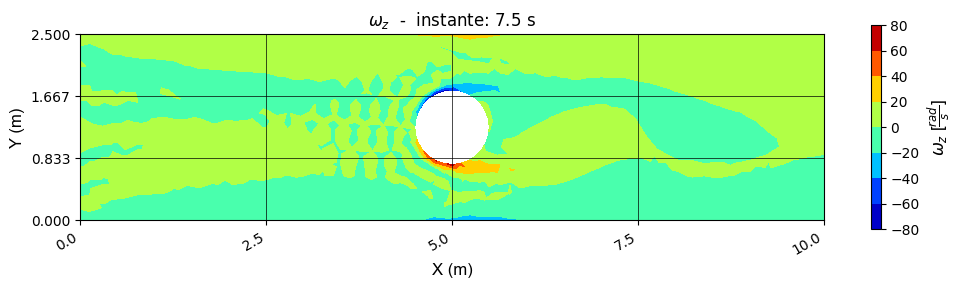

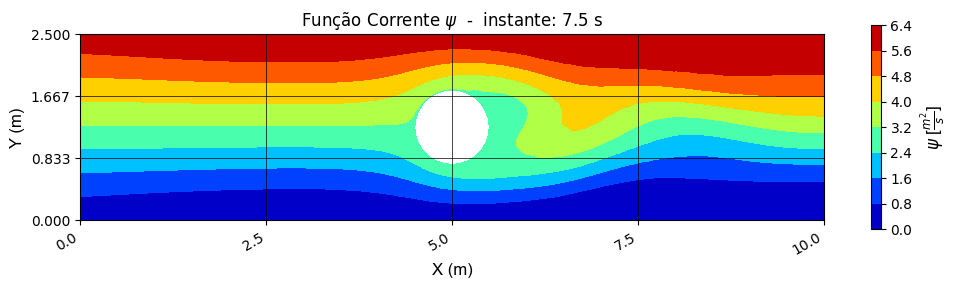

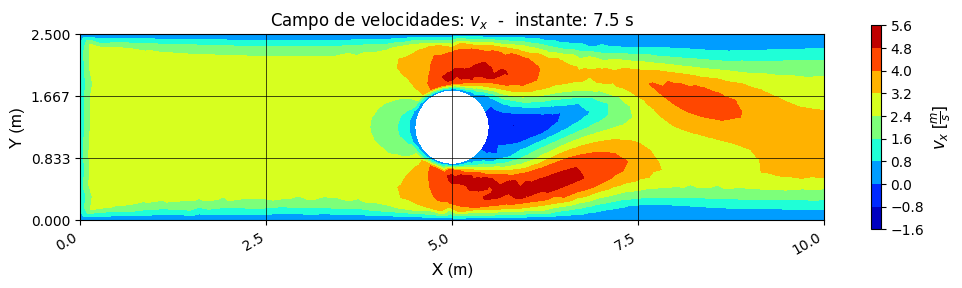

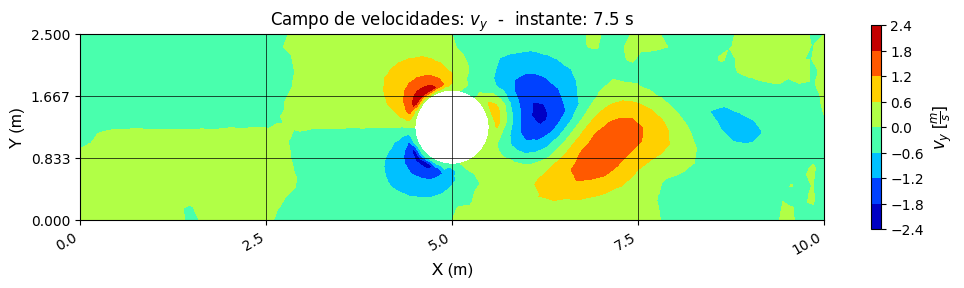

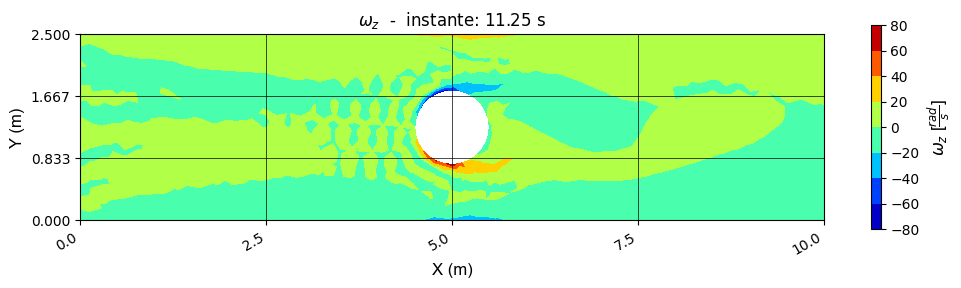

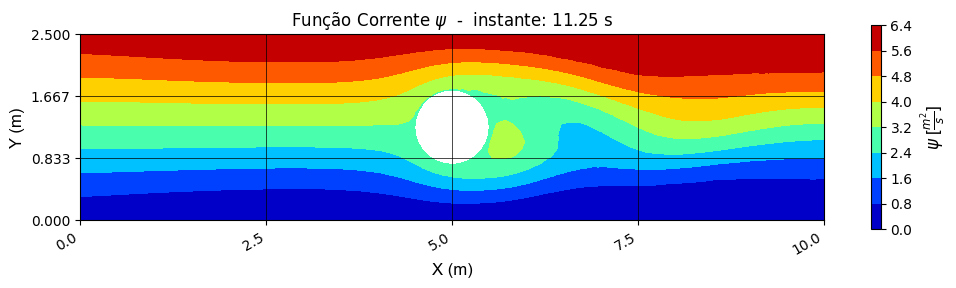

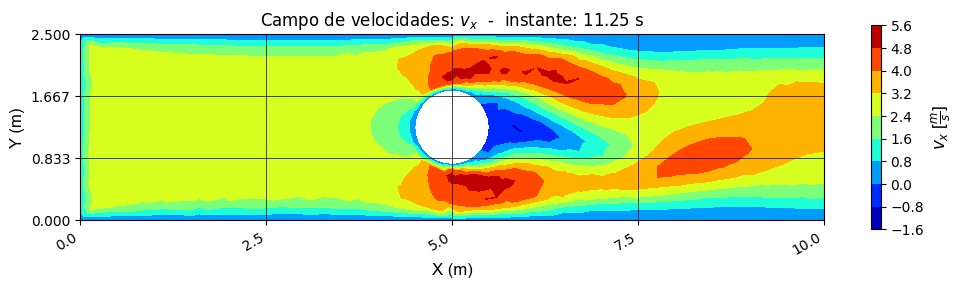

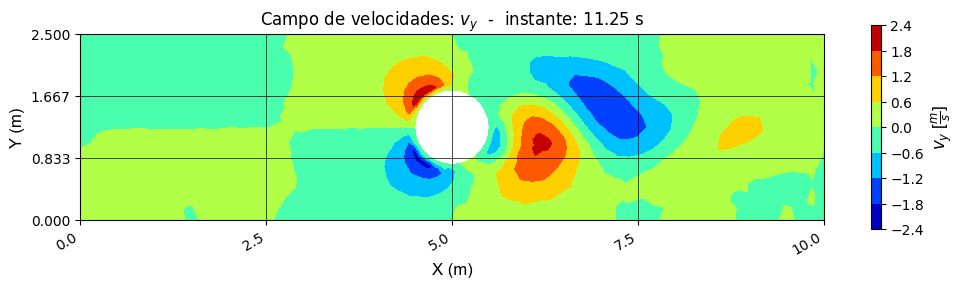

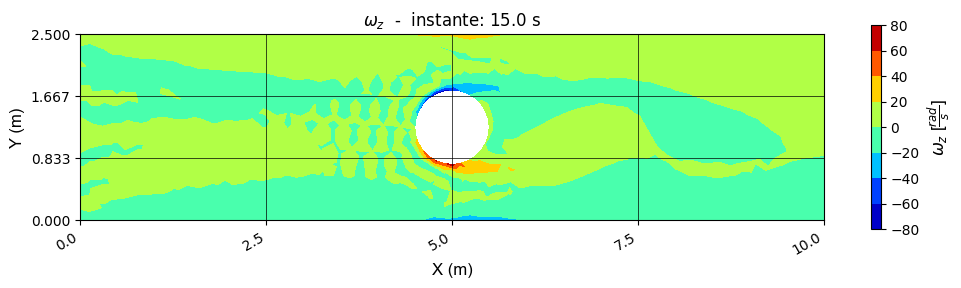

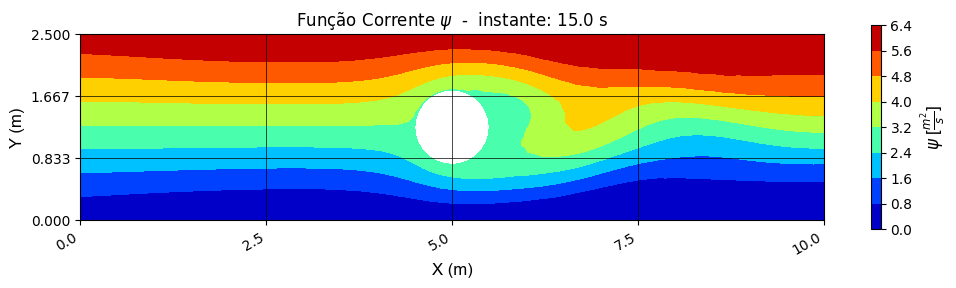

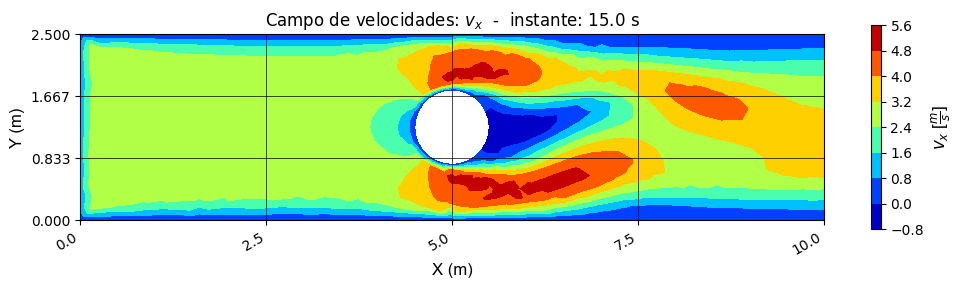

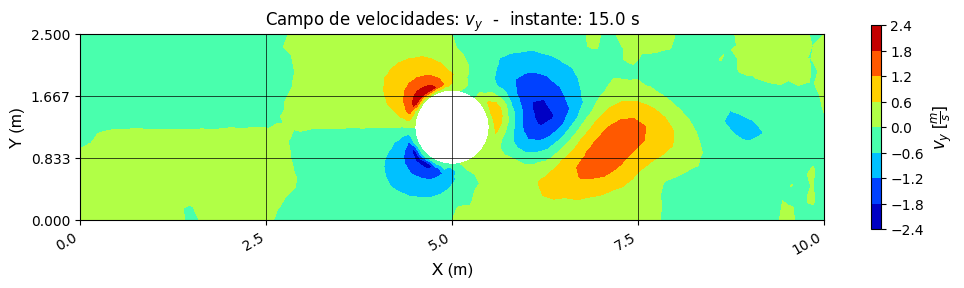

In [ ]:
#--------------------------------------------------
# Fonte dos gráficos
matplot_font = {'fontname': 'Arial',
                'color':  'black',
                'weight': 'normal',
                'size': 12,
                }

# Plotando malha

fig, ax = plt.subplots(figsize = (9.6,2.4))

triang = mtri.Triangulation(X,Y,IEN)
ax.set_aspect('equal')
ax.triplot(triang,'k-', linewidth=0.8)

# Plotando gráficos

for n in range(0,nt,int(nt/4)):
    tempo = n*dt

    ## Vorticidade
    fig, ax0 = plt.subplots(figsize = (12,3))
 
    triang = mtri.Triangulation(X,Y,IEN)
    ax0.set_aspect('equal')
    ax0.tricontourf(triang,CampoVortAd[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax0.tricontourf(triang,CampoVortAd[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\omega_z$ [$\\frac{rad}{s}$]',fontdict=matplot_font)
    plt.title("$\omega_z$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()
    
    ## PSI
    fig, ax1 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax1.set_aspect('equal')
    ax1.tricontourf(triang,CampoPSIAd[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax1.tricontourf(triang,CampoPSIAd[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\psi$ [$\\frac{m^2}{s}$]',fontdict=matplot_font)
    plt.title("Função Corrente $\psi$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vx
    fig, ax2 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax2.set_aspect('equal')
    ax2.tricontourf(triang,CampoVxAd[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax2.tricontourf(triang,CampoVxAd[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_x$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_x$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vy
    fig, ax3 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax3.set_aspect('equal')
    ax3.tricontourf(triang,CampoVyAd[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax3.tricontourf(triang,CampoVyAd[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_y$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_y$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    plt.show()

### Domínio: canal com 3 obstáculos (malha via Gmsh e gerando .vtk)

In [ ]:
# Criando diretório para armazenar solução

#Specify the folder in which results will be exported (mostly graphs)

#workingDir = r"C:\Users\João Pedro\Downloads\ElementosFinitos"   #Notebook pessoal
workingDir = r"C:\Users\jferreira\Downloads\ElementosFinitos"   #TechnipFMC
fileName = "Solucao_canal_3obstaculos_refined2_100_Re_0.03_dt_1.0_vxcc"
outputPath = workingDir + "\\" + fileName

if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    print("Directory " , outputPath ,  " has been created ")
else:
    print("Directory " , outputPath ,  " already exists")

# Propriedades do fluido e domínio:

U = 1.0
L = 1.0
Re = 50

to = 0
tf = 6
dt = 0.03*(U/L)    # adimensionalização do tempo
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
mshname = 'Cilindros_3_refined.msh'
msh = meshio.read('./' + mshname)
print(msh)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 9)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]
####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'Admissao':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'Exaustao':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro1':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro2':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro3':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'CCInferior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'CCSuperior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'CCInferior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'CCSuperior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 1.0/(U*L)               #PSI/(U.L)
 if ccName[i] == 'Admissao':
  vxcc[i] = U/U                      #Vxcc/U
  vycc[i] = 0.0
  PSIcc[i] = Y[i]/(U*L)              #PSI/(U.L)
 if ccName[i] == 'cilindro1' or ccName[i] == 'cilindro2' or ccName[i] == 'cilindro3':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.5/(U*L)               #PSI/(U.L)

# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 kelem = (1/(4*area))*kxelem + (1/(4*area))*kyelem

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                               [1.0,2.0,1.0],
                               [1.0,1.0,2.0]])

 gxelem = (1/6.0)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6.0)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]


# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
PSI = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vx[i] = vxcc[i]
 vy[i] = vycc[i]

# Vorticidade nos contornos no instante inicial
vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))
vort = vort_cc.copy()


# Gravando condições de contorno e iniciais da solução em .vtk
point_data = {'PSIcc_(adim)' : PSIcc}
data_vxcc = {'vxcc_(adim)' : vxcc}
data_vycc = {'vycc_(adim)' : vycc}
data_vort_cc = {'vort_cc_(adim)' : vort_cc}
point_data.update(data_vxcc)
point_data.update(data_vycc)
point_data.update(data_vort_cc)
meshio.write_points_cells(outputPath +'\\'+'condicaoDeContorno.vtk',
                           msh.points, 
                           msh.cells,
                           point_data=point_data,
                           )


CampoVort = np.empty((npoints,nt))
CampoPSI = np.empty((npoints,nt))
CampoVx = np.empty((npoints,nt))
CampoVy = np.empty((npoints,nt))


# Avanço no tempo
for n in range(0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada instante de tempo)
 vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + K/Re + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'CCSuperior' or \
         ccName[i] == 'CCInferior' or \
         ccName[i] == 'cilindro1' or \
         ccName[i] == 'cilindro2' or \
         ccName[i] == 'cilindro3' or \
         ccName[i] == 'Admissao':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 vort = np.linalg.solve(A,b)

 CampoVort[:,n] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
     if ccName[i] == 'CCSuperior' or \
         ccName[i] == 'CCInferior' or \
         ccName[i] == 'cilindro1' or \
         ccName[i] == 'cilindro2' or \
         ccName[i] == 'cilindro3' or \
         ccName[i] == 'Admissao':
         
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 PSI = np.linalg.solve(Apsi,bpsi)

 CampoPSI[:,n] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 vx = np.linalg.solve(M,Gy@PSI)
 vy = np.linalg.solve(M,-Gx@PSI)
 
 
 for i in IENbound:
     if ccName[i] == 'CCSuperior' or \
         ccName[i] == 'CCInferior' or \
         ccName[i] == 'cilindro1' or \
         ccName[i] == 'cilindro2' or \
         ccName[i] == 'cilindro3' or \
         ccName[i] == 'Admissao':
         vx[i] = vxcc[i]
         vy[i] = vycc[i]

 CampoVx[:,n] = vx
 CampoVy[:,n] = vy


 # Gravando solução em .vtk
 print ("... gravando em VTK passo de tempo: " + str(n))
 
 point_data = {'psi_(adim)' : PSI}
 data_vx = {'vx_(adim)' : vx}
 data_vy = {'vy_(adim)' : vy}
 data_vort = {'omega_z_(adim)' : vort}
 point_data.update(data_vx)
 point_data.update(data_vy)
 point_data.update(data_vort)
 meshio.write_points_cells(outputPath +'\\'+'solucao-'+str(n)+'.vtk',
                            msh.points, 
                            msh.cells,
                            point_data=point_data,
                            )
 

In [ ]:
#--------------------------------------------------
# Fonte dos gráficos
matplot_font = {'fontname': 'Arial',
                'color':  'black',
                'weight': 'normal',
                'size': 12,
                }

# Plotando malha

fig, ax = plt.subplots(figsize = (9.6,2.4))

triang = mtri.Triangulation(X,Y,IEN)
ax.set_aspect('equal')
ax.triplot(triang,'k-', linewidth=0.8)

# Plotando gráficos

for n in range(0,nt,int(nt/4)):
    tempo = n*dt

    ## Vorticidade
    fig, ax0 = plt.subplots(figsize = (12,3))
 
    triang = mtri.Triangulation(X,Y,IEN)
    ax0.set_aspect('equal')
    ax0.tricontourf(triang,CampoVort[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax0.tricontourf(triang,CampoVort[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\omega_z$ [$\\frac{rad}{s}$]',fontdict=matplot_font)
    plt.title("$\omega_z$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()
    
    ## PSI
    fig, ax1 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax1.set_aspect('equal')
    ax1.tricontourf(triang,CampoPSI[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax1.tricontourf(triang,CampoPSI[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\psi$ [$\\frac{m^2}{s}$]',fontdict=matplot_font)
    plt.title("Função Corrente $\psi$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vx
    fig, ax2 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax2.set_aspect('equal')
    ax2.tricontourf(triang,CampoVx[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax2.tricontourf(triang,CampoVx[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_x$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_x$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vy
    fig, ax3 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax3.set_aspect('equal')
    ax3.tricontourf(triang,CampoVy[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax3.tricontourf(triang,CampoVy[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_y$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_y$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    plt.show()

### Domínio: meio poroso (malha via Gmsh e gerando .vtk)

In [ ]:
# Criando diretório para armazenar solução

# Specify the folder in which results will be exported (mostly graphs)
#workingDir = r"C:\Users\João Pedro\Downloads\ElementosFinitos"   #Notebook pessoal
workingDir = r"C:\Users\jferreira\Downloads\ElementosFinitos"   #TechnipFMC
fileName = "Solucao_meioPoroso_10_Re_0.015_dt_1.0_vxcc_0.1_L_0.001_nu"
outputPath = workingDir + "\\" + fileName

if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    print("Directory " , outputPath ,  " has been created ")
else:
    print("Directory " , outputPath ,  " already exists")

# Propriedades do fluido e domínio:

U = 1.0
L = 0.1   #Nesse caso não é o comprimento da tubulação, mas o diâmetro dos cilindros!!
Re = 10.0

to = 0
tf = 6
dt = 0.015*(U/L)    # adimensionalização do tempo
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
#mshname = 'canal.msh'
mshname = 'meioPoroso.msh'
msh = meshio.read('./' + mshname)
print(msh)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 57)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]
####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'esquerda':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'direita':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'obstaculo':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'inferior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'superior':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'inferior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'superior':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 1.0/(U*L)               #PSI/(U.L)
 if ccName[i] == 'esquerda':
  vxcc[i] = U/U                      #Vxcc/U
  vycc[i] = 0.0
  PSIcc[i] = Y[i]/(U*L)              #PSI/(U.L)
 if ccName[i] == 'obstaculo':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.5/(U*L)               #PSI/(U.L)

# inicializacao das matrizes globais
ne = IEN.shape[0]
K = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]
 
 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 kelem = (1/(4*area))*kxelem + (1/(4*area))*kyelem

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                               [1.0,2.0,1.0],
                               [1.0,1.0,2.0]])

 gxelem = (1/6.0)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6.0)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]


# condicao inicial de vx,vy (necessárias para cálculo da vorticidade)
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
PSI = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vx[i] = vxcc[i]
 vy[i] = vycc[i]

# Vorticidade nos contornos no instante inicial
vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))
vort = vort_cc.copy()


# Gravando condições de contorno e iniciais da solução em .vtk
point_data = {'PSIcc_(adim)' : PSIcc}
data_vxcc = {'vxcc_(adim)' : vxcc}
data_vycc = {'vycc_(adim)' : vycc}
data_vort_cc = {'vort_cc_(adim)' : vort_cc}
point_data.update(data_vxcc)
point_data.update(data_vycc)
point_data.update(data_vort_cc)
meshio.write_points_cells(outputPath +'\\'+'condicaoDeContorno.vtk',
                           msh.points, 
                           msh.cells,
                           point_data=point_data,
                           )


CampoVort = np.empty((npoints,nt))
CampoPSI = np.empty((npoints,nt))
CampoVx = np.empty((npoints,nt))
CampoVy = np.empty((npoints,nt))


# Avanço no tempo
for n in range(0,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + K/Re + vx_diag@Gx + vy_diag@Gy # implicito para conv e difusao
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'superior' or \
         ccName[i] == 'inferior' or \
         ccName[i] == 'obstaculo' or \
         ccName[i] == 'esquerda':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 vort = np.linalg.solve(A,b)

 CampoVort[:,n] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
     if ccName[i] == 'superior' or \
         ccName[i] == 'inferior' or \
         ccName[i] == 'obstaculo' or \
         ccName[i] == 'esquerda':
         
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 PSI = np.linalg.solve(Apsi,bpsi)

 CampoPSI[:,n] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 vx = np.linalg.solve(M,Gy@PSI)
 vy = np.linalg.solve(M,-Gx@PSI)
 
 
 for i in IENbound:
     if ccName[i] == 'superior' or \
         ccName[i] == 'inferior' or \
         ccName[i] == 'obstaculo' or \
         ccName[i] == 'esquerda':
         vx[i] = vxcc[i]
         vy[i] = vycc[i]

 CampoVx[:,n] = vx
 CampoVy[:,n] = vy


# Gravando solução em .vtk
 print ("... gravando em VTK passo de tempo: " + str(n))
 point_data = {'psi_(adim)' : PSI}
 data_vx = {'vx_(adim)' : vx}
 data_vy = {'vy_(adim)' : vy}
 data_vort = {'omega_z_(adim)' : vort}
 point_data.update(data_vx)
 point_data.update(data_vy)
 point_data.update(data_vort)
 meshio.write_points_cells(outputPath +'\\'+'solucao-'+str(n)+'.vtk',
                            msh.points, 
                            msh.cells,
                            point_data=point_data,
                            )

Directory  C:\Users\jferreira\Downloads\ElementosFinitos\Solucao_meioPoroso_10_Re_0.015_dt_1.0_vxcc_0.1_L_0.001_nu  has been created 

<meshio mesh object>
  Number of points: 5677
  Number of cells:
    line: 490
    triangle: 10886
  Cell data: gmsh:physical, gmsh:geometrical
  Field data: inferior, superior, esquerda, direita, obstaculo, surface
... gravando em VTK passo de tempo: 0
... gravando em VTK passo de tempo: 1
... gravando em VTK passo de tempo: 2
... gravando em VTK passo de tempo: 3
... gravando em VTK passo de tempo: 4
... gravando em VTK passo de tempo: 5
... gravando em VTK passo de tempo: 6
... gravando em VTK passo de tempo: 7
... gravando em VTK passo de tempo: 8
... gravando em VTK passo de tempo: 9
... gravando em VTK passo de tempo: 10
... gravando em VTK passo de tempo: 11
... gravando em VTK passo de tempo: 12
... gravando em VTK passo de tempo: 13
... gravando em VTK passo de tempo: 14
... gravando em VTK passo de tempo: 15
... gravando em VTK passo de tempo:

C:\Users\jferreira\AppData\Local\Temp\ipykernel_12464\4159659642.py:27: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax0.tricontourf(triang,CampoVort[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_12464\4159659642.py:46: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax1.tricontourf(triang,CampoPSI[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_12464\4159659642.py:65: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax2.tricontourf(triang,CampoVx[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
C:\Users\jferreira\AppData\Local\Temp\ipykernel_12464\4159659642.py:84: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax3.tricontourf(triang,CampoVy[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)


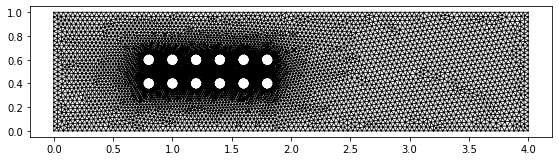

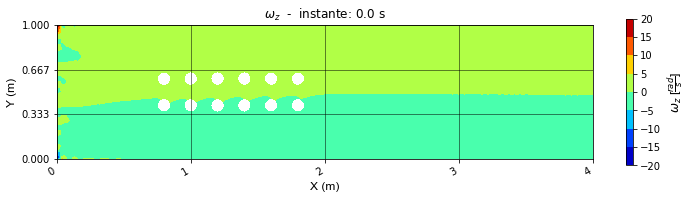

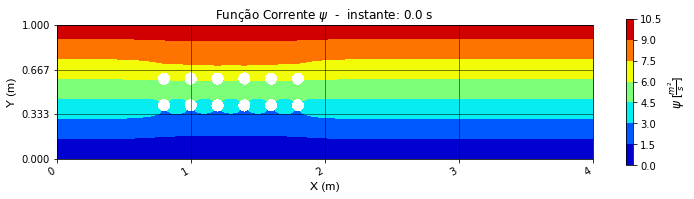

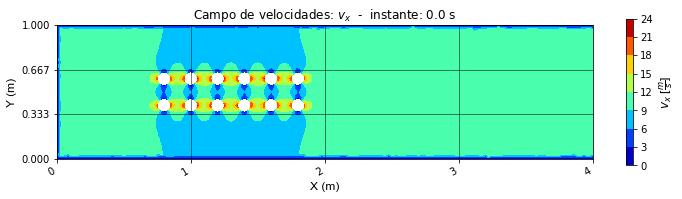

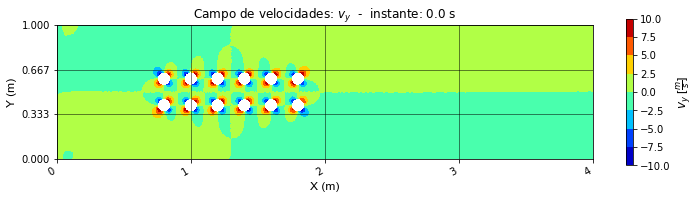

ValueError: z array must not contain non-finite values within the triangulation

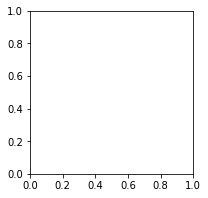

In [ ]:
#--------------------------------------------------
# Fonte dos gráficos
matplot_font = {'fontname': 'Arial',
                'color':  'black',
                'weight': 'normal',
                'size': 12,
                }

# Plotando malha

fig, ax = plt.subplots(figsize = (9.6,2.4))

triang = mtri.Triangulation(X,Y,IEN)
ax.set_aspect('equal')
ax.triplot(triang,'k-', linewidth=0.8)

# Plotando gráficos

for n in range(0,nt,int(nt/4)):
    tempo = n*dt

    ## Vorticidade
    fig, ax0 = plt.subplots(figsize = (12,3))
 
    triang = mtri.Triangulation(X,Y,IEN)
    ax0.set_aspect('equal')
    ax0.tricontourf(triang,CampoVort[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax0.tricontourf(triang,CampoVort[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\omega_z$ [$\\frac{rad}{s}$]',fontdict=matplot_font)
    plt.title("$\omega_z$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()
    
    ## PSI
    fig, ax1 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax1.set_aspect('equal')
    ax1.tricontourf(triang,CampoPSI[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax1.tricontourf(triang,CampoPSI[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$\psi$ [$\\frac{m^2}{s}$]',fontdict=matplot_font)
    plt.title("Função Corrente $\psi$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vx
    fig, ax2 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax2.set_aspect('equal')
    ax2.tricontourf(triang,CampoVx[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax2.tricontourf(triang,CampoVx[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_x$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_x$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    ## vy
    fig, ax3 = plt.subplots(figsize = (12,3))

    triang = mtri.Triangulation(X,Y,IEN)
    ax3.set_aspect('equal')
    ax3.tricontourf(triang,CampoVy[:,n], interpolation='quadric', origin='lower', cmap=cm.jet)
    cbar = plt.colorbar(ax3.tricontourf(triang,CampoVy[:,n],cmap=cm.jet),shrink=1.0, aspect=20)

    cbar.set_label('$v_y$ [$\\frac{m}{s}$]',fontdict=matplot_font)
    plt.title("Campo de velocidades: $v_y$  -  instante: "+ str(round(tempo,2))+" s")
    plt.ylabel("Y (m)",fontdict=matplot_font) 
    plt.xlabel("X (m)",fontdict=matplot_font) 
    labx = np.linspace(X.min(),X.max(),5)
    laby = np.linspace(Y.min(),Y.max(),4)
    plt.grid(color='black', linestyle='solid', linewidth=0.5)
    plt.xticks(labx)
    plt.yticks(laby)
    plt.gcf().autofmt_xdate()

    plt.show()

## Modelagem de partículas no escoamento

$$ \vec{v_p} = \frac{\partial\vec{x_p}}{\partial t} = \vec{v} \;\; \Rightarrow \;\; x^{n+1}_p = x^n_p + v\Delta t $$

In [ ]:
a = np.array([[1,2,3],[4,5,3],[7,8,9],[3,11,12],[13,14,15],[16,3,18]])

print(a[np.where(a[:,0] == 3)])
print(a[np.where(a[:,1] == 3)])
print(a[np.where(a[:,2] == 3)])
print([np.where(a[:,0] == 3)])
Af = np.vstack((a[np.where(a[:,0] == 3)],a[np.where(a[:,1] == 3)],a[np.where(a[:,2] == 3)]))
print(Af)
print(len(Af))

dic = {2 : [0.80,0.21,0.53,3.00,0.98] , 7 : [0.60,0.39,0.40,2.43,0.74,0.68,1.79] , 9 : [0.01,3.12,4.10,1.00]}

keys = list(dic.keys())
print(dic[2])

b = np.array([7.23,22,0.3,41,2])
print(np.where(b[:] == 0.3)[0][0])

c = [[1,2,3],[4,5,3],[7,8,9],[3,11,12],[13,14,15],[16,3,18]]

c.index([4,5,3])

In [ ]:
# Criando diretório para armazenar solução

# Specify the folder in which results will be exported (mostly graphs)
workingDir = r"C:\Users\João Pedro\Downloads\ElementosFinitos"   #Notebook pessoal
#workingDir = r"C:\Users\jferreira\Downloads\ElementosFinitos"   #TechnipFMC
fileName = "Solucao_canal_1particula_0.01_nu_0.03_dt_1.0_vxcc"
outputPath = workingDir + "\\" + fileName

if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    print("Directory " , outputPath ,  " has been created ")
else:
    print("Directory " , outputPath ,  " already exists")

# Propriedades do fluido e domínio:

nu = 0.01

to = 0
tf = 6
dt = 0.03
nt = int((tf-to)/dt+1)

# leitura de malha e classificacao de contorno por nome (ccName)
#mshname = 'canal.msh'
mshname = 'Retangulo.msh'
msh = meshio.read('./' + mshname)
X = np.array(msh.points[:,0])
Y = np.array(msh.points[:,1])
npoints = len(X)
IEN = msh.cells[1].data # triangles
ne = IEN.shape[0]
IENbound = msh.cells[0].data # lines
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 6)
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]

####################################################################################
#O array IENboundTypeElem apresenta séries de números repetidos. Cada série de um número corresponde a um contorno e a quantidade de pontos nele.
#Ex.: 4 contornos, dois com 5 nós, dois com 3 nós: msh.cell_data['gmsh:physical'][0] será [4,4,4,4,4,5,5,5,6,6,6,6,6,7,7,7]
#O nº em série que vai representar cada contorno vai depender de como a entidade física é criada no gmsh. Pode haver, por ex., 5 contornos representados por 5,6,7,8,9
#Para tornar o loop que define o IENboundElem possível, é preciso que se subtraia esses números de forma que eles se tornem 0,1,2,3,4; por isso a subtração por 5 ali.
#Dessa forma, sempre teremos séries de 0, 1, 2, 3, 4 para associar aos nomes de cada contorno, estes por sua vez presentes em "boundaNames".
####################################################################################

# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size))
ccName = [[] for i in range( len(X) )]
# prioridade 4
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'inlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 3
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'outlet':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'cilindro':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 2
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeInf':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
# prioridade 1
for elem in range(0,len(IENbound)):
 if IENboundElem[elem] == 'paredeSup':
  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
  ccName[ IENbound[elem][1] ] = IENboundElem[elem]

IENbound = cc

# Definição dos vetores de condicoes de contorno para vx,vy e psi
vxcc = np.zeros( (npoints),dtype='float' )
vycc = np.zeros( (npoints),dtype='float' )
PSIcc = np.zeros( (npoints),dtype='float' )

for i in IENbound: 
 if ccName[i] == 'paredeInf':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.0
 if ccName[i] == 'paredeSup':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 1.0
 if ccName[i] == 'inlet':
  vxcc[i] = 1.0
  vycc[i] = 0.0
  PSIcc[i] = Y[i]
 if ccName[i] == 'cilindro':
  vxcc[i] = 0.0
  vycc[i] = 0.0
  PSIcc[i] = 0.5


# inicializacao das matrizes globais
Areas = np.empty( ne,dtype='float' )    # Será utilizado mais tarde para obtenção da posição da partícula
K = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )
Gx = np.zeros( (npoints,npoints),dtype='float' )
Gy = np.zeros( (npoints,npoints),dtype='float' )

for e in range(0,ne):
 v1,v2,v3 = IEN[e]

 # Calcula a área do triângulo
 area = 0.5*np.linalg.det([[1.0,X[v1],Y[v1]],
                           [1.0,X[v2],Y[v2]],
                           [1.0,X[v3],Y[v3]]])
 Areas[e] = area

 b1 = Y[v2]-Y[v3]
 b2 = Y[v3]-Y[v1]
 b3 = Y[v1]-Y[v2]

 c1 = X[v3]-X[v2]
 c2 = X[v1]-X[v3]
 c3 = X[v2]-X[v1]

 kxelem = np.array([[b1*b1,b1*b2,b1*b3],
                    [b2*b1,b2*b2,b2*b3],
                    [b3*b1,b3*b2,b3*b3]])
 kyelem = np.array([[c1*c1,c1*c2,c1*c3],
                    [c2*c1,c2*c2,c2*c3],
                    [c3*c1,c3*c2,c3*c3]])
 kelem = (1/(4*area))*kxelem + (1/(4*area))*kyelem

 melem = (area/12.0)*np.array([[2.0,1.0,1.0],
                               [1.0,2.0,1.0],
                               [1.0,1.0,2.0]])

 gxelem = (1/6)*np.array([[b1,b2,b3],
                          [b1,b2,b3],
                          [b1,b2,b3]])
 gyelem = (1/6)*np.array([[c1,c2,c3],
                          [c1,c2,c3],
                          [c1,c2,c3]])


 for ilocal in range(0,3):
  iglobal = IEN[e,ilocal]
  for jlocal in range(0,3):
   jglobal = IEN[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal]
   M[iglobal,jglobal] += melem[ilocal,jlocal]
   Gx[iglobal,jglobal] += gxelem[ilocal,jlocal]
   Gy[iglobal,jglobal] += gyelem[ilocal,jlocal]


# condição inicial de vx,vy (necessárias para cálculo da vorticidade nos contornos)
vx = np.zeros( (npoints),dtype='float' )
vy = np.zeros( (npoints),dtype='float' )
PSI = np.zeros( (npoints),dtype='float' )

for i in IENbound:
 vx[i] = vxcc[i]
 vy[i] = vycc[i]

# Vorticidade nos contornos
vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))

# Gravando condições de contorno e iniciais da solução em .vtk
point_data = {'PSIcc' : PSIcc}
data_vxcc = {'vxcc' : vxcc}
data_vycc = {'vycc' : vycc}
data_vort_cc = {'vort_cc' : vort_cc}
point_data.update(data_vxcc)
point_data.update(data_vycc)
point_data.update(data_vort_cc)
meshio.write_points_cells(outputPath +'\\'+'condicaoDeContorno.vtk',
                           msh.points, 
                           msh.cells,
                           point_data=point_data,
                           )


# Cálculo da vorticidade, função corrente e velocidade para o 1º instante
CampoVort = np.empty((npoints,nt))
CampoPSI = np.empty((npoints,nt))
CampoVx = np.empty((npoints,nt))
CampoVy = np.empty((npoints,nt))
ParticulaX = np.empty(nt)
ParticulaY = np.empty(nt)

vort = vort_cc.copy()
CampoVort[:,0] = vort

## Solução da Equação de Corrente-Vorticidade
Apsi = K.copy()
bpsi = M@vort

### Imposição das c.c.s de Dirichlet
for i in IENbound:
  if ccName[i] == 'paredeSup' or \
      ccName[i] == 'paredeInf' or \
      ccName[i] == 'cilindro' or \
      ccName[i] == 'inlet':
        Apsi[i,:] = 0.0 # zerando a linha
        Apsi[i,i] = 1.0 # colocando 1 na diagonal
        bpsi[i]   = PSIcc[i]

### Solução
PSI = np.linalg.solve(Apsi,bpsi)

CampoPSI[:,0] = PSI

## Obtendo campo de velocidades a partir da função corrrente
vx = np.linalg.solve(M,Gy@PSI)
vy = np.linalg.solve(M,-Gx@PSI)


for i in IENbound:
  if ccName[i] == 'paredeSup' or \
      ccName[i] == 'paredeInf' or \
      ccName[i] == 'cilindro' or \
      ccName[i] == 'inlet':
        vx[i] = vxcc[i]
        vy[i] = vycc[i]

CampoVx[:,0] = vx
CampoVy[:,0] = vy

## Posição inicial da partícula

xpo = 0.4
ypo = 0.6
ParticulaX[0] = xpo
ParticulaY[0] = ypo

## Localizando elemento em que ela se encontra
for e in range(0,ne):

  v1,v2,v3 = IEN[e]

  L1 = np.sqrt((ParticulaX[0]-X[v1])**2+(ParticulaY[0]-Y[v1])**2)
  L2 = np.sqrt((ParticulaX[0]-X[v2])**2+(ParticulaY[0]-Y[v2])**2)
  L3 = np.sqrt((ParticulaX[0]-X[v1])**2+(ParticulaY[0]-Y[v3])**2)

  if L1+L2+L3 == 1:
    break

A = Areas[e]
X1,X2,X3,Y1,Y2,Y3 = X[v1],X[v2],X[v3],Y[v1],Y[v2],Y[v3]   # vértices do elemento onde a partícula se encontra
Eo = IEN [e]


# Avanço no tempo
for n in range(1,nt):

 ## Solução do sistema linear para vorticidade

 ### Cálculo da condição de contorno da vorticidade (atualizando vorticidade nos contornos a cada iteração)
 vort_cc = np.linalg.solve(M,(Gx@vy - Gy@vx))

 ### Montagem da matriz A
 vx_diag = np.diag(vx)
 vy_diag = np.diag(vy)

 ### Montagem da matriz A e do vetor b de transporte de vorticidade
 A = M/dt + nu*K + vx_diag@Gx + vy_diag@Gy # implícito para conv e difusão
 b = (M/dt)@vort
 
 ### Condição de contorno para o sistema linear Ax=b
 for i in IENbound:
     if ccName[i] == 'paredeSup' or \
         ccName[i] == 'paredeInf' or \
         ccName[i] == 'cilindro' or \
         ccName[i] == 'inlet':

         A[i,:] = 0.0 # zerando a linha
         A[i,i] = 1.0 # colocando 1 na diagonal
         b[i]   = vort_cc[i]

 ### Solução
 vort = np.linalg.solve(A,b)

 CampoVort[:,n] = vort

 ## Solução da Equação de Corrente-Vorticidade

 Apsi = K.copy()

 bpsi = M@vort

 ### Imposição das c.c.s de Dirichlet
 for i in IENbound:
    if ccName[i] == 'paredeSup' or \
       ccName[i] == 'paredeInf' or \
       ccName[i] == 'cilindro' or \
       ccName[i] == 'inlet':
         Apsi[i,:] = 0.0 # zerando a linha
         Apsi[i,i] = 1.0 # colocando 1 na diagonal
         bpsi[i]   = PSIcc[i]

 ### Solução
 PSI = np.linalg.solve(Apsi,bpsi)

 CampoPSI[:,n] = PSI

 ## Obtendo campo de velocidades a partir da função corrrente

 vx = np.linalg.solve(M,Gy@PSI)
 vy = np.linalg.solve(M,-Gx@PSI)
 
 
 for i in IENbound:
    if ccName[i] == 'paredeSup' or \
       ccName[i] == 'paredeInf' or \
       ccName[i] == 'cilindro' or \
       ccName[i] == 'inlet':
         vx[i] = vxcc[i]
         vy[i] = vycc[i]

 CampoVx[:,n] = vx
 CampoVy[:,n] = vy


 ## Obtendo posição da partícula
 ### Localizando partícula

 IENParticula = Eo   # Linha da IEN respectiva ao elemento em que a partícula está
 flag = 0     #Sinalizador que indicará se o loop alcançou ou não o elemento em que a partícula se encontra

 while flag != 1:

  dicioElementos = {}
  dicioValoresElementos = {}
  for vertice in IENParticula:

    IEN0Vertice = IEN[np.where(IEN[:,0] == vertice)]
    IEN1Vertice = IEN[np.where(IEN[:,1] == vertice)]
    IEN2Vertice = IEN[np.where(IEN[:,2] == vertice)]   # Todos os três respectivos a um mesmo vértice

    IENVertice = np.vstack((IEN0Vertice,IEN1Vertice,IEN2Vertice))   # Array listando os elementos ligados a um ÚNICO vértice do triângulo onde a partícula se encontra
    nElementosVertice = len(IENVertice)
    
    dicioElementos[vertice] = IENVertice   # Dict que associa cada vértice a uma lista de linhas da IEN associadas aos elementos adjacentes a esse vértice

    listaValoresElementosVertice = []
    for e in range(0,nElementosVertice):

      v1,v2,v3 = IENVertice[e]

      L1 = np.sqrt((ParticulaX[n]-X[v1])**2+(ParticulaY[n]-Y[v1])**2)
      L2 = np.sqrt((ParticulaX[n]-X[v2])**2+(ParticulaY[n]-Y[v2])**2)
      L3 = np.sqrt((ParticulaX[n]-X[v3])**2+(ParticulaY[n]-Y[v3])**2)
      criterio = L1+L2+L3
      round(criterio, 2)
      listaValoresElementosVertice.append(criterio)

    dicioValoresElementos[vertice] = listaValoresElementosVertice   # Dict que associa cada vértice ao valor de critério obtido para cada elemento adjacente ao vértice


  Vertices = list(dicioValoresElementos.keys())

  for key in Vertices:   #Loop nos vértices para avaliar os elementos associados a cada vértice
    
    ValoresElementosVertice = dicioValoresElementos.get(key)

    if (1.00 in ValoresElementosVertice) == True:
      posicaoLinhaNaListaDeLinhas = ValoresElementosVertice.index(1.00)

      ListaDeLinhas = np.array(dicioElementos.get(key))
      linhaIEN = ListaDeLinhas[posicaoLinhaNaListaDeLinhas][0]   #A lista de linhas está assim: [ [[n1,n2,n3]],[[n4,n5,n6]] ], por isso o index [0]
    
      e = np.where(IEN[:] == linhaIEN)[0][0]

      A = Areas[e]
      v1,v2,v3 = linhaIEN
      X1,X2,X3,Y1,Y2,Y3 = X[v1],X[v2],X[v3],Y[v1],Y[v2],Y[v3]   # Vértices do elemento onde a partícula se encontra

      ### funções de interpolação

      vxp = N2D_11(ParticulaX[n-1],ParticulaY[n-1],X1,X2,X3,Y1,Y2,Y3,A)*CampoVx[v1,n-1] + N2D_12(ParticulaX[n-1],ParticulaY[n-1],X1,X2,X3,Y1,Y2,Y3,A)*CampoVx[v2,n-1] + N2D_13(ParticulaX[n-1],ParticulaY[n-1],X1,X2,X3,Y1,Y2,Y3,A)*CampoVx[v3,n-1]
      vyp = N2D_11(ParticulaX[n-1],ParticulaY[n-1],X1,X2,X3,Y1,Y2,Y3,A)*CampoVy[v1,n-1] + N2D_12(ParticulaX[n-1],ParticulaY[n-1],X1,X2,X3,Y1,Y2,Y3,A)*CampoVy[v2,n-1] + N2D_13(ParticulaX[n-1],ParticulaY[n-1],X1,X2,X3,Y1,Y2,Y3,A)*CampoVy[v3,n-1]

      xp = ParticulaX[n-1] + vxp*dt
      yp = ParticulaY[n-1] + vyp*dt

      ParticulaX[n] = xp
      ParticulaY[n] = yp

      flag += 1

  if flag == 0:

    def closest(lista, K):
      return lista[min( range(len(lista)), key = lambda i: abs(lista[i]-K) )]

    closestValues = {}
    for key in Vertices:   #Loop nos vértices para avaliar os elementos associados a cada vértice
    
      ValoresElementosVertice = np.array(dicioValoresElementos.get(key))
      closerValue = closest( ValoresElementosVertice,1.00 )
      posicaoValorEmListaValores = np.where(ValoresElementosVertice[:] == closerValue)[0][0]

      ListaLinhasDoVertice = dicioElementos[key]
      LinhaDoElemento = ListaLinhasDoVertice[posicaoValorEmListaValores]
      #A posição do valor associado a um elemento na lista de valores deve ser a mesma q a posição da linha respectiva na lista de linhas

      closestValues[closerValue] = [key,LinhaDoElemento]

    closestValue = closest( list(closestValues.keys()),1.00 )
    Vertice, LinhaDoElementoMaisProximo = closestValues[closestValue]
    print(LinhaDoElementoMaisProximo)
    IENParticula = LinhaDoElementoMaisProximo


  # Gravando solução em .vtk
 print("... gravando em VTK passo de tempo: " + str(n))
 point_data = {'psi' : PSI}
 data_vx = {'vx' : vx}
 data_vy = {'vy' : vy}
 data_vort = {'omega_z' : vort}
 data_xp = {'xp' : xp}
 data_yp = {'yp' : yp}
 point_data.update(data_vx)
 point_data.update(data_vy)
 point_data.update(data_vort)
 point_data.update(data_xp)
 point_data.update(data_yp)
 meshio.write_points_cells(outputPath +'\\'+'solucao-'+str(n)+'.vtk',
                             msh.points, 
                             msh.cells,
                             point_data=point_data,
                             )